In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import pickle
import cloudpickle
import xgboost
from sklearn.metrics import classification_report
from comparers import ModelComparer
from sklearn.model_selection import StratifiedKFold, train_test_split
from helper_models import LogProbabilityMixin
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order,\
                       plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                       plot_feature_effects, plot_forces, merge_explanations, plot_decision,\
                       perform_hierarchical_clustering, plot_dendrogram, extract_clustering,\
                       get_class_occurences_in_clusters, plot_feature_influence_comparison,\
                       plot_class_importances
from diro2c_wrapper import generate_diro2c_explanation, plot_diro2c_2d, plot_diro2c_tree
import matplotlib.pyplot as plt
from IPython.display import display

XGBoost prints many warnings, that are safe to ignore:

In [2]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [3]:
try:
    with open('shap-values.pickle', 'rb') as f:
        explanations, indices_nonfinite_predictions, explanations_nonfinite = pickle.load(f)
    with open('classifiers.pickle', 'rb') as f:
        clf_a, clf_b = pickle.load(f)
        comparer = ModelComparer(clf_a, clf_b, explanations.feature_names)
    is_pred_diff = comparer.predict_bin_diff(explanations.data)
    mclass_diff = comparer.predict_mclass_diff(explanations.data)
    print('Loaded state')
except FileNotFoundError:
    pass

Loaded state


# Setup Task

In [152]:
df = pd.read_csv('day.csv', parse_dates=['dteday'])
df

instant     dteday  season  yr  mnth  holiday  weekday  workingday  \
0          1 2011-01-01       1   0     1        0        6           0   
1          2 2011-01-02       1   0     1        0        0           0   
2          3 2011-01-03       1   0     1        0        1           1   
3          4 2011-01-04       1   0     1        0        2           1   
4          5 2011-01-05       1   0     1        0        3           1   
..       ...        ...     ...  ..   ...      ...      ...         ...   
726      727 2012-12-27       1   1    12        0        4           1   
727      728 2012-12-28       1   1    12        0        5           1   
728      729 2012-12-29       1   1    12        0        6           0   
729      730 2012-12-30       1   1    12        0        0           0   
730      731 2012-12-31       1   1    12        0        1           1   

     weathersit      temp     atemp       hum  windspeed  casual  registered  \
0             2  0.344167  0.363625  0.805833   0.160446     331         654   
1             2  0.363478  0.353739  0.696087   0.248539     131         670   
2             1  0.196364  0.189405  0.437273   0.248309     120        1229   
3             1  0.200000  0.212122  0.590435   0.160296     108        1454   
4             1  0.226957  0.229270  0.436957   0.186900      82        1518   
..          ...       ...       ...       ...        ...     ...         ...   
726           2  0.254167  0.226642  0.652917   0.350133     247        1867   
727           2  0.253333  0.255046  0.590000   0.155471     644        2451   
728           2  0.253333  0.242400  0.752917   0.124383     159        1182   
729           1  0.255833  0.231700  0.483333   0.350754     364        1432   
730           2  0.215833  0.223487  0.577500   0.154846     439        2290   

      cnt  
0     985  
1     801  
2    1349  
3    1562  
4    1600  
..    ...  
726  2114  
727  3095  
728  1341  
729  1796  
730  2729  

[731 rows x 16 columns]

For this research, I simplify the regression problem to a binary classification problem: To predict, whether the bike share count is above a certain threshold.

In [3]:
is_over_threshold = df['cnt'] > 4500

In order to make use of the unique properties of this dataset and investigate the suitability for analysing data drift, I split it in two parts: classifier A is trained on data of year 2011 and classifier B on data of year 2012. This dataset is well known for its characteristic that bike sharing became more popular over time.

In [5]:
is_part1 = df['dteday'] < datetime(2012, 1, 1)

<AxesSubplot:xlabel='dteday', ylabel='cnt'>

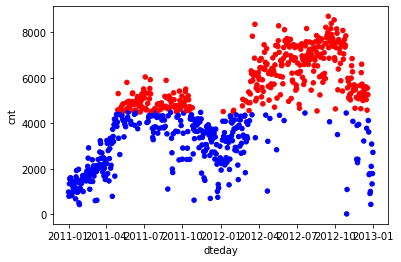

In [4]:
color = np.repeat('b', df.shape[0])
color[is_over_threshold] = 'r'
color
df.plot(x='dteday', y='cnt', kind='scatter', color=color)

I chose the threshold manually to yield similarly unbalanced training datasets.

In [6]:
np.sum(is_over_threshold[is_part1])

102

In [7]:
np.sum(~is_over_threshold[is_part1])

263

In [8]:
np.sum(is_over_threshold[~is_part1])

270

In [9]:
np.sum(~is_over_threshold[~is_part1])

96

I also remove the features yr and dteday from the dataset, because it doesn't contain usable information for the tasks.

In [10]:
feature_names = ['season', 'mnth', 'holiday', 'weekday', 'workingday',
                 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
X = df.loc[:, feature_names]
y = is_over_threshold.astype(int)

In [11]:
X_train1 = X[is_part1]
y_train1 = y[is_part1]
X_train2 = X[~is_part1]
y_train2 = y[~is_part1]

In [4]:
class XGBClassifierWithLogProbaPredict(xgboost.XGBClassifier, LogProbabilityMixin):
    pass

In [14]:
def make_classifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    skf = StratifiedKFold(n_splits=10)
    best_score = 0
    for train_index, test_index in skf.split(X_train, y_train):
        clf = XGBClassifierWithLogProbaPredict(n_jobs=4, use_label_encoder=False, eval_metric='logloss')
        clf.fit(X.iloc[train_index], y.iloc[train_index])
        score = clf.score(X.iloc[test_index], y.iloc[test_index])
        if score > best_score:
            best_clf, best_score = clf, score
        print(score)
    print(classification_report(y_test, best_clf.predict(X_test)))
    return best_clf

In [19]:
%%time
clf_a = make_classifier(X_train1, y_train1)

1.0
1.0
0.9310344827586207
0.8275862068965517
0.8620689655172413
0.6896551724137931
0.7586206896551724
0.6206896551724138
0.7931034482758621
0.6896551724137931
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        53
           1       0.91      1.00      0.95        20

    accuracy                           0.97        73
   macro avg       0.95      0.98      0.97        73
weighted avg       0.98      0.97      0.97        73

CPU times: user 2.77 s, sys: 441 ms, total: 3.21 s
Wall time: 13.2 s


In [20]:
%%time
clf_b = make_classifier(X_train2, y_train2)

0.9666666666666667
1.0
0.7931034482758621
0.8620689655172413
0.896551724137931
0.9655172413793104
0.9655172413793104
0.9655172413793104
0.9310344827586207
0.896551724137931
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.98      1.00      0.99        55

    accuracy                           0.99        74
   macro avg       0.99      0.97      0.98        74
weighted avg       0.99      0.99      0.99        74

CPU times: user 2.11 s, sys: 330 ms, total: 2.44 s
Wall time: 3.46 s


In [21]:
print(classification_report(y_train2, clf_a.predict(X_train2)))

              precision    recall  f1-score   support

           0       0.40      1.00      0.57        96
           1       1.00      0.46      0.63       270

    accuracy                           0.60       366
   macro avg       0.70      0.73      0.60       366
weighted avg       0.84      0.60      0.61       366



In [22]:
import pickle

In [9]:
with open('classifiers.pickle', 'wb') as f:
    cloudpickle.dump((clf_a, clf_b), f, pickle.HIGHEST_PROTOCOL)

In [25]:
comparer = ModelComparer(clf_a, clf_b, X.columns)

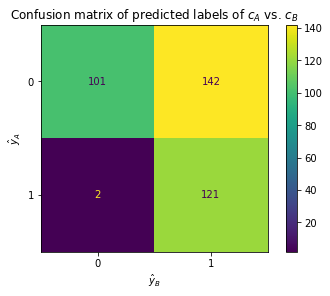

In [26]:
comparer.plot_confusion_matrix(X_train2)

We can see already, that A predicts a lot more often less than 4500 shares than B, reflected in the high number of instances in difference class $(0,1)$. On the contrary, only two instances fall into $(1,0)$.

In [27]:
is_pred_diff = comparer.predict_bin_diff(X_train2)
mclass_diff = comparer.predict_mclass_diff(X_train2)

In [28]:
import shap
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order,\
                       plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                       plot_feature_effects, plot_forces, merge_explanations, plot_decision,\
                       perform_hierarchical_clustering, plot_dendrogram, extract_clustering,\
                       get_class_occurences_in_clusters, plot_feature_influence_comparison,\
                       plot_class_importances

In [29]:
%%time
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X_train2, masker=masker,
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['log_odds'])

Exact explainer: 367it [04:31,  1.33it/s]                         
Exact explainer: 367it [03:09,  1.83it/s]                         
Exact explainer: 367it [08:05,  1.35s/it]                         

CPU times: user 50min 11s, sys: 1min 45s, total: 51min 56s
Wall time: 15min 45s


In [32]:
with open('shap-values.pickle', 'wb') as f:
    pickle.dump((explanations, indices_nonfinite_predictions, explanations_nonfinite), f, pickle.HIGHEST_PROTOCOL)

# Global Explanations

## Individual Classifiers' SHAP Values

Both classifiers have the same most important feature: `temp`. Besides that, they're quite different.
`mnth`, `hum`, `atemp`, `weekday`, `workingday` have bigger importance for A than for B.
`season`, `weathersit` have higher importance for B than for A. Finally, holiday is not important for either.
Therefore I will omit it from further explanations.

Based on this, I formulate the following theories:
- Both classifiers are influenced by time of the year: A more by month, B more by season
- Both classifiers are influenced by weather conditions: A more by temperature and humidity, B more by weathersituation
- holiday is not used to make decisions, because workingday is already sufficient
- B depends less on weekday and workingday, possibly indicating a shift of habits

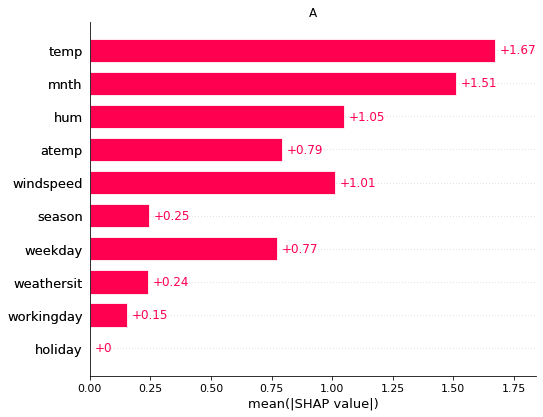

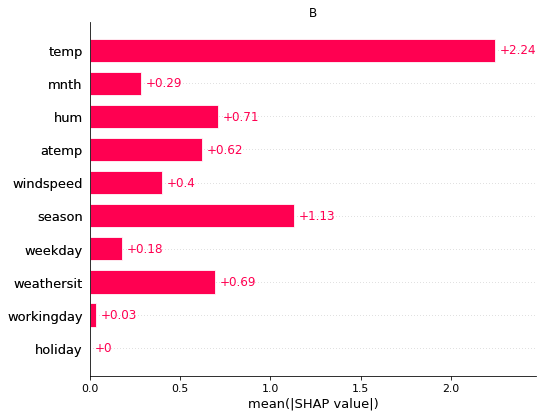

In [54]:
feature_order, _ = calc_feature_order(explanations.indiv.log_odds[:, :, 1])
plot_feature_importance_bar(explanations.indiv.log_odds.A[:, :, 1], title='A', feature_order=feature_order)
plot_feature_importance_bar(explanations.indiv.log_odds.B[:, :, 1], title='B', feature_order=feature_order)

In [56]:
feature_order = feature_order[:9]

In [63]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(explanations.indiv.log_odds[:, [feature_idx], 1], 'SHAP Summary Plots')
    plot_feature_effects(merge_explanations(individual=explanations.indiv.log_odds[:, [feature_idx], 1],
                                            difference=explanations.indiv_diff.log_odds[:, [feature_idx], 1]),
                         title='SHAP Dependence Plots', color=is_pred_diff)
it = iter(feature_order)

In the SHAP summary plot we can see, that the most important feature `temp`
generally indicates an increase in log odds for high values
and a decrease in log odds for low values.
But the distribution is different:
For A, low feature values indicate a very specific decrease of log odds.
On the contrary, there is a wide range of different SHAP values for B.
This indicates, that there are many different ways low temperature values influences the prediction in B,
but only a few in A.

For A, we can see a stepped effect from low to high feature values with the step at 0.5,
which gradually decreases again at 0.7.
For B, the effect of `temp` gradually increases, starting from 0.3 until it reaches its maximum at 0.5.

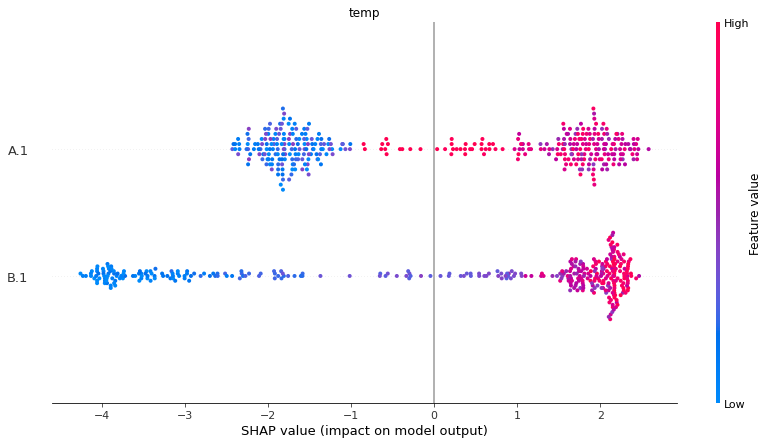

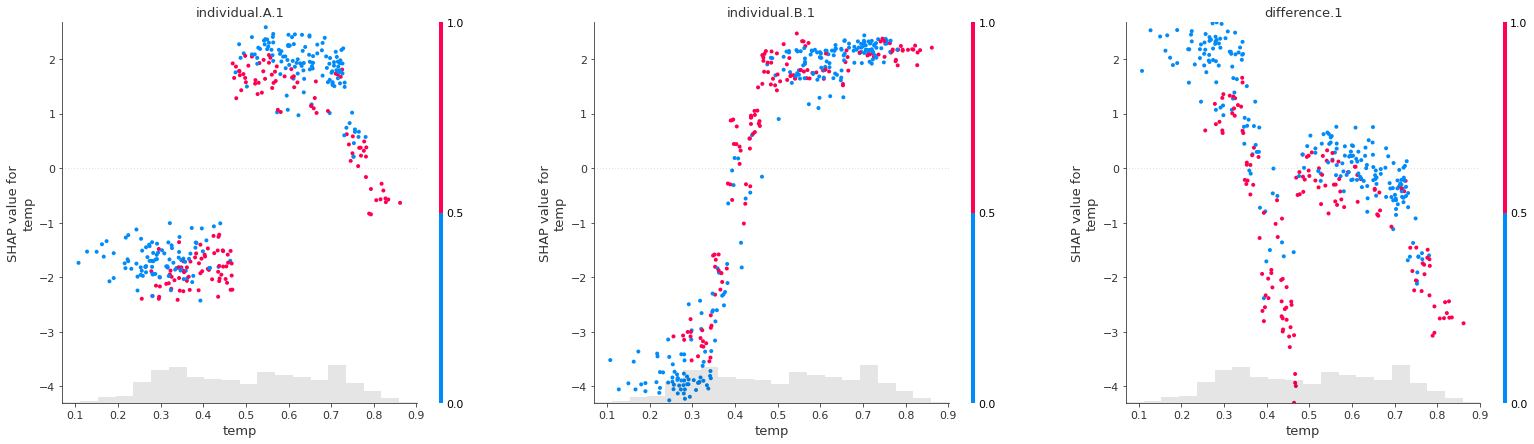

In [64]:
plot_next_feature()

As previously noted in the feature importance section, `mnth` is much more important
to A than to B. Higher feature values increase the log odds prediction to a varying extent in A,
whereas in B they nearly have no influence. Lower feature values decrease the log odds prediction
in A, but there are instances in B where they either increase or decrease the log odds prediction.

According to the feature effects plots, the first four months have a negative effect while the
higher months have a positive effect on the outcome of A.
For B, only the first two months have a negative effect and especially month 3 has a positive effect.

Similarly to the effects plots of `temp`, we see
a vertical separation of instances classified differently and equally, which means,
interaction effects are present.

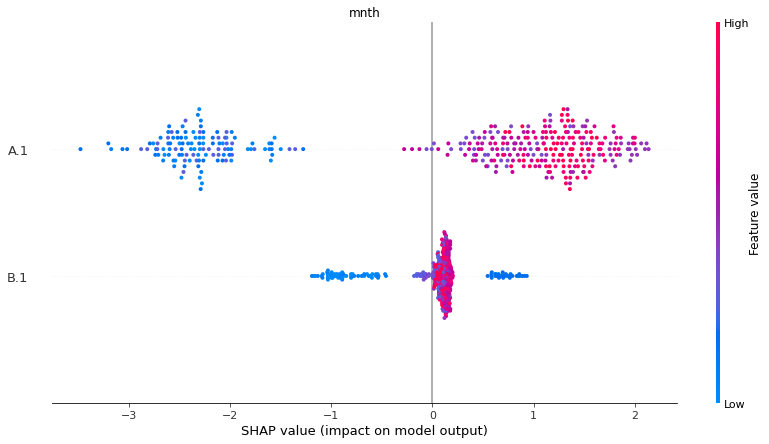

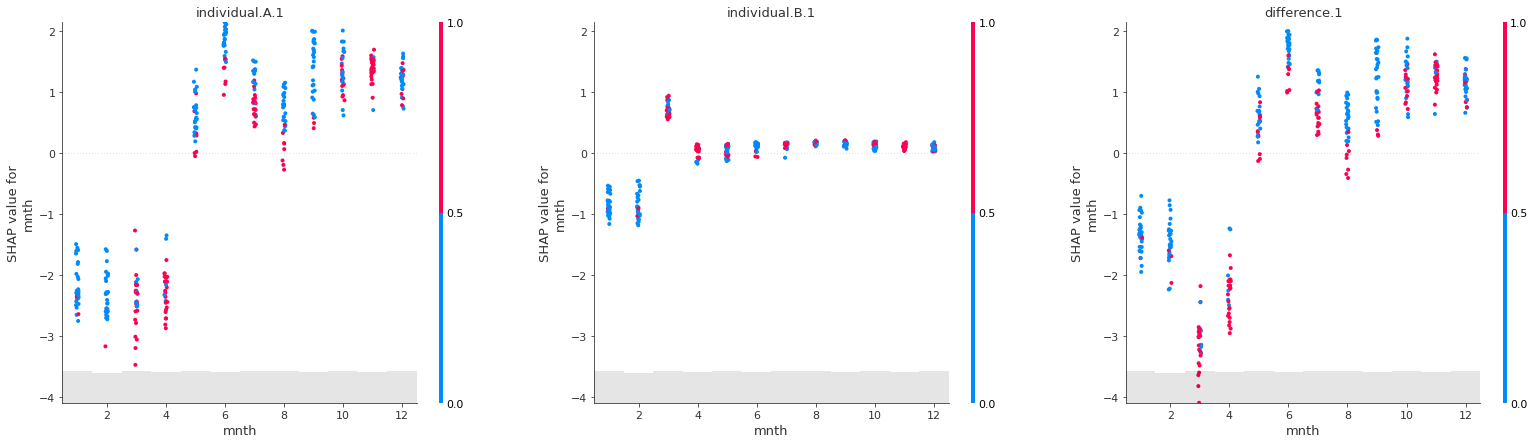

In [65]:
plot_next_feature()

For both classifiers, high `hum` values decrease the log odds outcome to a similar extent.
But the lower values are different. In B, they flat out between 0.5 and 1, but in A,
they continue to increase for lower values. This means, that in B, there are not many ways
how low values of `hum` can influence the outcome, but there are many for A.

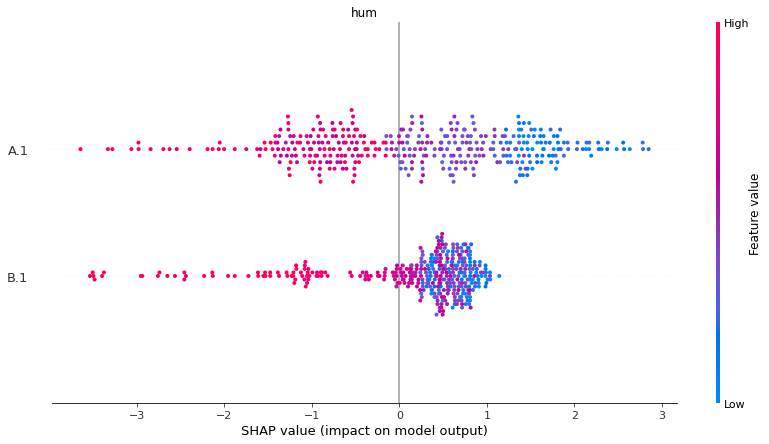

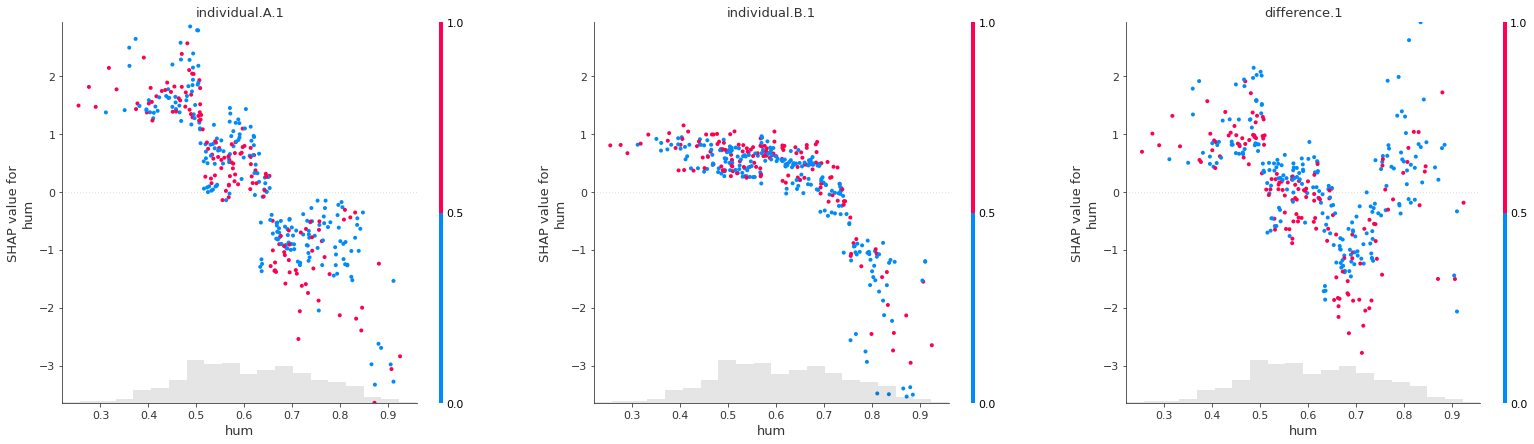

In [66]:
plot_next_feature()

High feature values of `atemp` influence the models differently:
For A, it has quite diverse effects ranging from -3 to +2, whereas for B,
it just indicates a small positive influence.

The effects look similar, except for values above 0.7,
where all instances are classified differently.
Here we observe a negative influence on A but positive influence on B.

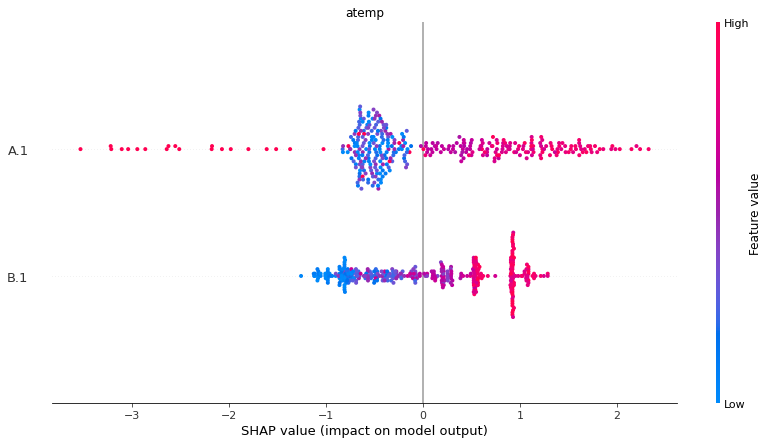

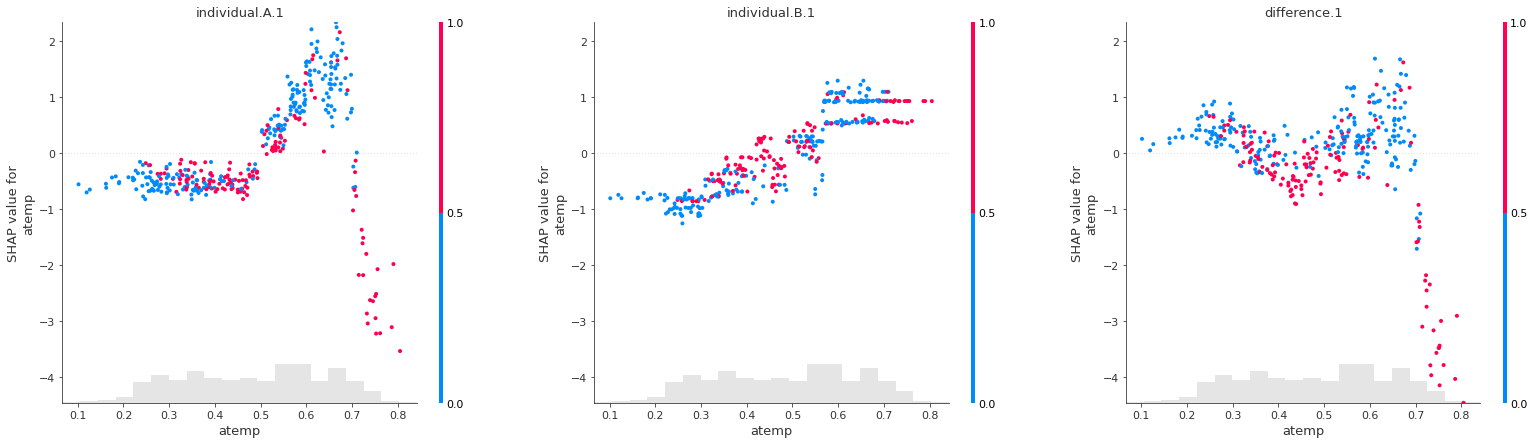

In [67]:
plot_next_feature()

Windspeed has higher and more pronounced influence on model A than B, with low feature
values increasing and high feature values decreasing the outcome.

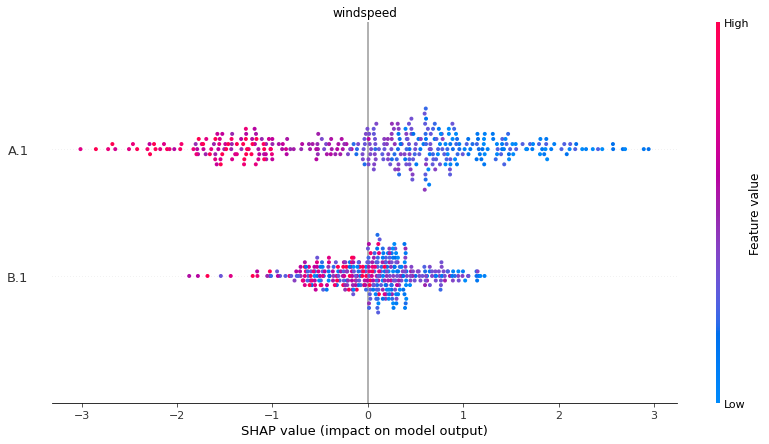

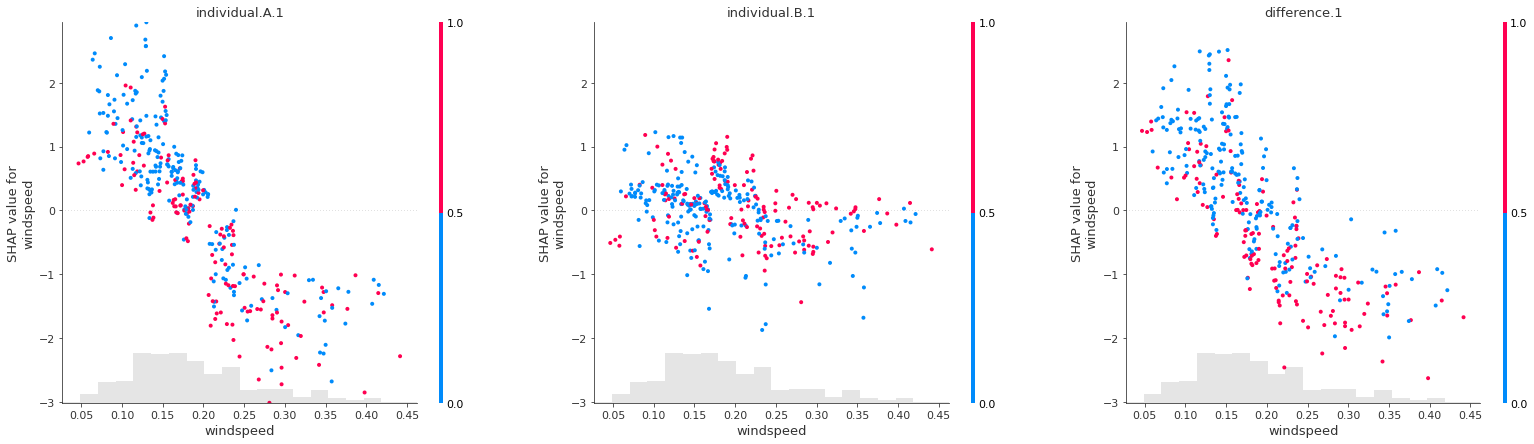

In [68]:
plot_next_feature()

`season` 1 (winter) has much bigger negative influence on model B than on A, with a broader
range of values. To instances classified differently in this group the effect is smaller,
originating from interaction effects with other features.
The other seasons have higher increasing effect to B than A.

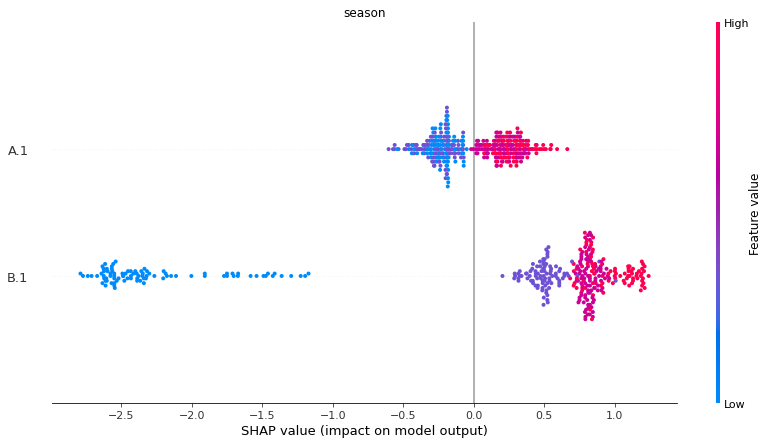

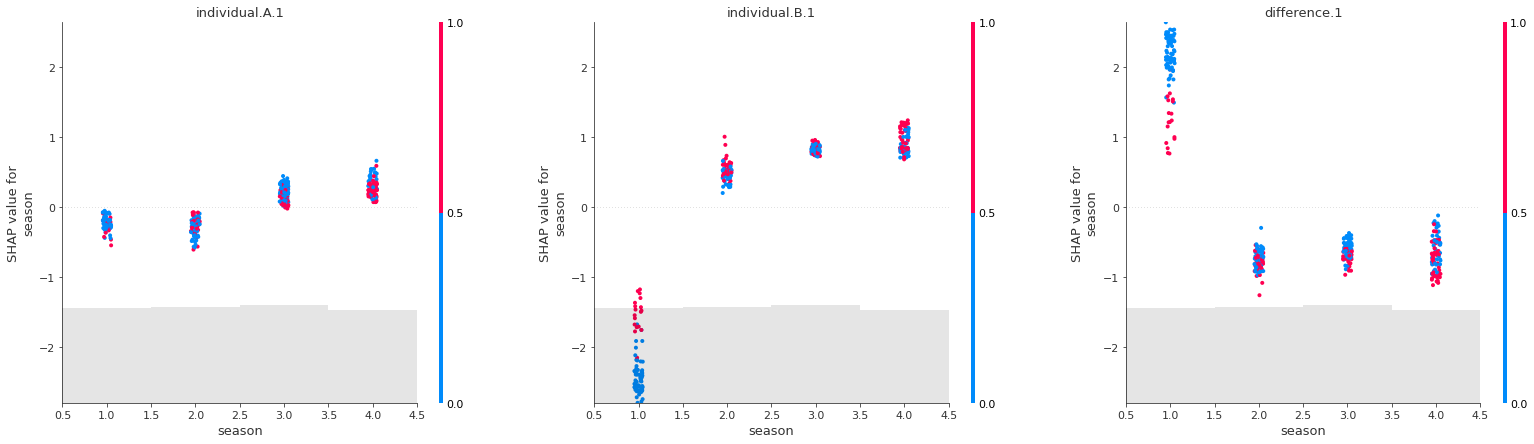

In [69]:
plot_next_feature()

Even though the influences of `weekday` on model B are small and decreasing from low (Sunday)
to high (Saturday) values,
they are the opposite of those on model A.

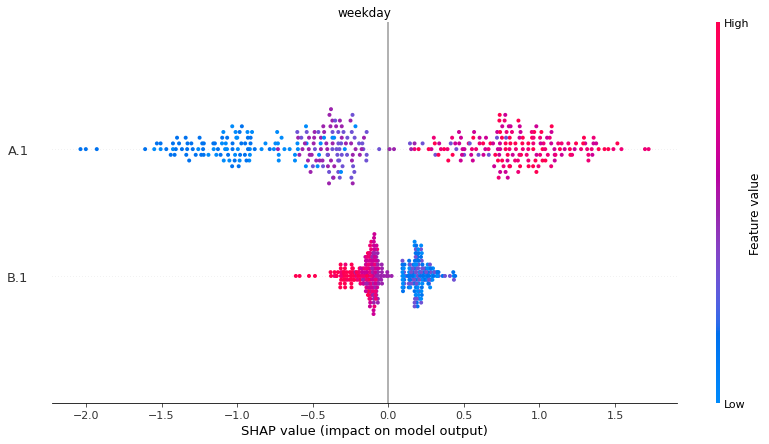

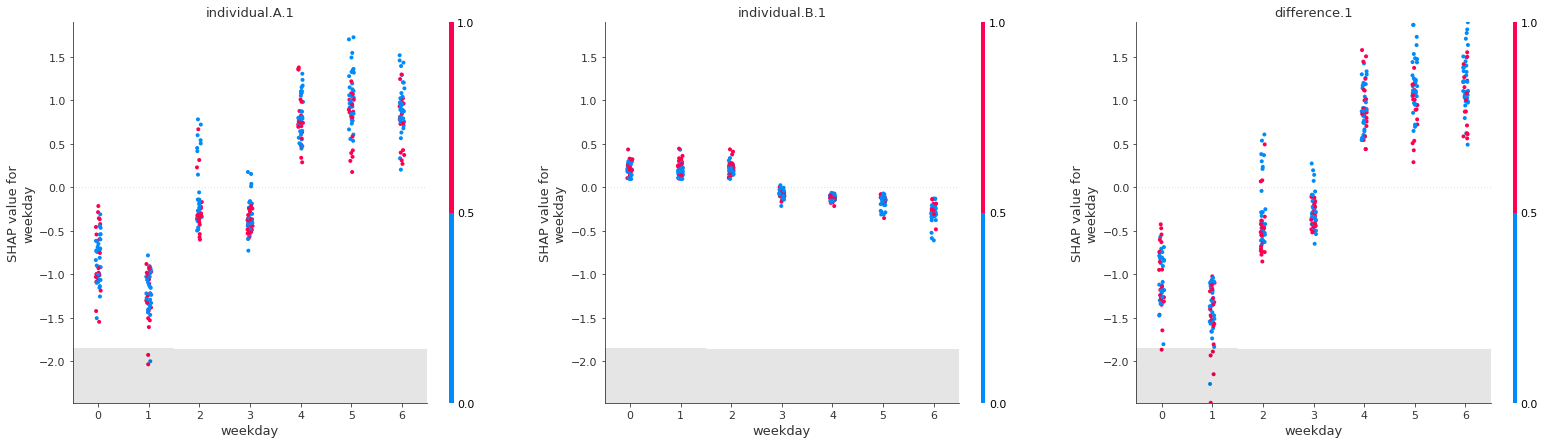

In [70]:
plot_next_feature()

For B, high values of `weathersit` (snow and rain) have bigger negative influence and low values
(clear to mist) have bigger positive influence than for A. It is possibly a better predictor
in the newer model than `windspeed` and `hum` combined.

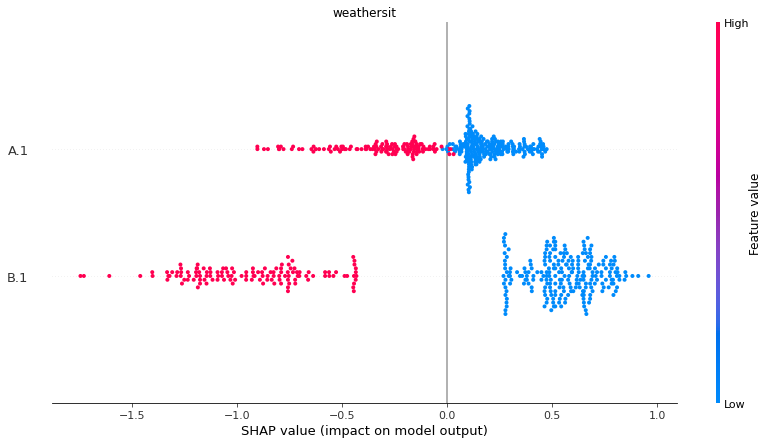

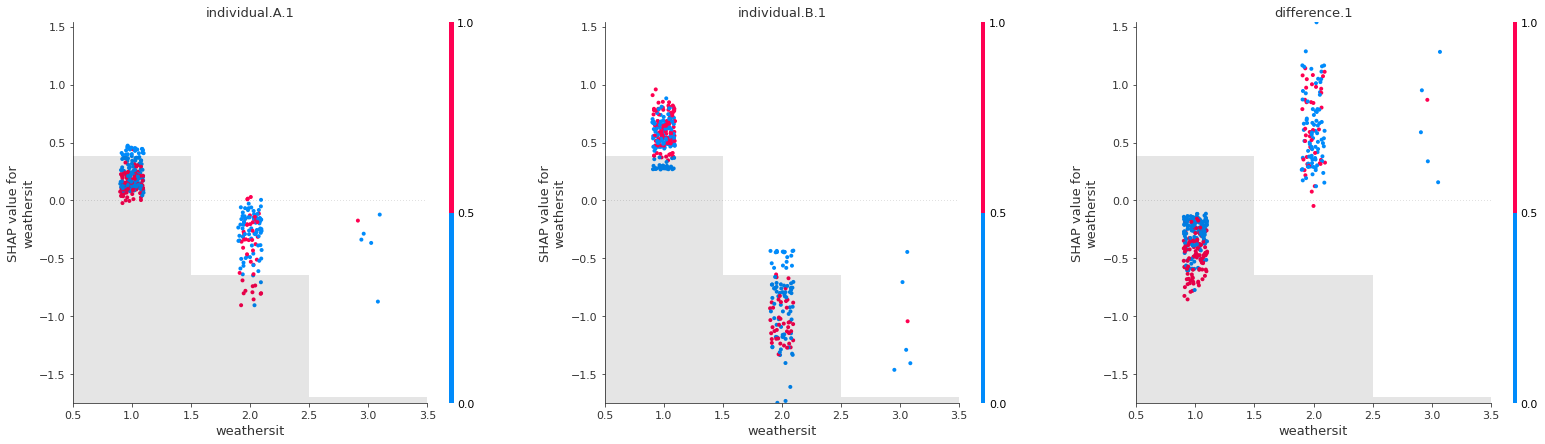

In [71]:
plot_next_feature()

`workingday` is considered more important by A, which also shows a clearer separation
of low and high values, low values (weekend or holiday) having positive influence on the outcome.
To B, it seems to be random noise with no special influence of low or high values,
and no characteristics of instances classified differently.
I assume that model A differentiates
more between work and leisure time, with more people using bicycles in their leisure time
and/or in the second half of the week, reasons not present in model B.

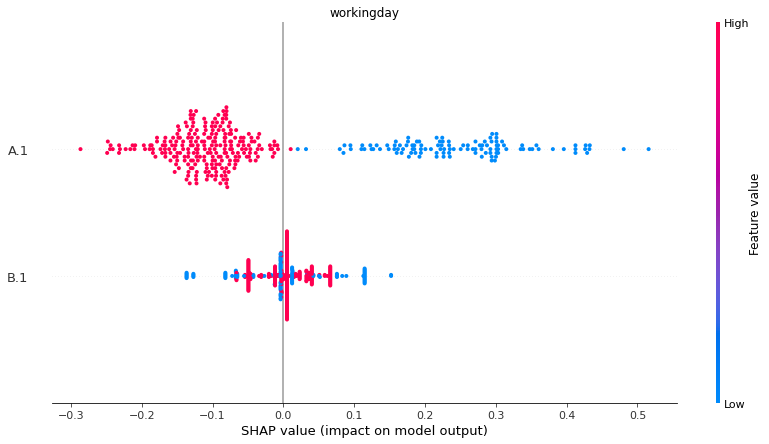

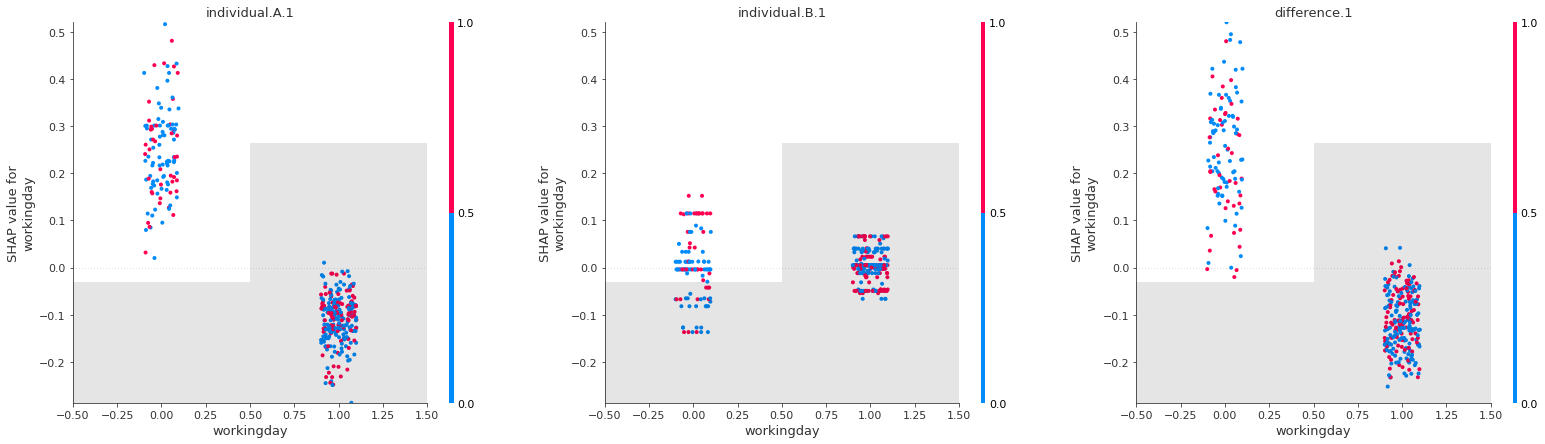

In [72]:
plot_next_feature()

## Difference classifier explanations

Considering that many instances fall into difference class $(0,1)$,
I can explain this class on a global level with SHAP value distribution plots
and feature effects plots. The same is not true for class $(1,0)$,
but there might be trends visible. This means we cannot deduct reasons for
these two instances, but get an idea what the forces towards this class are
before creating explanations on a local level.

Furthermore we see that there is
a significant drop in importance for workingday. Considering this the
knee point, I will not create explanations for the last two features in
my analysis.

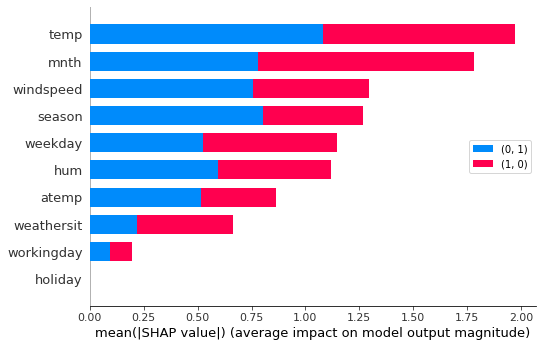

In [75]:
feature_order, feature_importance = calc_feature_order(explanations.mclass_diff.log_odds[:, :, comparer.difference_classes])
plot_feature_importance_bar(explanations.mclass_diff.log_odds[:, :, comparer.difference_classes])

In [76]:
feature_order = feature_order[:8]

Considering that there are only four classes and all have importance, I will stick to the original ordering.

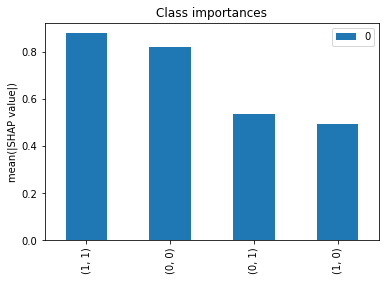

In [77]:
class_order, class_importances = calc_class_order(explanations.mclass_diff.log_odds)
plot_class_importances(class_importances, class_order, explanations.mclass_diff.output_names)

In [81]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, [feature_idx]])
    plot_feature_effects(explanations.mclass_diff.log_odds[:, [feature_idx]], color=is_pred_diff)
it = iter(feature_order)

**SHAP-value distributions:**
As is already known from the individual models' explanations,
low feature values tend towards
an increase of log odds for $(0,0)$,
high feature values for $(1,1)$. But for low feature values,
there are slightly increased log odds of $(1,0)$
and for mid-, many high and some low valued instances there
are increased log odds of $(0,1)$.

**Feature effects plots:**
Instances with low feature values ($temp<0.3$) have very high odds for class $(0,0)$
while at the same time not having instances that are classified differently.
Until 0.5, there is a drop in log odds of this class
and first an increase of $(1,0)$, then an even higher increase of $(0,1)$.
Many instances classified differently fall into this range.
Above 0.5, there is a sudden increase of $(1,1)$, which gets lower
at 0.7 while getting higher for $(0,1)$ again, also containing
many instances classified differently.

Even though this is the feature of highest importance for the differences,
its explanation does not cover all instances. Especially for those with
$0.5<temp<0.7$, this feature cannot be the reason for them being classified
differently.

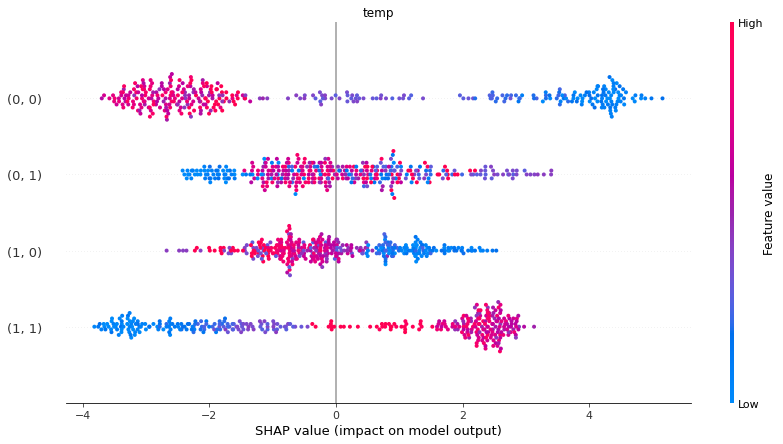

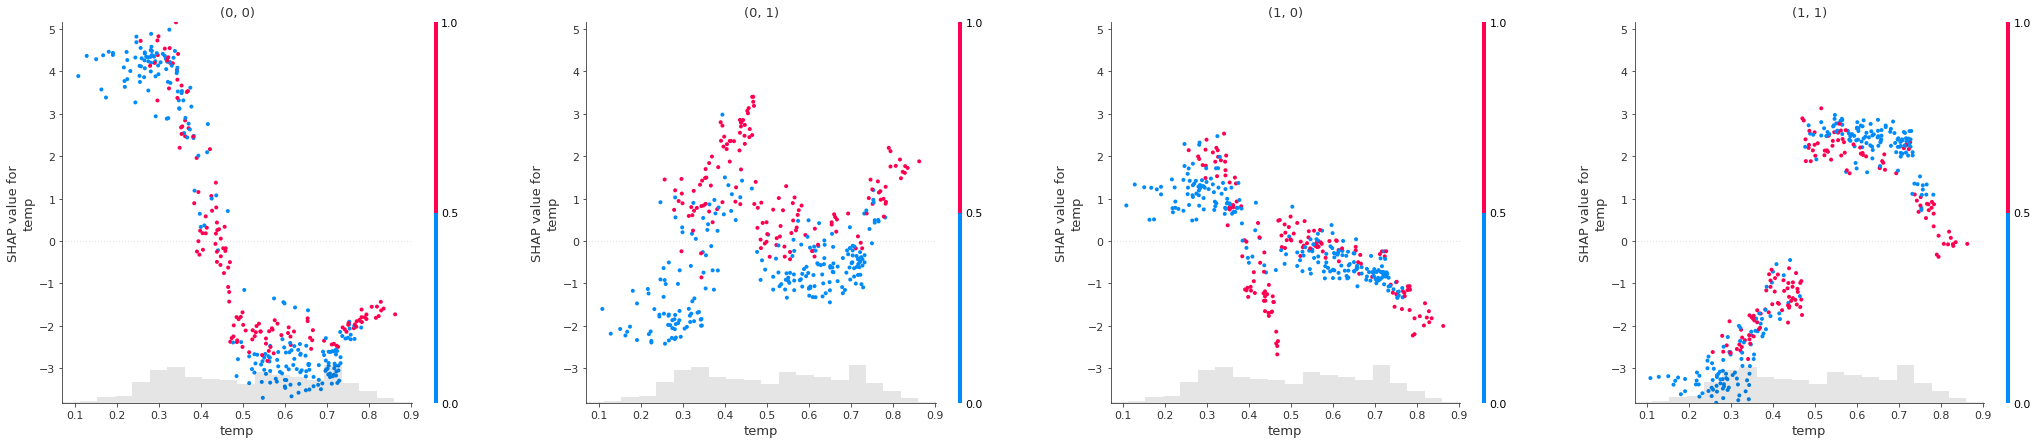

In [82]:
plot_next_feature()

Instances with low month values have increased odds for class $(0,0)$ and even higher for difference class $(0,1)$. Those with high values have increased odds for classes $(1,1)$ and $(1,0)$.

Months 3 and 4 have increased odds for $(0,1)$.

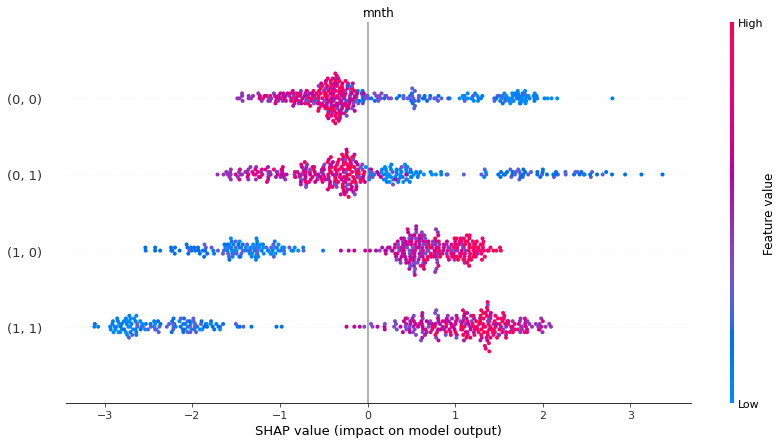

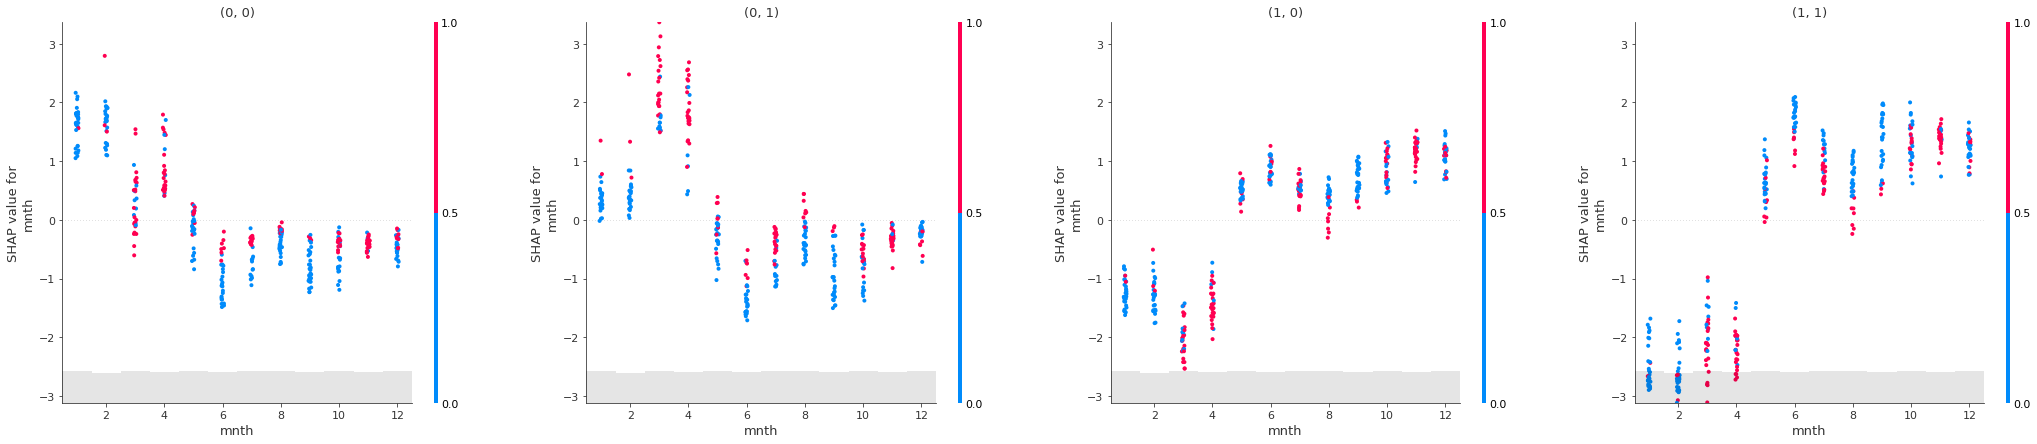

In [83]:
plot_next_feature()

High windspeed values tend to increase odds for $(0,0)$ and $(0,1)$, low values for $(1,1)$ and $(1,0)$.

The higher the windspeed, the higher the odds for difference class $(0,1)$.

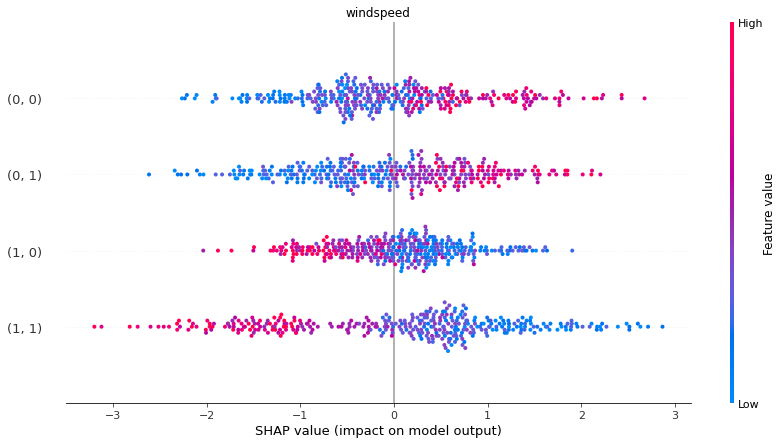

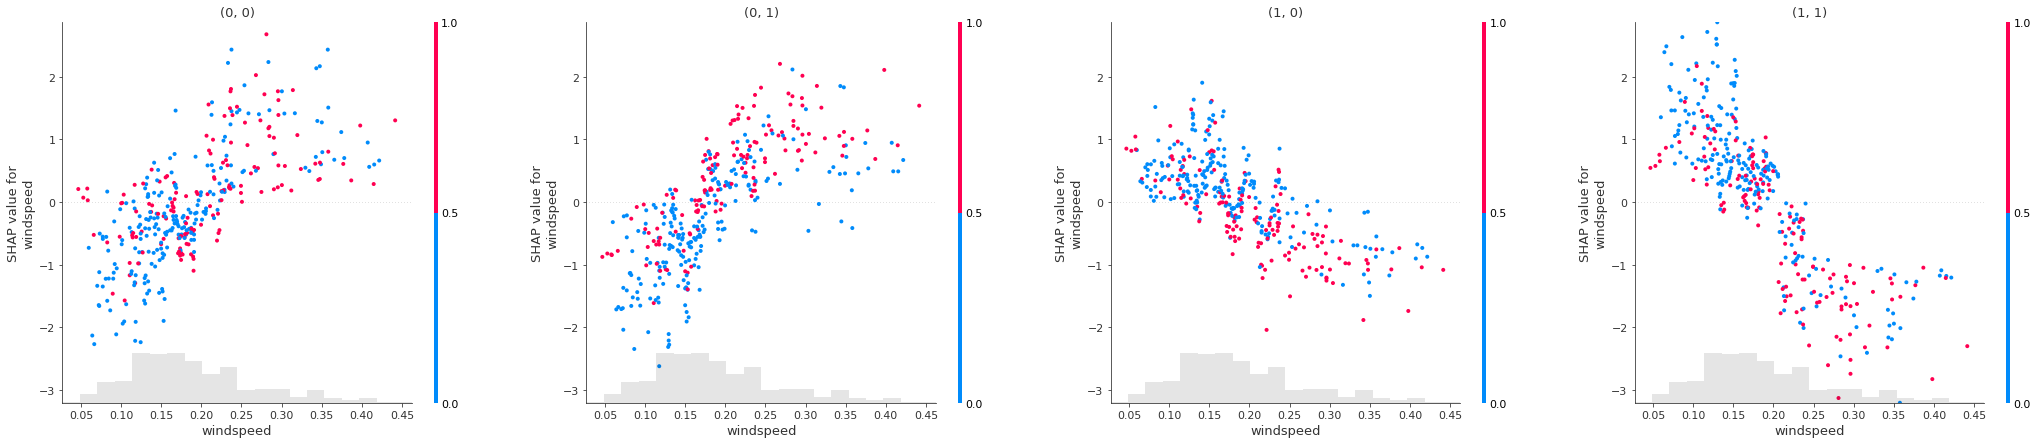

In [84]:
plot_next_feature()

Instances with low season values (spring) have increased odds for $(0,0)$, and to a lower extent for difference class $(1,0)$. Instances of winter, autumn and summer have increased odds for $(1,1)$ and $(0,1)$.

Even for instances of spring, where both classifiers have increased odds for low bike sharing count, there are instances classified differently.

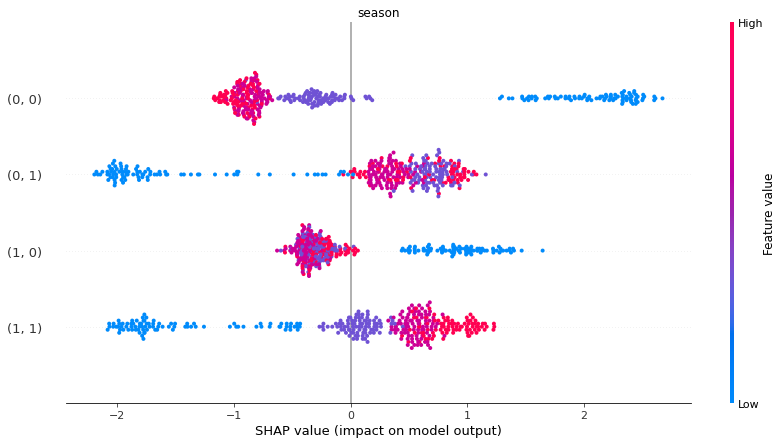

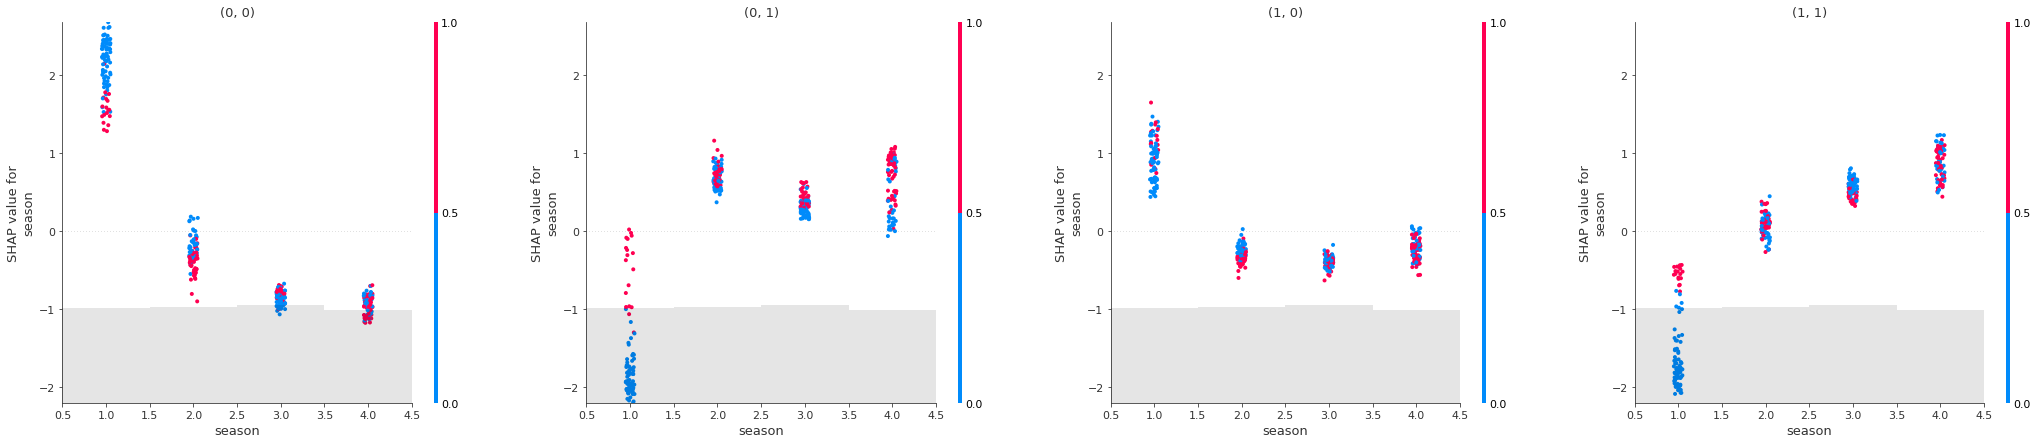

In [85]:
plot_next_feature()

Instances with high weekday values (Saturday, Friday, etc.) have increased odds for $(1,1)$ and $(1,0)$. This means that odds are increased for A predicting high and B low bike rentals. Instances with low feature values (Sunday, Monday, etc.) have increased odds for $(0,1)$ and to a lower extent for $(0,0)$.

Instances of Sunday and Monday have increased odds for $(0,1)$, while those of Friday, Saturday and Sunday have increased odds for $(1,0)$ (along with $(1,1)$)

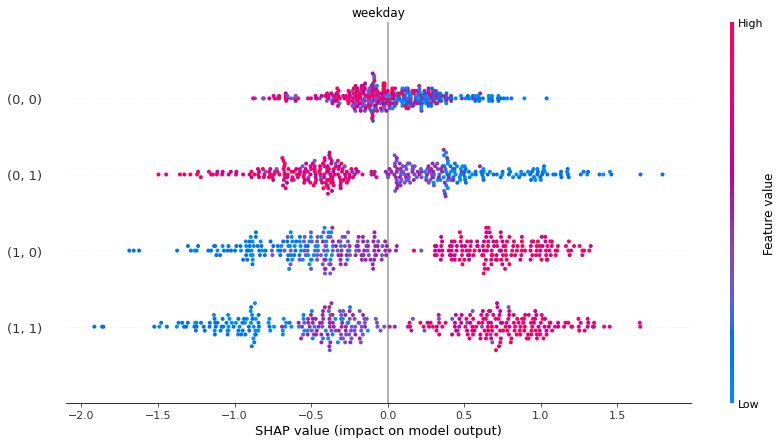

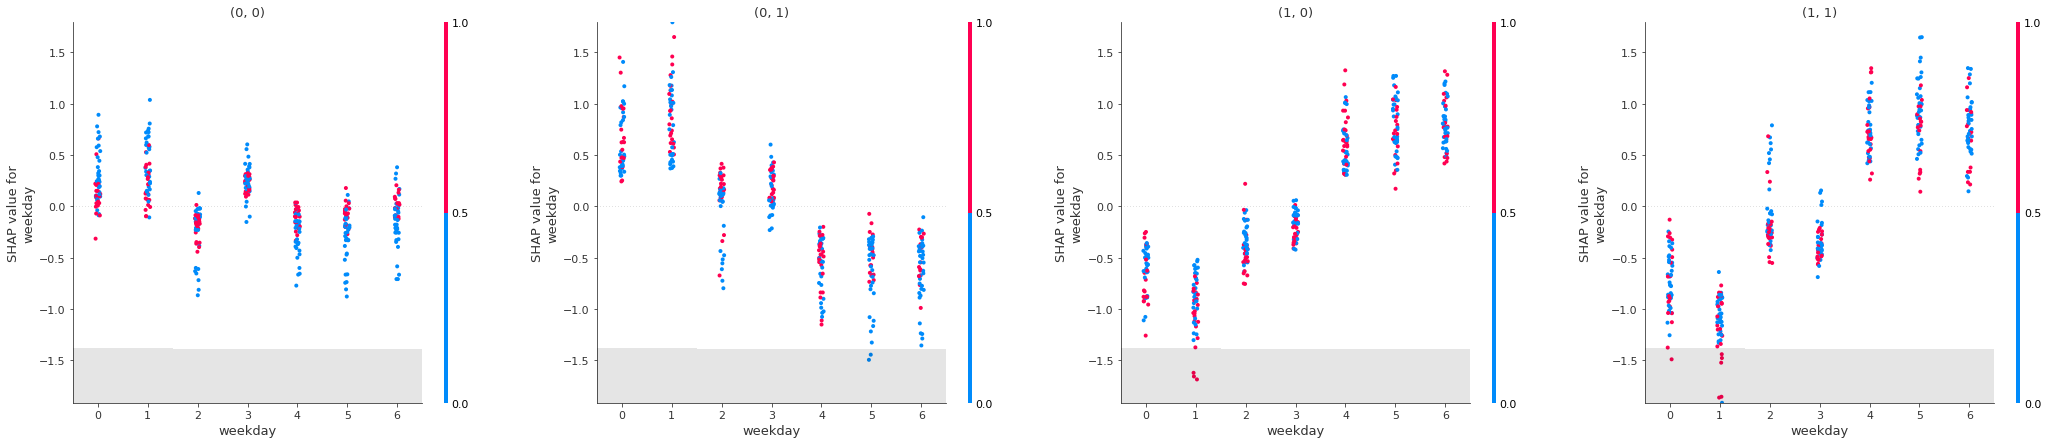

In [86]:
plot_next_feature()

Instances with high or low humidity values have increased odds for the equality classes. But the picture is not clear for the difference classes. Those with high values tend to have increased odds for $(0,1)$, but with differing instances. Thos with low values tend to have increased odds for $(1,0)$.

For humidity, there is a general trend from low values, that mean low bike rentals to high values, which means high bike rentals. Around 0.7 there are increased odds for $(0,1)$.

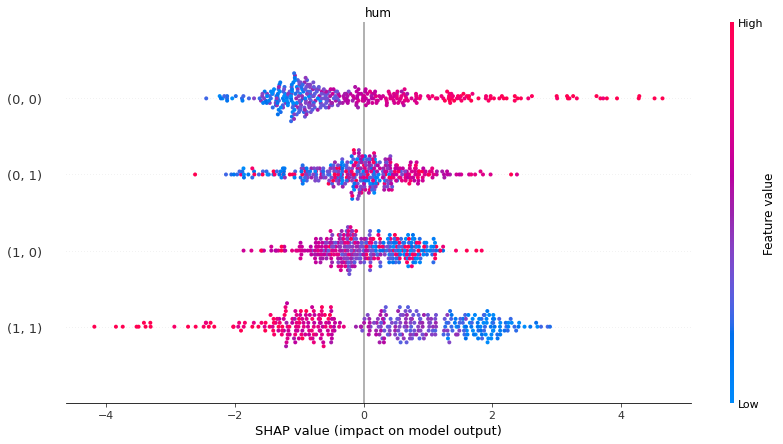

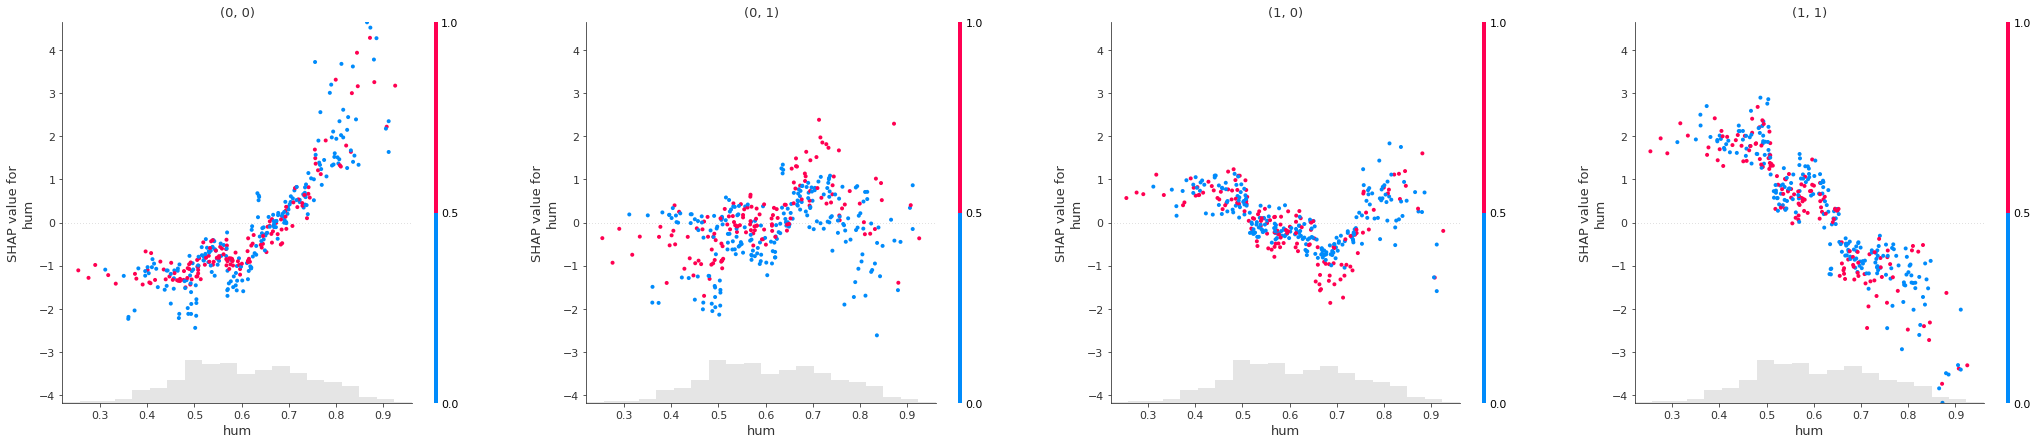

In [87]:
plot_next_feature()

Some instances with high felt temperature values have increased odds for $(0,1)$, and to a lower extent for $(1,1)$.

Here we can clearly see a group of instances above felt temperature approx. 0.7, that have increased odds for class $(0,1)$ and are actually classified differently.

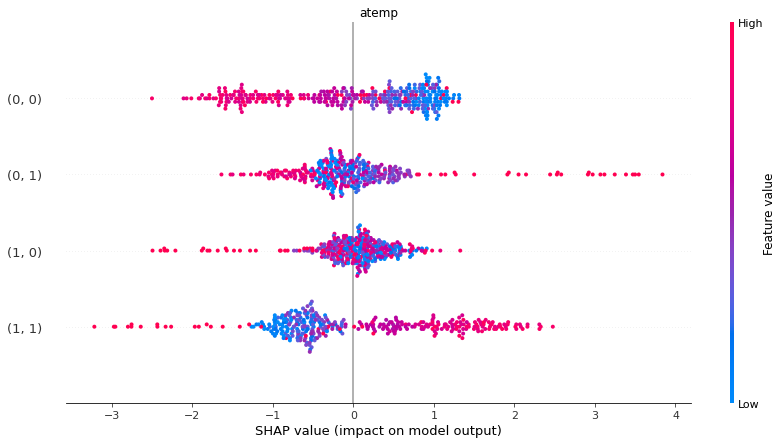

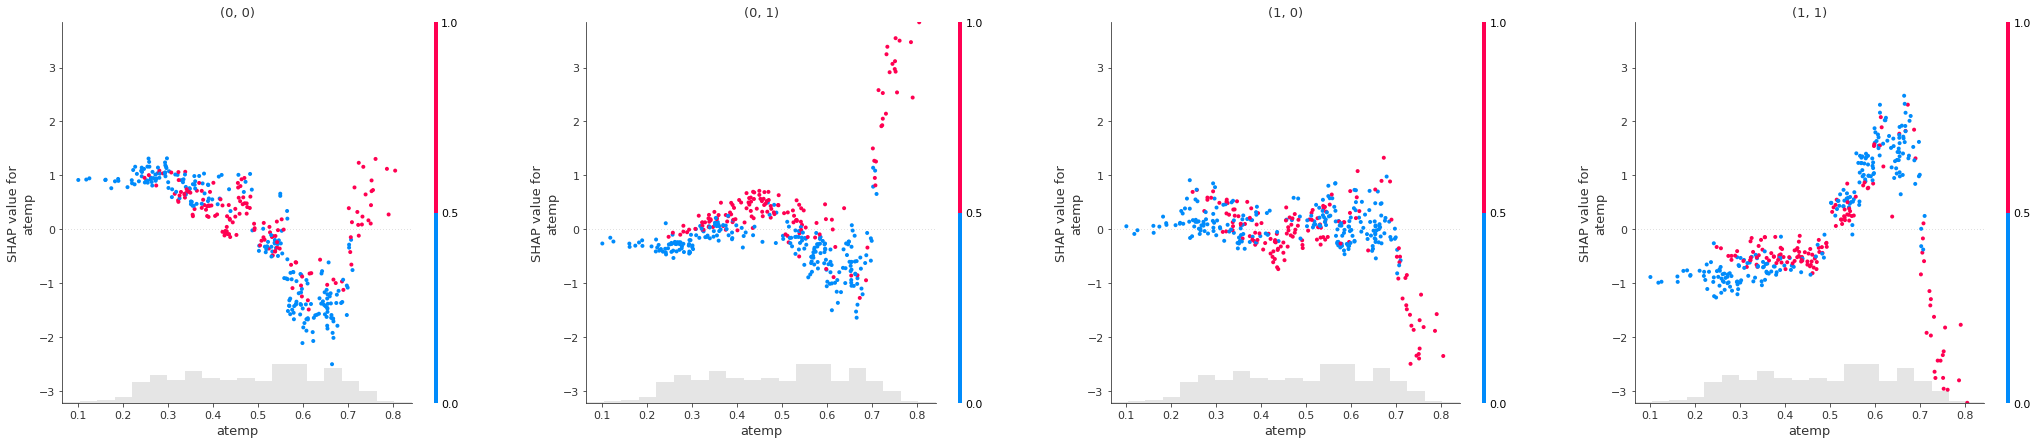

In [88]:
plot_next_feature()

Instances with bad weather situation have increased odds for $(0,0)$ and $(1,0)$.

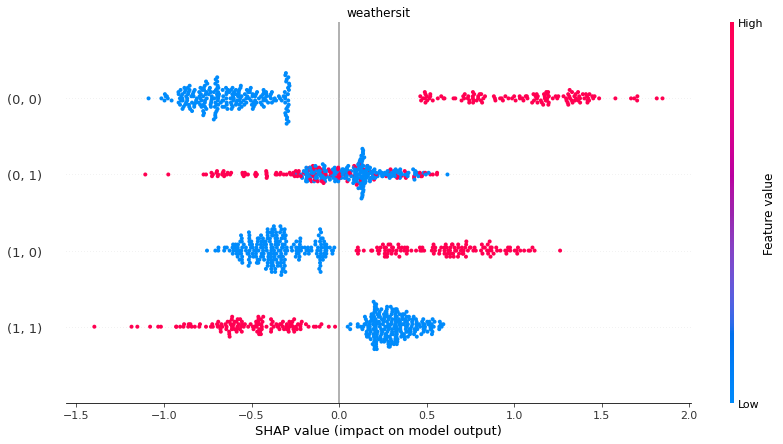

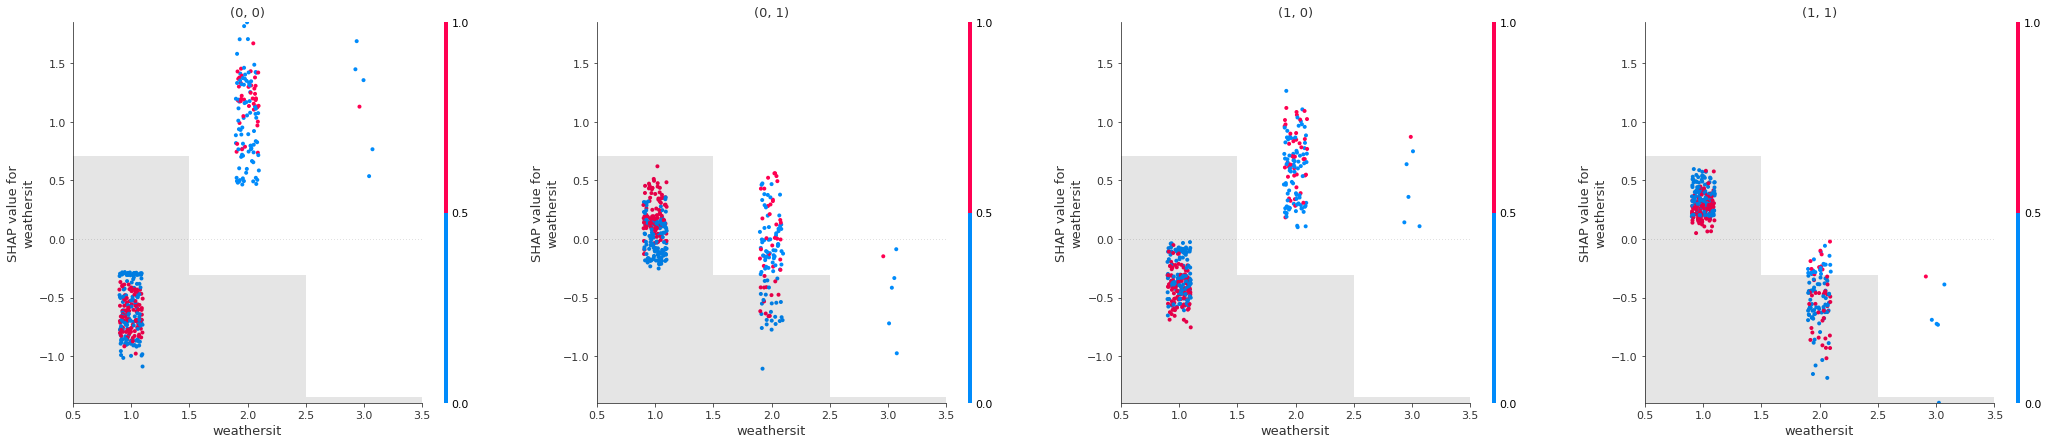

In [89]:
plot_next_feature()

# Local Explanations

Now I could try to interpret the SHAP values of each instance, that
is classified differently. But for a bigger number of instances this approach
is too costly. Therefore I will try to interpret subsets of instances,
by first splitting the entire instance space using
a hierarchical clustering approach which takes into account only the
explanations themselves, the SHAP values. This way, homogeneity is maximized
within the subsets to simplify local interpretations.

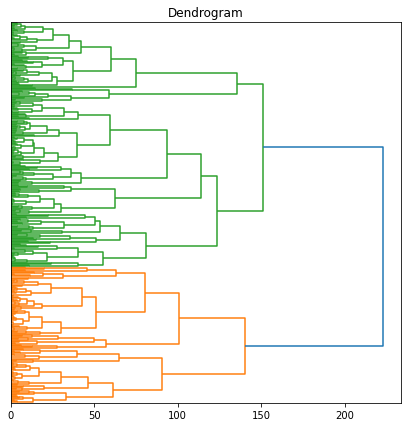

In [4]:
linkage_matrix = perform_hierarchical_clustering(explanations.mclass_diff.log_odds)
plot_dendrogram(linkage_matrix)

Guessing from the plot above, a reasonable cluster number could be 5. It yields a clustering, where every cluster contains instances classified differntly by the two classifiers. Cluster one is more diverse, having instances of all four classes. The other clusters are more homogenous, each containing instances of one difference class and one equality class.

In [5]:
clustering, cluster_names = extract_clustering(linkage_matrix, n_clusters=5)
explanations_clustered = explanations.cohorts(cluster_names[clustering])
occurences, clusters_of_interest = get_class_occurences_in_clusters(explanations_clustered, cluster_names, comparer)
occurences

(0, 0)  (0, 1)  (1, 0)  (1, 1)
c1      18      31       2       1
c2      75       4       0       0
c3       0      95       0      64
c4       8       5       0       0
c5       0       7       0      56

Generating fewer clusters merges the last two, leading to it having instances of three classes. This is not an option.

In [6]:
clustering_, cluster_names_ = extract_clustering(linkage_matrix, n_clusters=4)
explanations_clustered_ = explanations.cohorts(cluster_names_[clustering_])
occurences_, clusters_of_interest_ = get_class_occurences_in_clusters(explanations_clustered_, cluster_names_, comparer)
occurences_

(0, 0)  (0, 1)  (1, 0)  (1, 1)
c1      18      31       2       1
c2      75       4       0       0
c3       0      95       0      64
c4       8      12       0      56

Increasing the number of clusters splits cluster 3. This could be an option if I later find out that the cluster is very heterogenous.

In [7]:
clustering_, cluster_names_ = extract_clustering(linkage_matrix, n_clusters=6)
explanations_clustered_ = explanations.cohorts(cluster_names_[clustering_])
occurences_, clusters_of_interest_ = get_class_occurences_in_clusters(explanations_clustered_, cluster_names_, comparer)
occurences_

(0, 0)  (0, 1)  (1, 0)  (1, 1)
c1      18      31       2       1
c2      75       4       0       0
c3       0      48       0       3
c4       0      47       0      61
c5       8       5       0       0
c6       0       7       0      56

In [8]:
clustering_, cluster_names_ = extract_clustering(linkage_matrix, n_clusters=7)
explanations_clustered_ = explanations.cohorts(cluster_names_[clustering_])
occurences_, clusters_of_interest_ = get_class_occurences_in_clusters(explanations_clustered_, cluster_names_, comparer)
occurences_

(0, 0)  (0, 1)  (1, 0)  (1, 1)
c1      18      31       2       1
c2      75       4       0       0
c3       0      48       0       3
c4       0      28       0       0
c5       0      19       0      61
c6       8       5       0       0
c7       0       7       0      56

In [48]:
def get_next_cluster():
    cluster = next(cluster_it)
    shap_values = explanations_clustered.mclass_diff.log_odds.cohorts[cluster]
    pred_classes = comparer.predict_mclass_diff(shap_values.data)
    pred_class_names = comparer.class_names[pred_classes]
    diff_classes = comparer.difference_class_names[occurences.loc[cluster, comparer.difference_class_names] > 0]
    display(occurences.loc[[cluster], :])
    return cluster, shap_values, pred_class_names, diff_classes
cluster_it = iter(clusters_of_interest)

diro2c works with integers only, so I need to scale some features:

In [49]:
scale_features = {'temp': 100, 'windspeed': 100, 'hum': 100, 'atemp': 100}

## 1st Cluster

Next, I analyze the SHAP value distribution and effects of each feature. To summarize, I need to explain each difference class separately:

The instances in this cluster are mostly of `season` fall (months 10-12), `temp` and `atemp` are in the range of mid to lower-mid half values.
- For instances classified $(0,1)$
  - odds would be decreased for the difference class and/or increased for class $(0,0)$:
      - if `temp` was lower
      - if `hum` was higher
      - if `atemp` was lower
  - odds would be decreased for the difference class and/or increased for class $(1,1)$:
      - if `hum` was lower
- For instances classified $(1,0)$
  - odds would be decreased for the difference class and/or increased for class $(0,0)$
    - if `temp` was lower
    - if `windspeed` was higher
    - if `weekday` was lower
    - if `hum` was higher
  - odds would be decreased for the difference class and/or increased for class $(1,1)$
    - if `temp` was higher
    - if `windspeed` was lower
    - if `weathersit` was 1 instead of 2
    - if `hum` was lower
    - if `atemp` was higher

In [50]:
cluster, shap_values, pred_classes, diff_classes = get_next_cluster()

(0, 0)  (0, 1)  (1, 0)  (1, 1)
c1      18      31       2       1

### SHAP-based Difference Classifier Explanations

This cluster contains the two instances classified as $(1,0)$, 31 instances classified as $(0,1)$ and further instances of the equality classes.

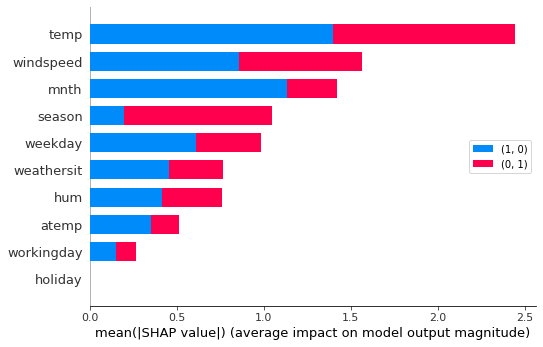

In [51]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, comparer.difference_classes])
plot_feature_importance_bar(shap_values[:, :, comparer.difference_classes])

The rule of thumb here is, that all features are included in subsequent analysis, that are above the knee point of the importance curve.

Here I include all but the last feature.

In [178]:
feature_order = feature_order[:-1]

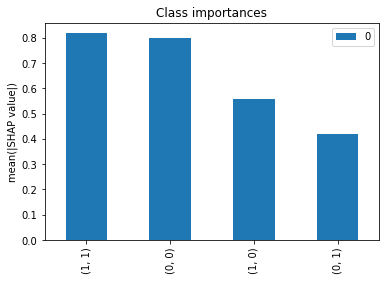

In [179]:
class_order, class_importances = calc_class_order(shap_values)
plot_class_importances(class_importances, class_order, shap_values.output_names)

All classes are represented in the importances plot. In this cluster, class $(1,0)$ is of higher importance than on the global level.

In [15]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(shap_values[:, [feature_idx]])
    for diff_class in diff_classes:
        plot_feature_effects(shap_values[:, [feature_idx]], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}')
it = iter(feature_order)

In contrast to the global feature effects plots for temperature, these feature effects plots show more pronounced linear trends. If the temperature was lower, the odds would be higher for $(0,0)$ than for $(0,1)$.

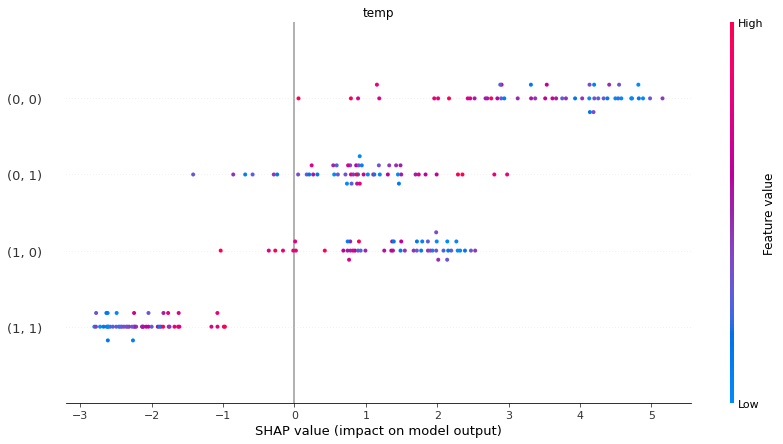

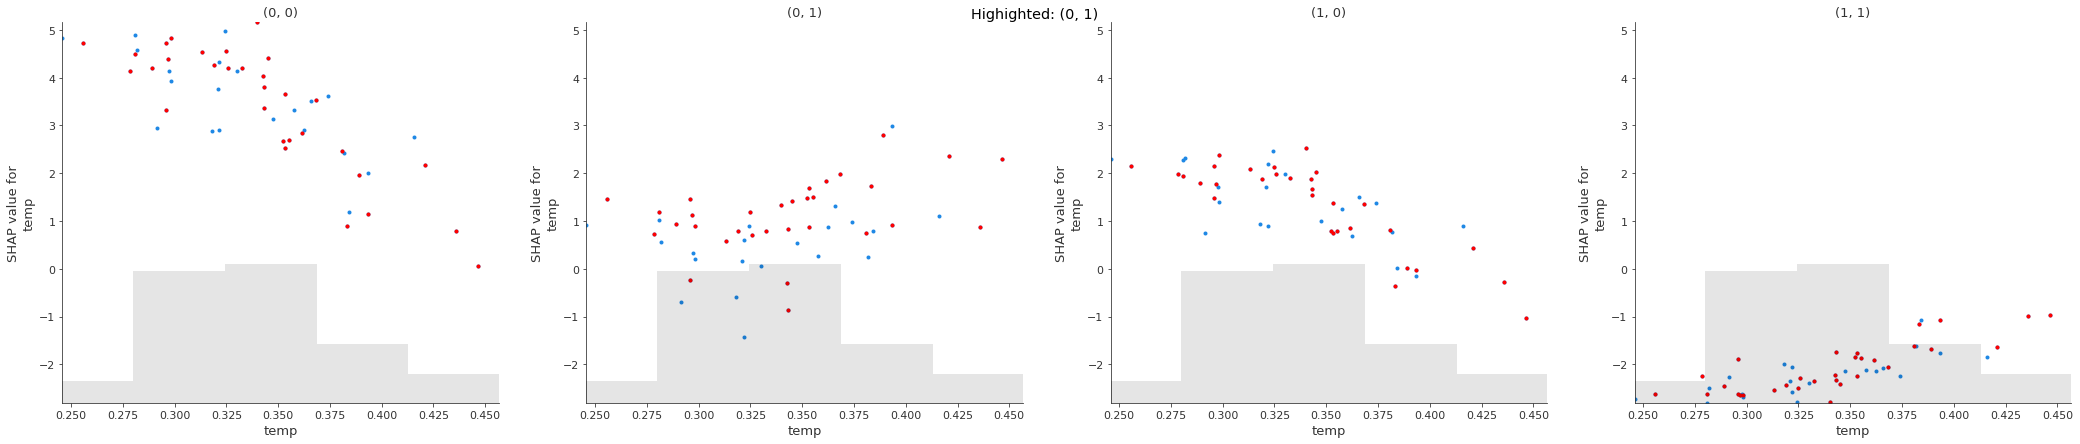

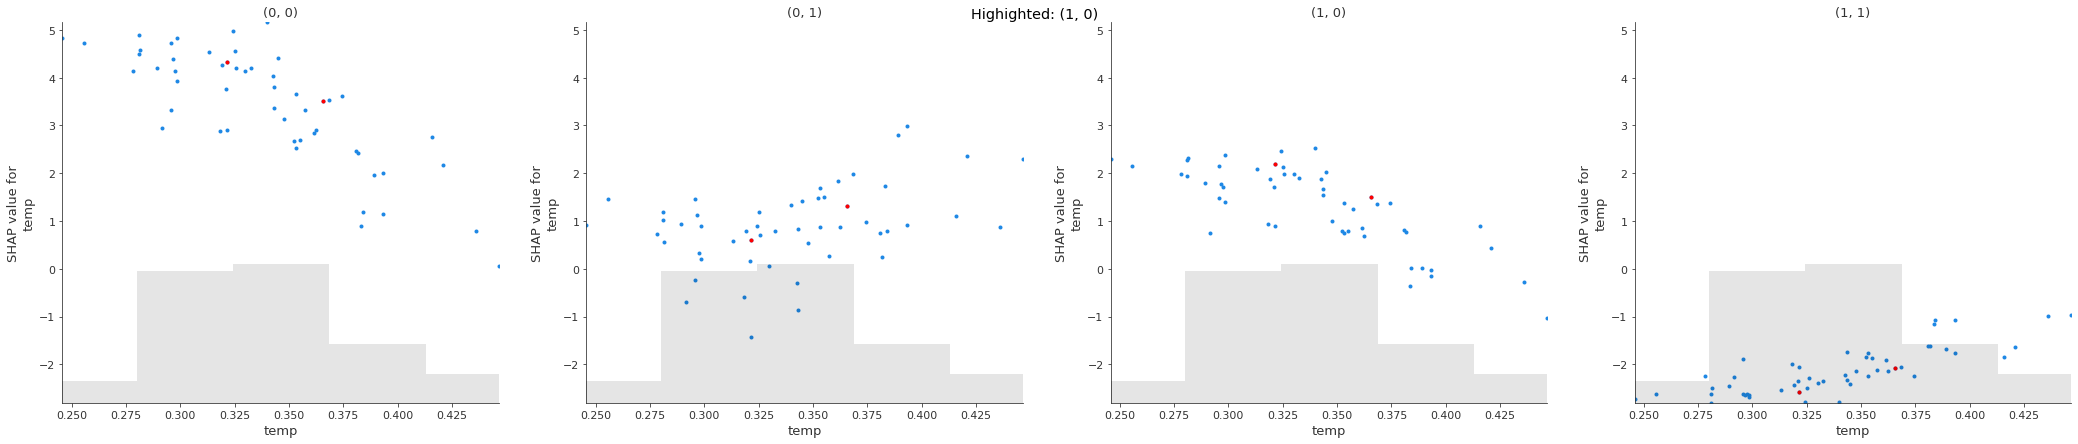

In [16]:
plot_next_feature()

The distribution and effects of windspeed look very similar to the global plots.

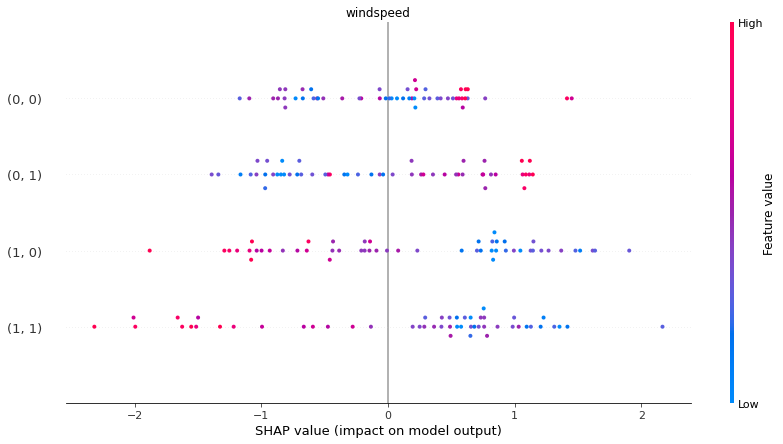

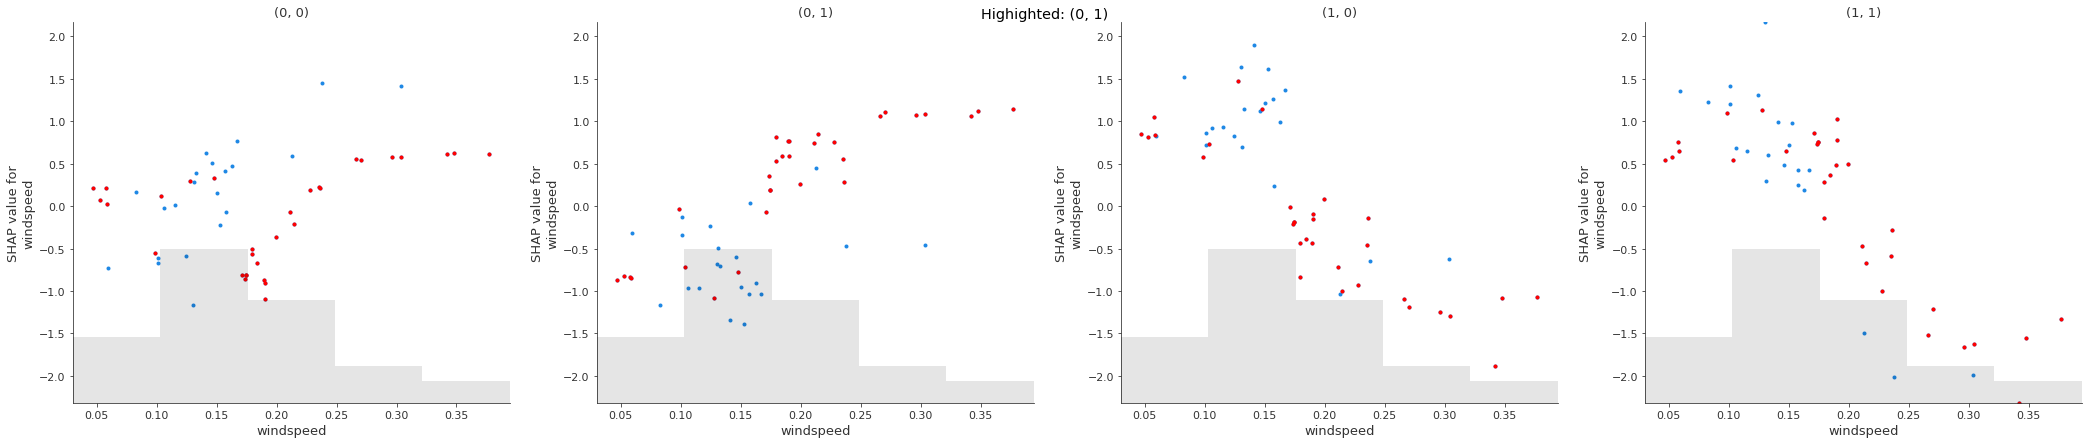

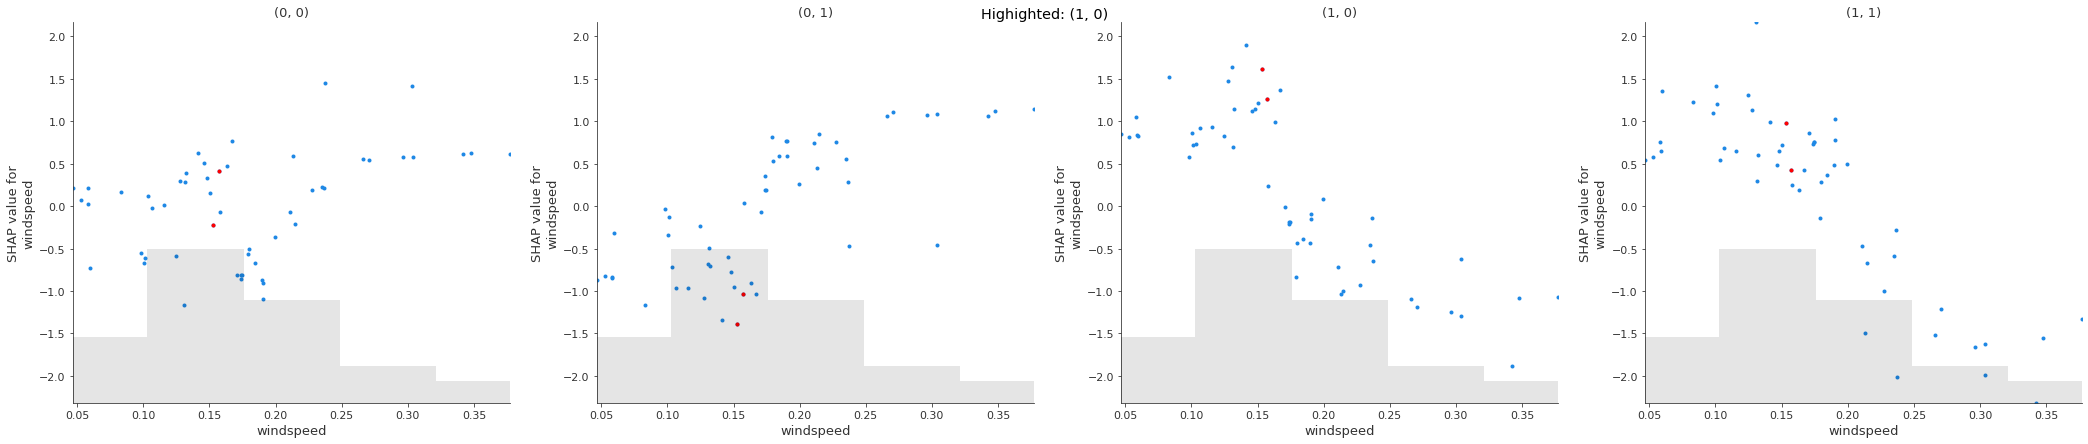

In [17]:
plot_next_feature()

The instances cover only a narrow range of month values. By comparing the trends to the global effects, we can expect the odds for the two instances classified as $(1,0)$ to decrease and at the same time increase for both $(0,0)$ and $(0,1)$.

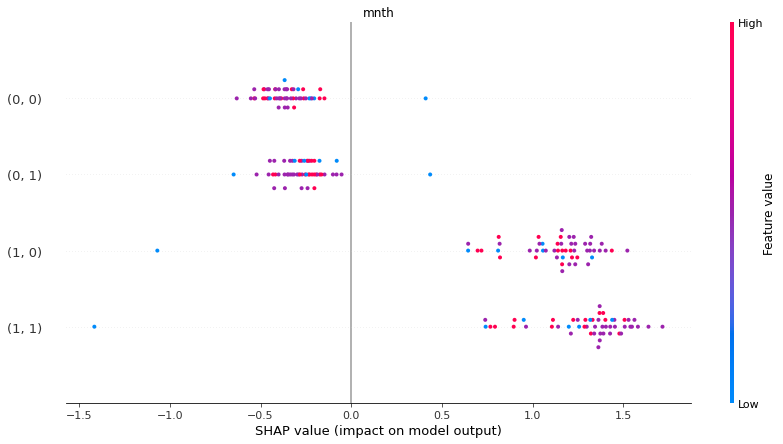

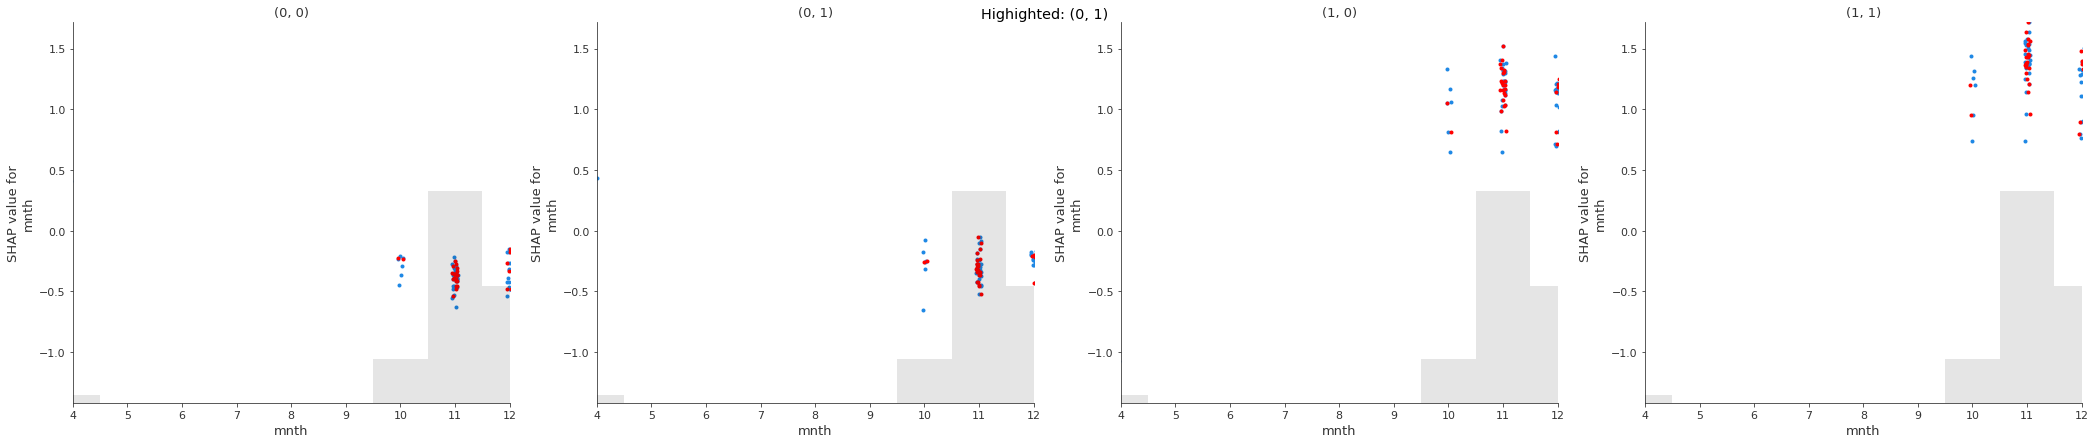

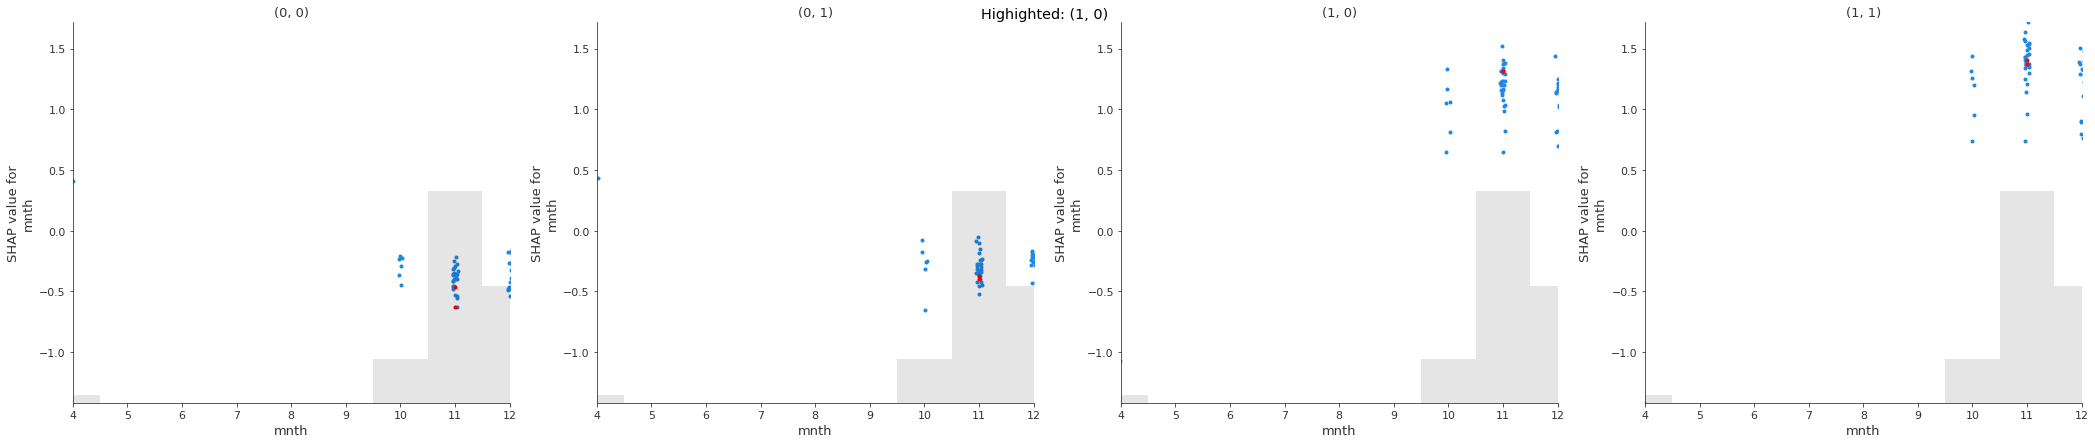

In [18]:
plot_next_feature()

Most of the instances in the cluster are from season winter. From the global effects we know, that if season was spring, the odds for $(0,0)$ would increase heavily, at the same time decreasing the odds for $(0,1)$ and only slightly increasing the odds for $(1,0)$.

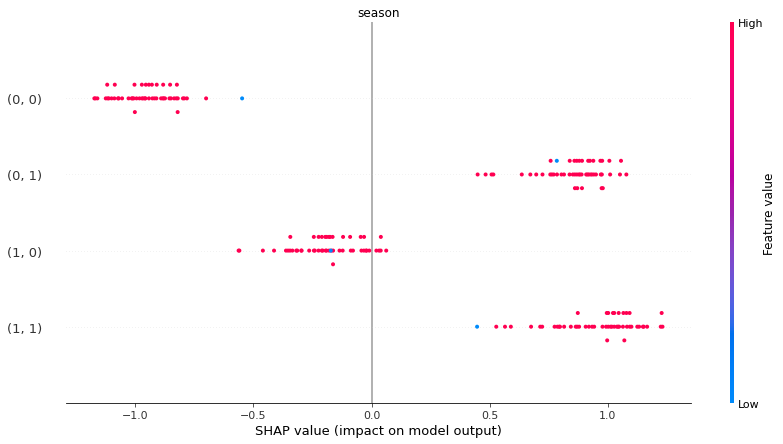

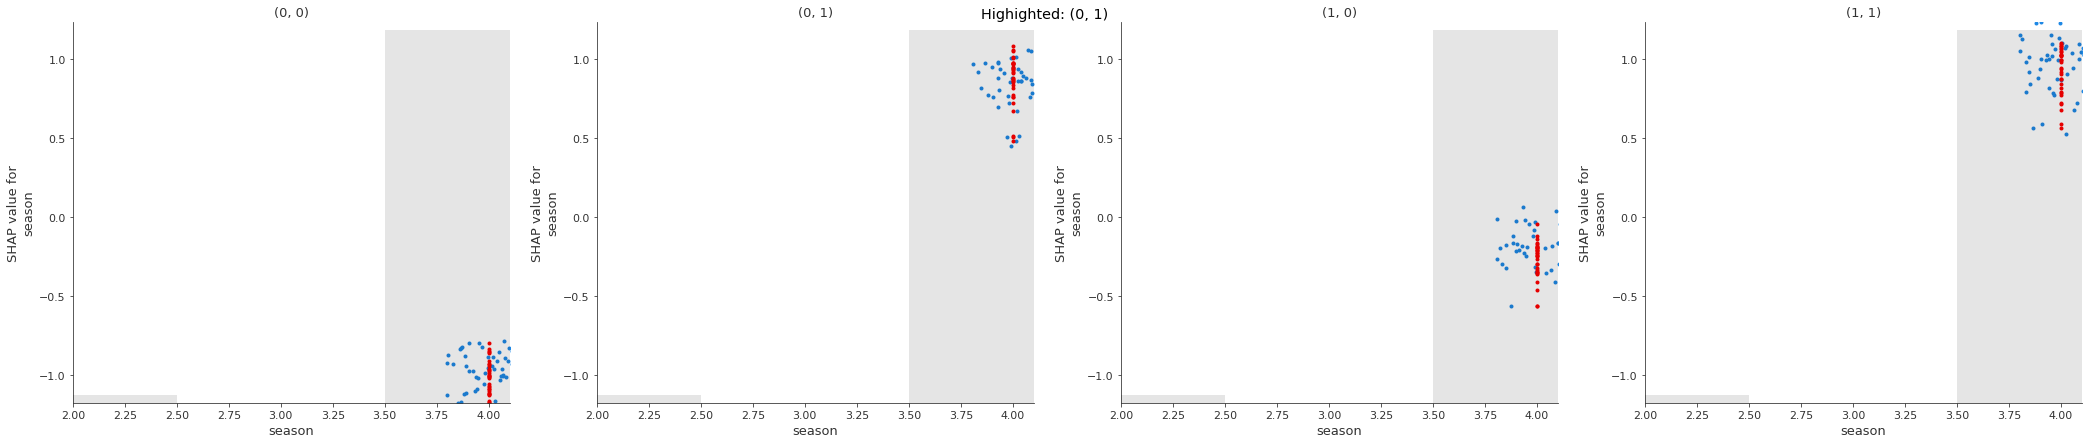

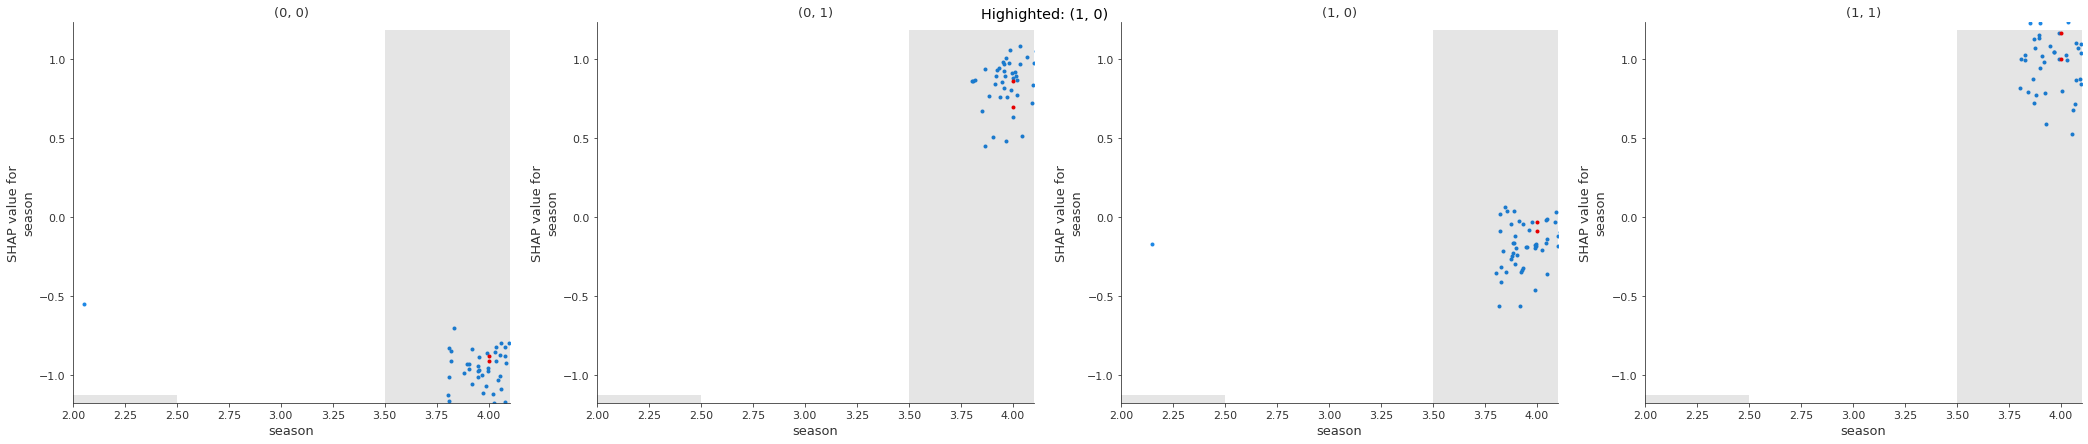

In [19]:
plot_next_feature()

The distribution and effects of the SHAP values for weekday look very much like on the global level. Because both instances classified as $(1,0)$ have weekday Thursday, we can expect the odds to go down for $(1,0)$ and up for $(0,0)$ and $(0,1)$ when decreasing their feature values.

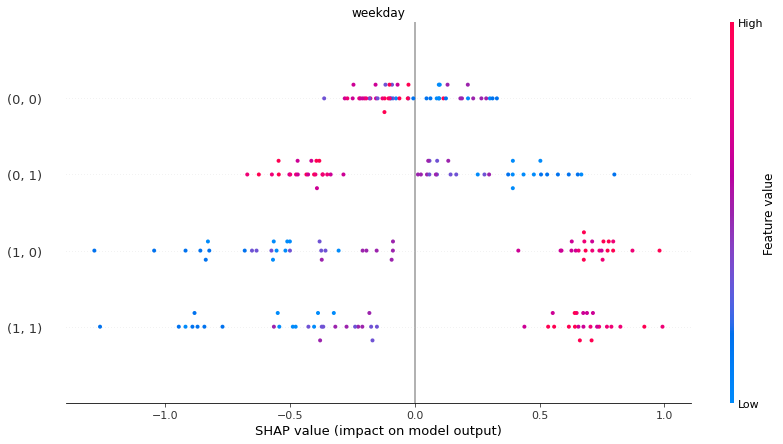

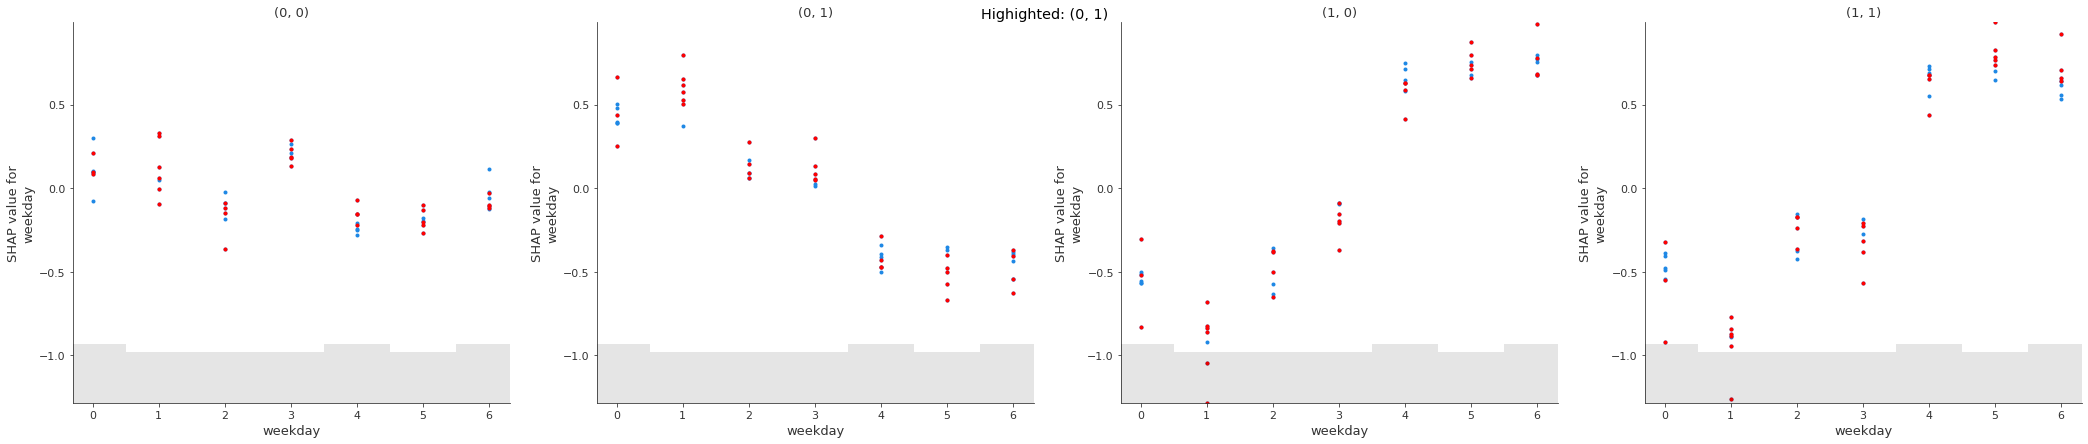

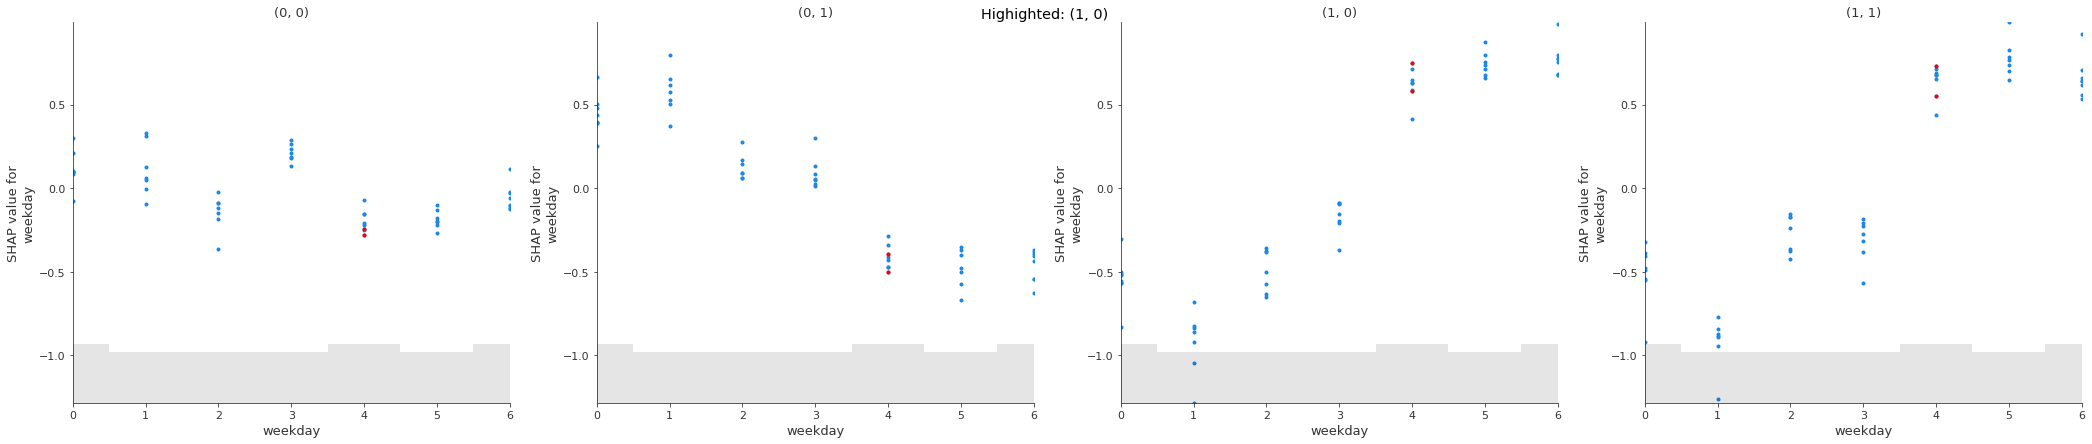

In [20]:
plot_next_feature()

Of weathersit, only values 1 and 2 are present in the cluster. For instances classified $(1,0)$, we can expect the odds decrease for $(1,0)$ and increase for $(1,1)$ if the feature's value was decreased to 1. Using global explanations, we can expect instances classified $(0,1)$ to decrease the odds for $(0,1)$ and increase the odds for $(0,0)$ and $(1,0)$ if the feature's value was increased.

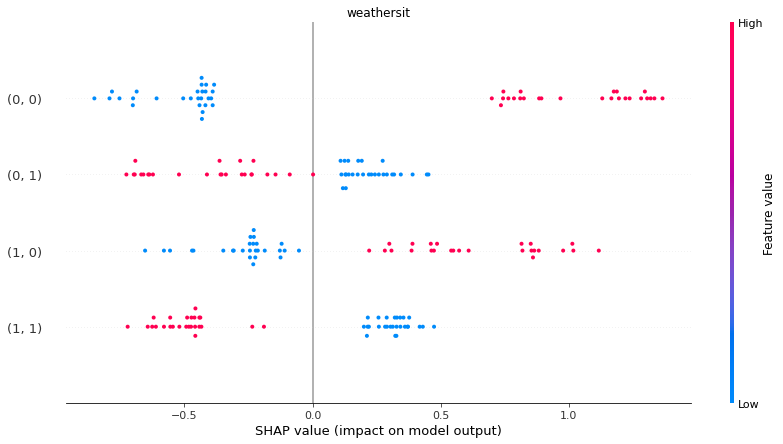

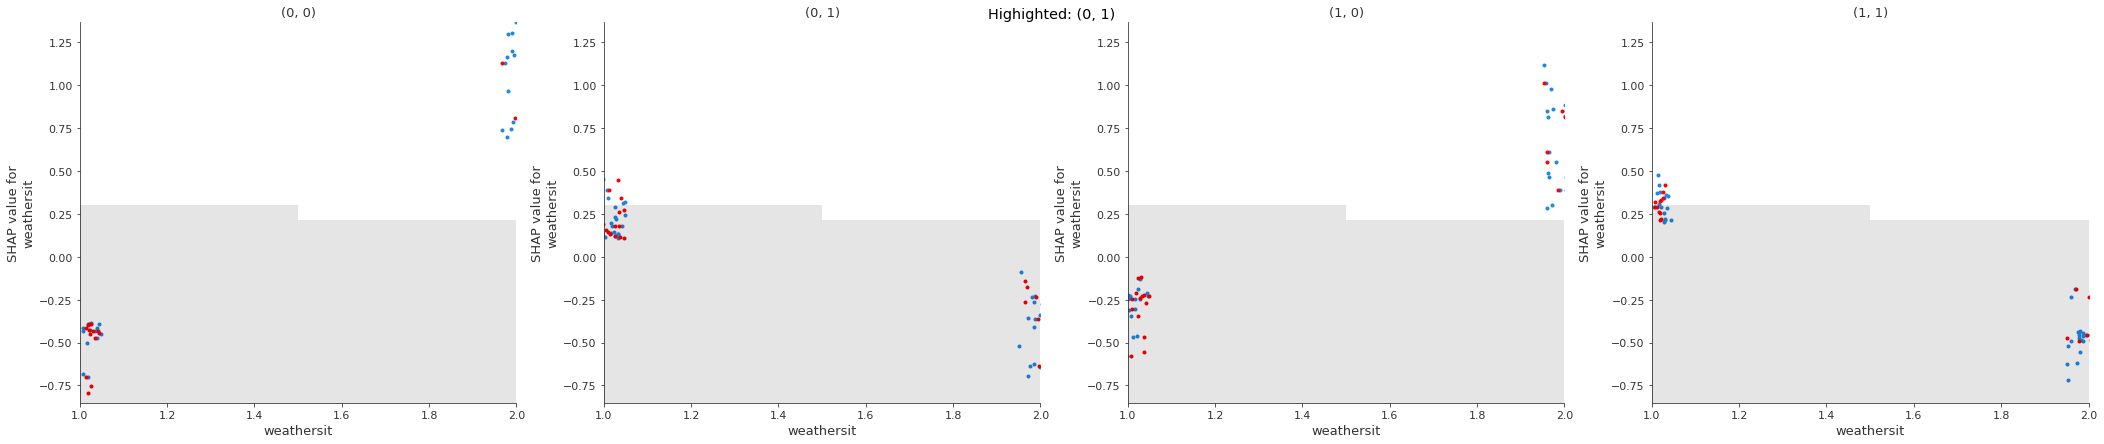

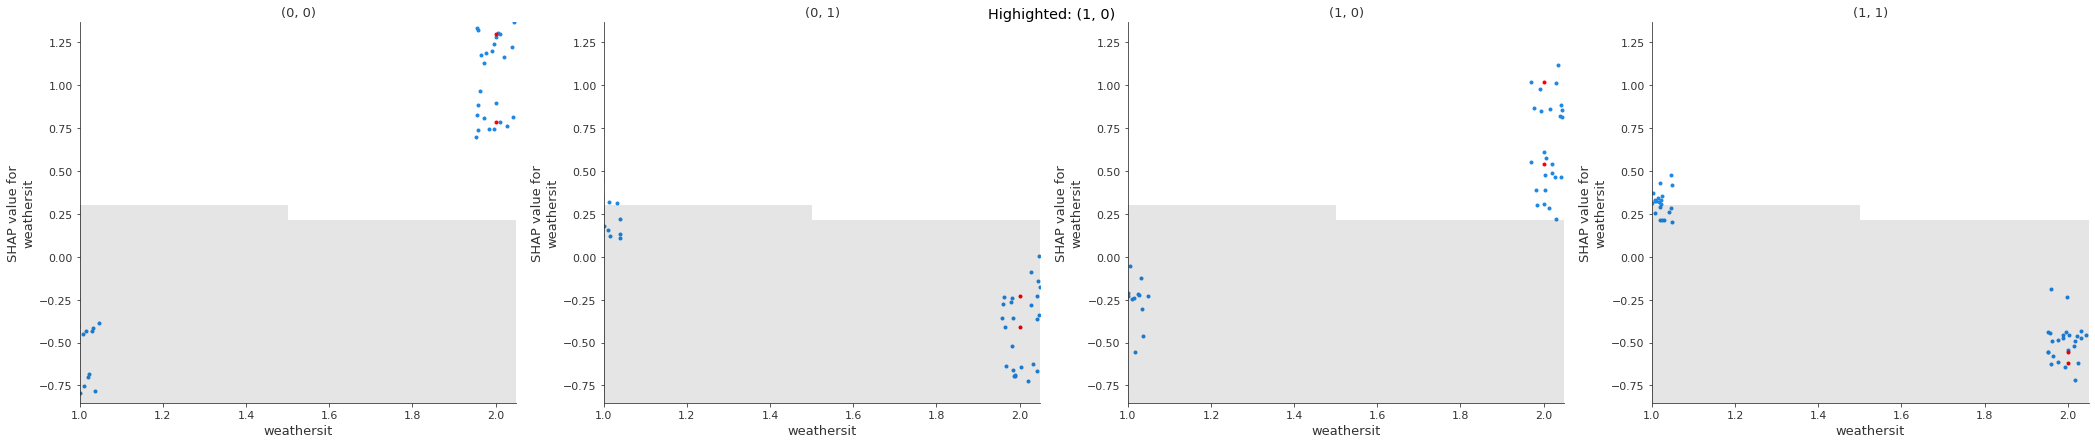

In [21]:
plot_next_feature()

Distribution and effects are similar to the global level. The odds for the two instances classified $(1,0)$ can be expected to increase for $(0,0)$ while decreasing for the original class.

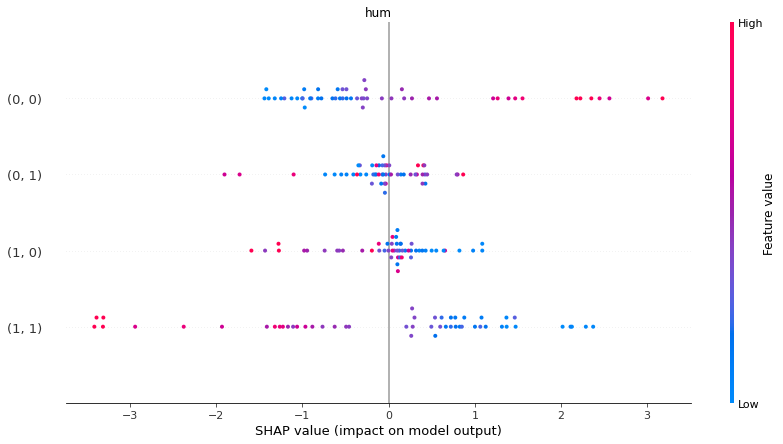

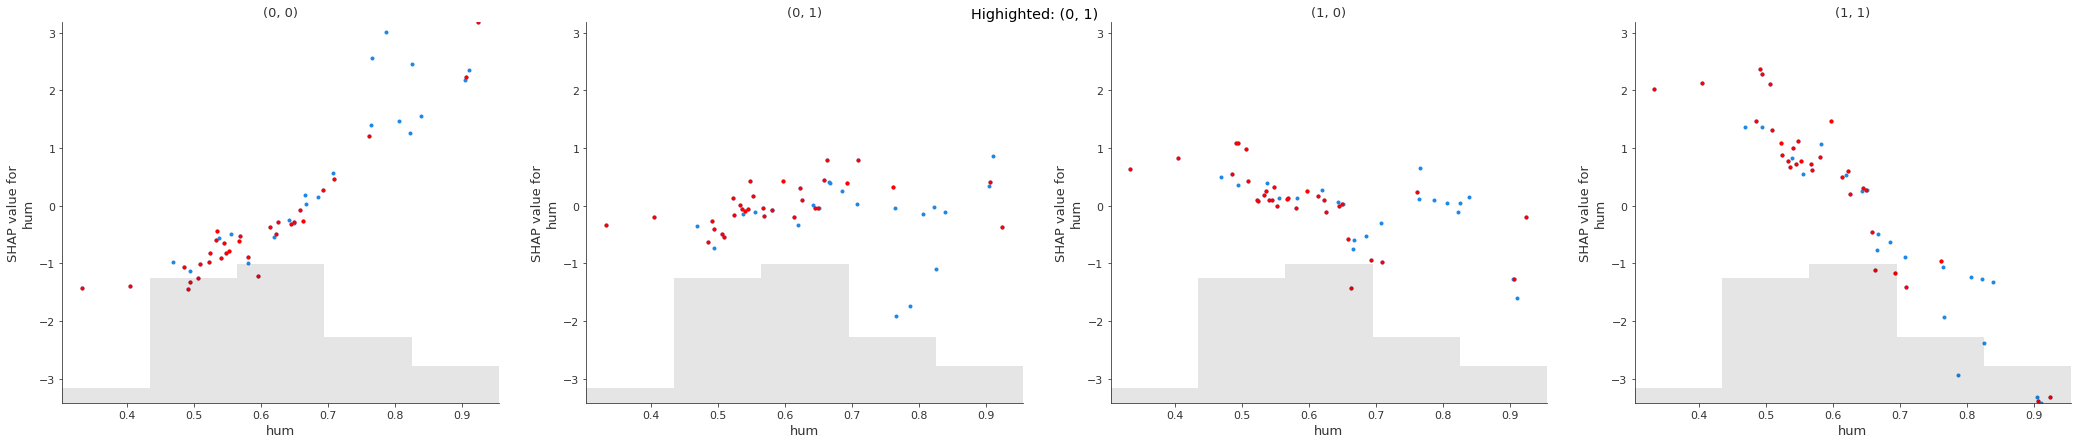

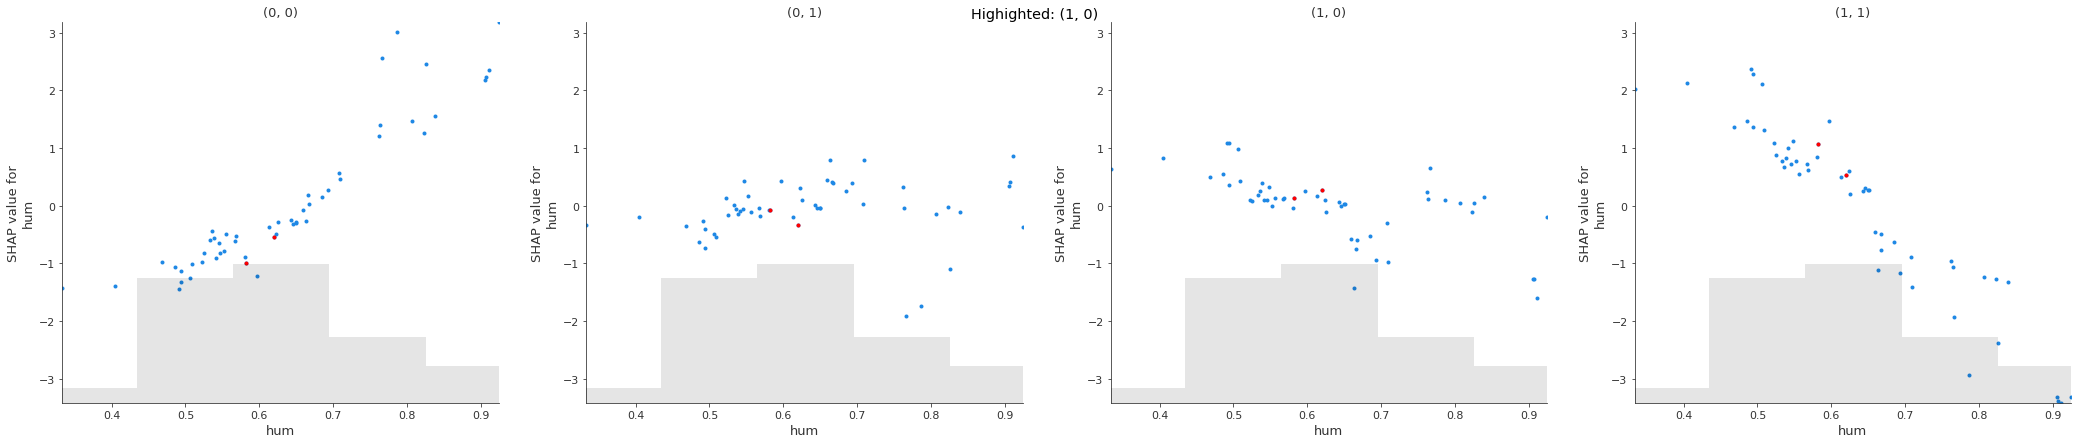

In [22]:
plot_next_feature()

Similar to feature temperature, only a narrow value range is present in the cluster. If felt temperature were even lower for the instances classified as $(0,1)$, the odds would increase for $(0,0)$.

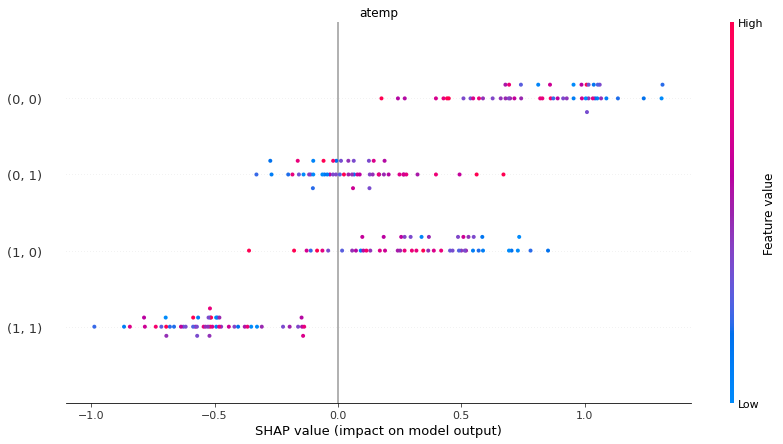

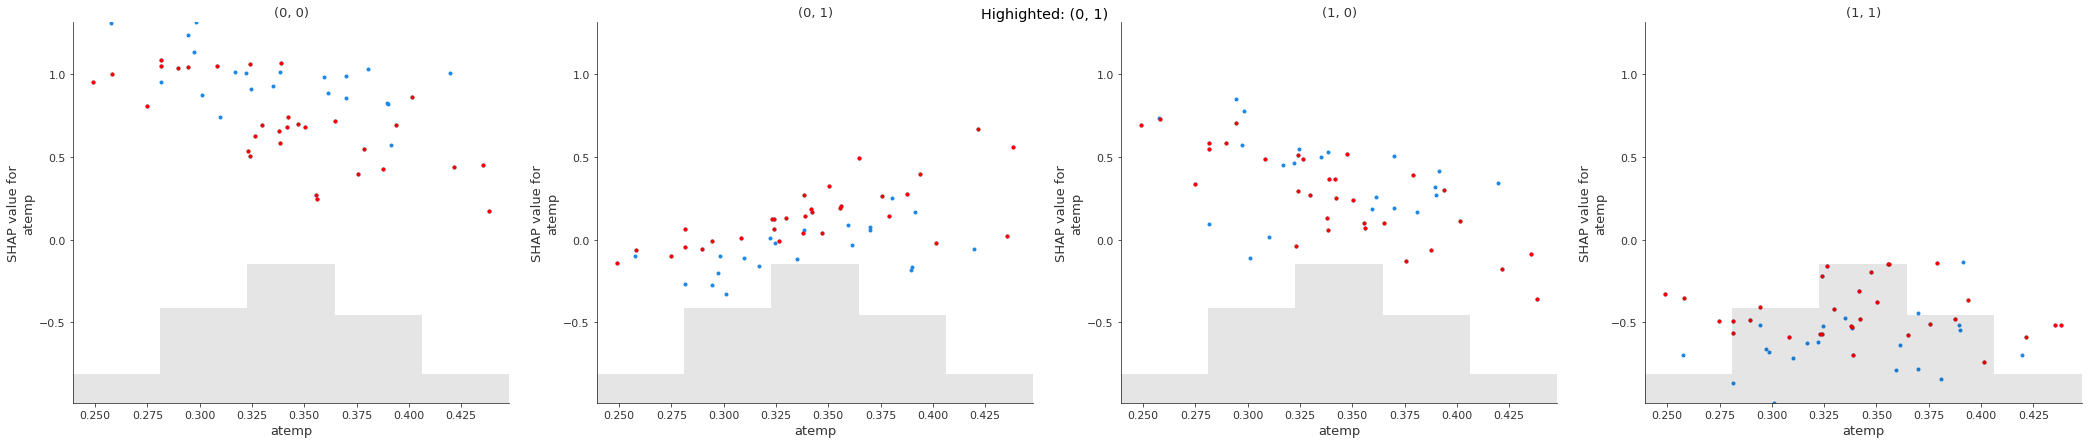

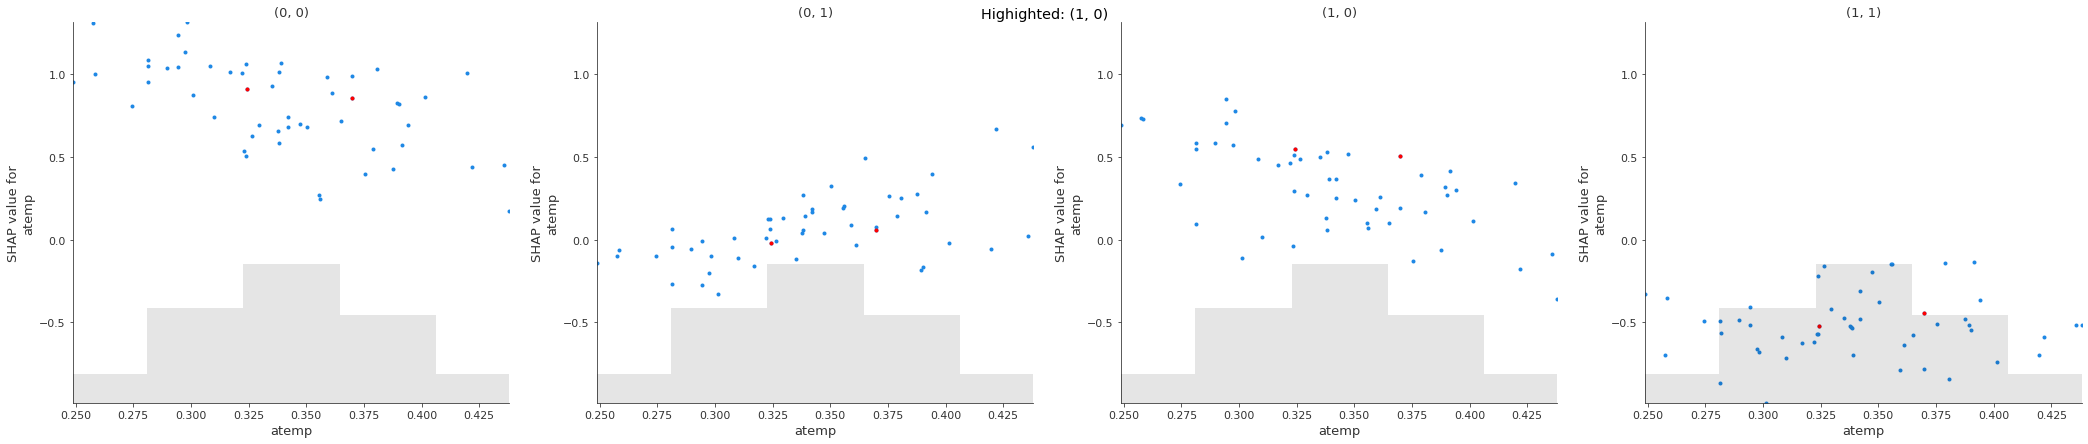

In [23]:
plot_next_feature()

### diro2c

In [58]:
diff_class = diff_classes[0]
start_idx = 0

In [106]:
%%time
explanation = generate_diro2c_explanation(shap_values.data, start_idx, comparer, diff_class, scale_features=scale_features)
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f)

CPU times: user 10min 7s, sys: 39.7 s, total: 10min 46s
Wall time: 3min 42s


In [59]:
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

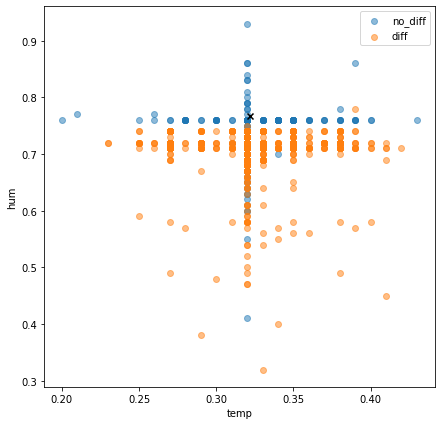

In [60]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, 'temp', 'hum', highlight=x)

In [61]:
diff_class = diff_classes[1]
start_idx = 0

In [ ]:
%%time
explanation = generate_diro2c_explanation(shap_values.data, start_idx, comparer, diff_class, scale_features=scale_features)
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f)

In [62]:
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

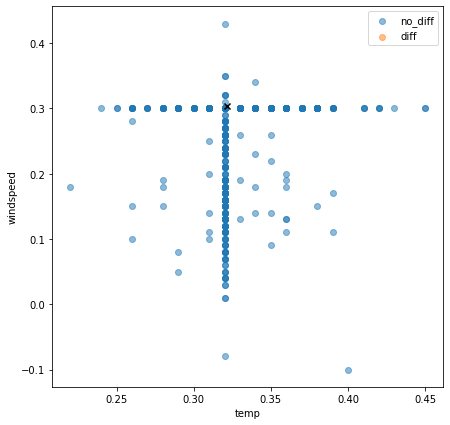

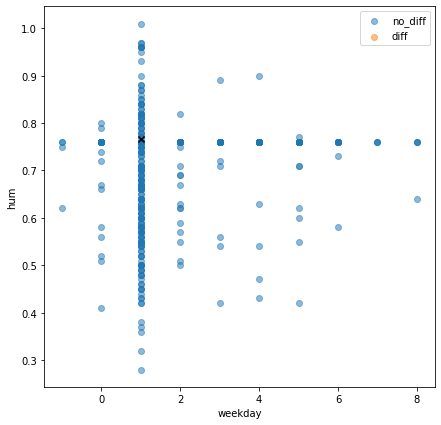

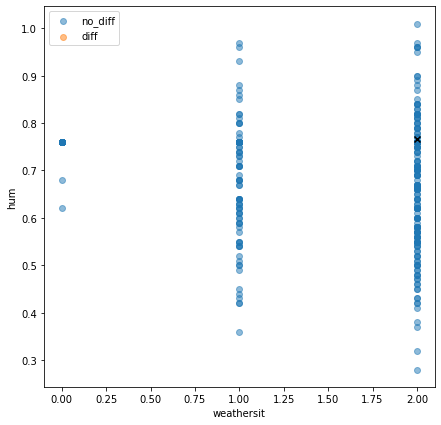

In [63]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, 'temp', 'windspeed', highlight=x)
plot_diro2c_2d(explanation, 'weekday', 'hum', highlight=x)
plot_diro2c_2d(explanation, 'weathersit', 'hum', highlight=x)

## 2nd Cluster

`season` is in this cluster more important than on the global level, but it comprises just winter and spring (`mnth` from 12-4), with `temp` and `atemp` values being in the lower half. `windspeed` is less important in this cluster.

- For instances classified $(0,1)$
  - odds would be decreased for the difference class and/or increased for class $(0,0)$:
      - if `season` was winter instead of spring for this part of the cluster
      - if `temp` was lower
      - if `mnth` was lower
      - if `hum` was higher
      - if `atemp` was lower
  - odds would be decreased for the difference class and/or increased for class $(1,1)$:
      - if `mnth` was 12
      - if `windspeed` was higher

In [64]:
cluster, shap_values, pred_classes, diff_classes = get_next_cluster()

(0, 0)  (0, 1)  (1, 0)  (1, 1)
c2      75       4       0       0

### SHAP-based Difference Classifier Explanations

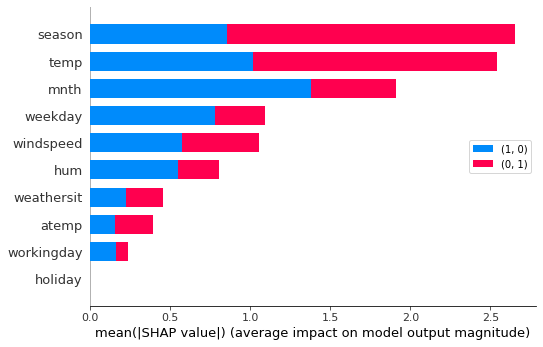

In [65]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, comparer.difference_classes])
plot_feature_importance_bar(shap_values[:, :, comparer.difference_classes])

In [66]:
feature_order = feature_order[:-1]

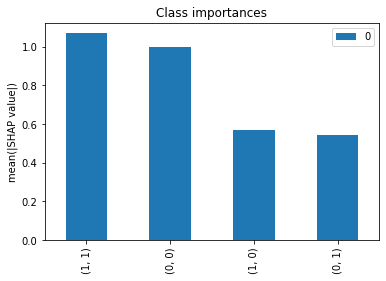

In [31]:
class_order, class_importances = calc_class_order(shap_values)
plot_class_importances(class_importances, class_order, shap_values.output_names)

In [32]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(shap_values[:, [feature_idx]])
    for diff_class in diff_classes:
        plot_feature_effects(shap_values[:, [feature_idx]], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}')
it = iter(feature_order)

For season, we see only spring and winter represented in the cluster. If the value of the three instances of summer was changed to winter, we could expect the odds of the difference class to decrease and increase for $(0,0)$.

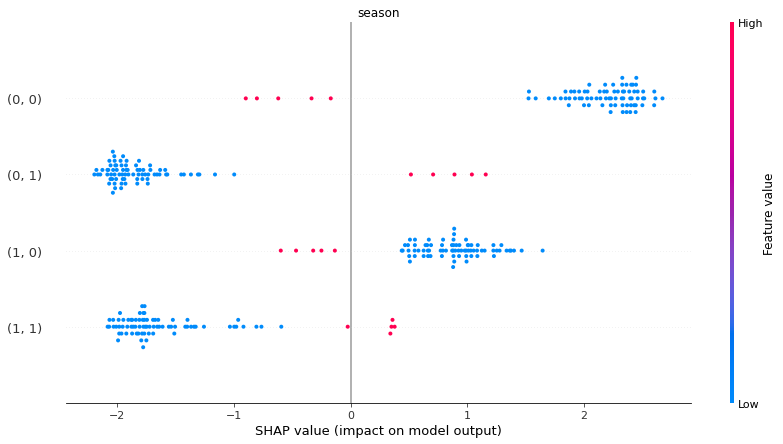

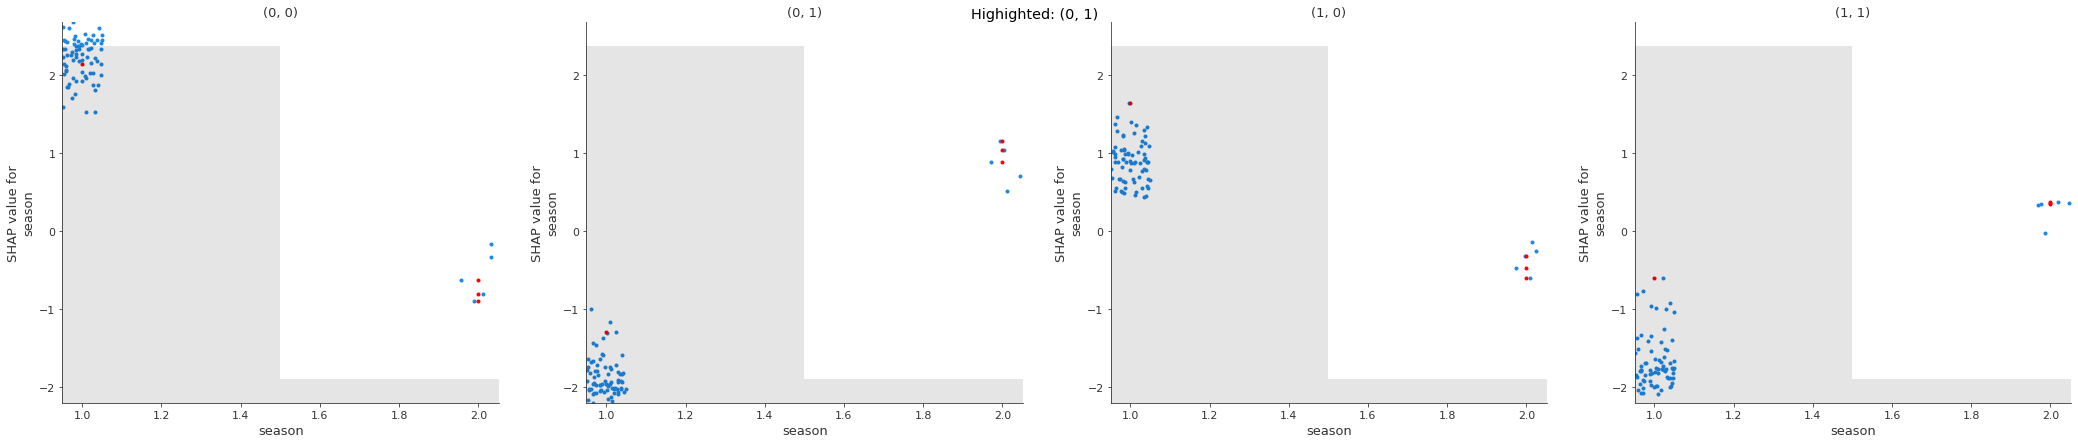

In [33]:
plot_next_feature()

The temperature values present in this cluster are from the lower half of possible values. If they were decreased, we would expect decreased odds for the difference class and increased odds for $(0,0)$. According to the global explanations, we would expect that if values were increased, that at around 0.5 the odds would drop for the difference classes and increase for $(1,1)$.

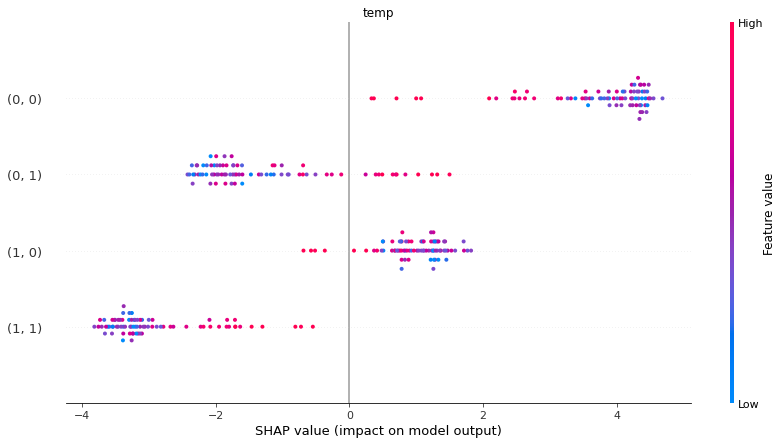

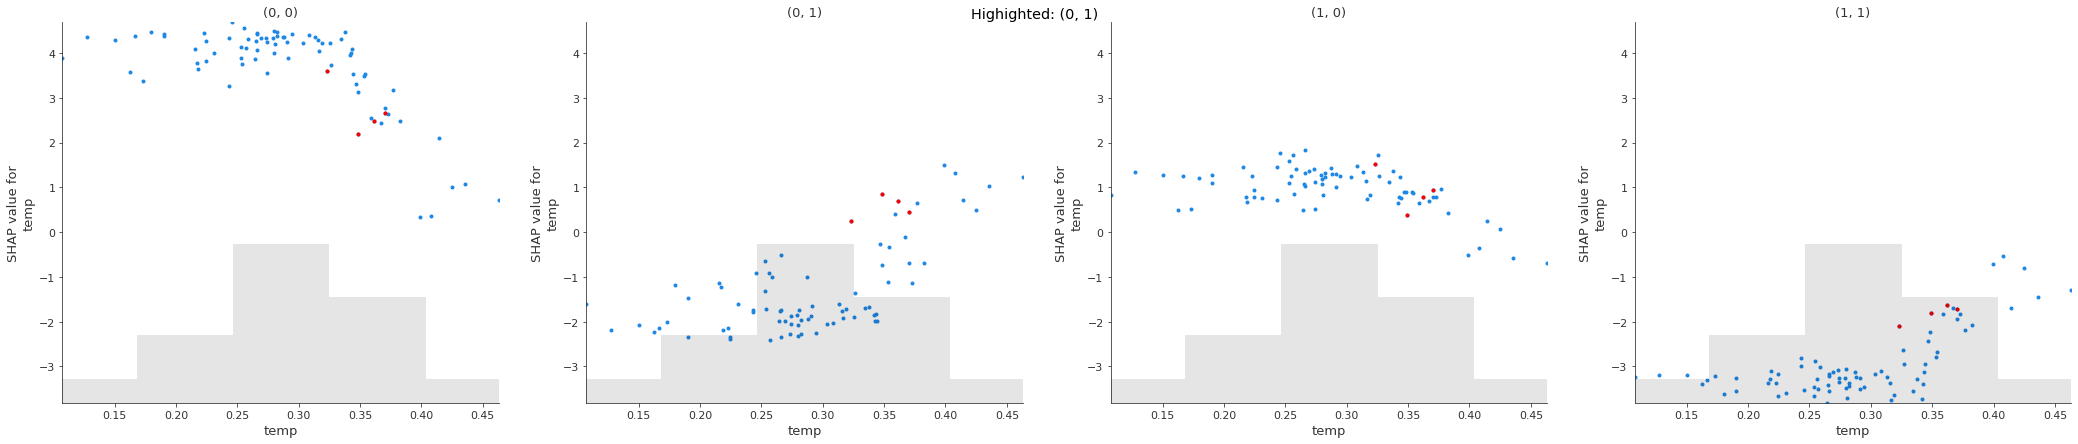

In [34]:
plot_next_feature()

In the cluster we see December until April present and that instances classified differently are from March and April. If the values were changed for February or January, the odds would go down for the difference class and up for $(0,0)$.

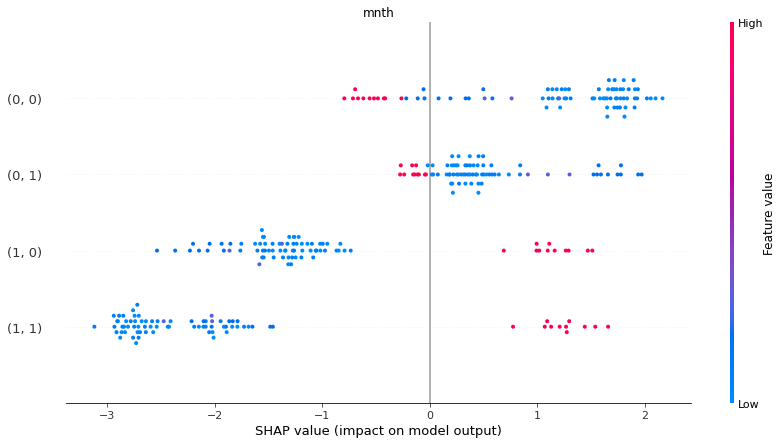

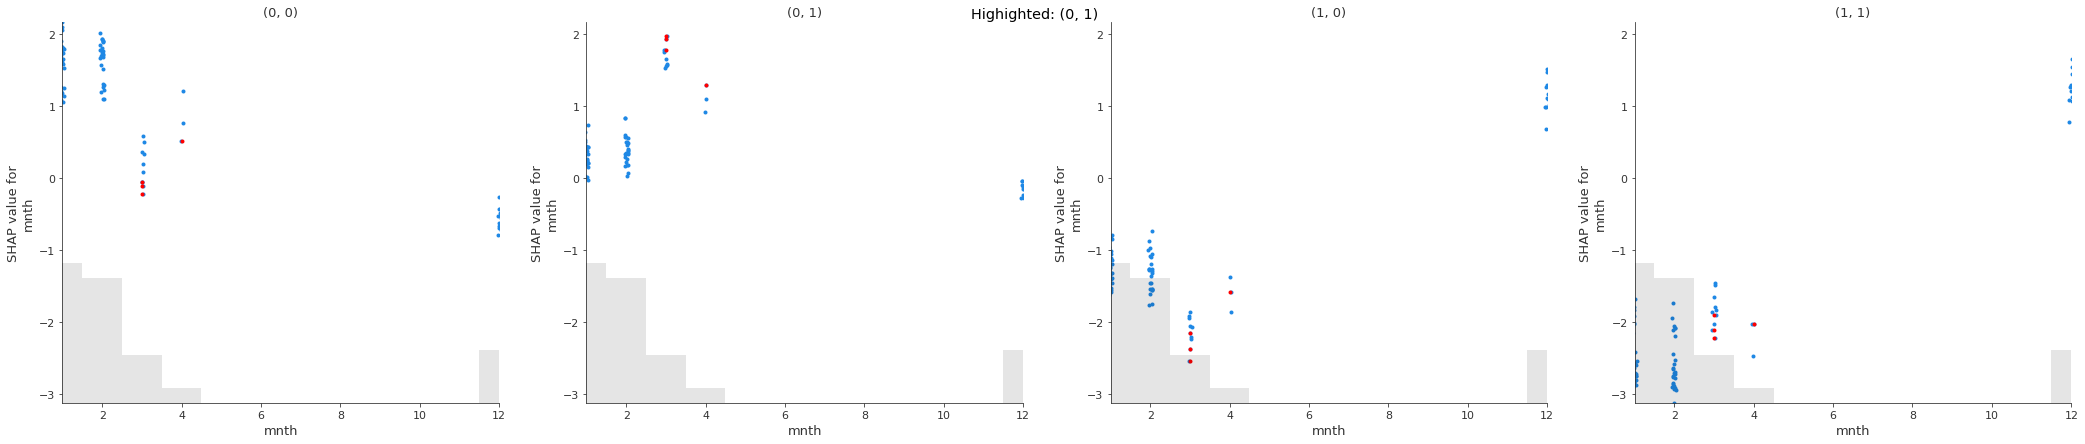

In [35]:
plot_next_feature()

The distribution and effects for weekday are similar to the global explanations. Since the instances classified differently are scattered across the whole range, we cannot reason about effects.

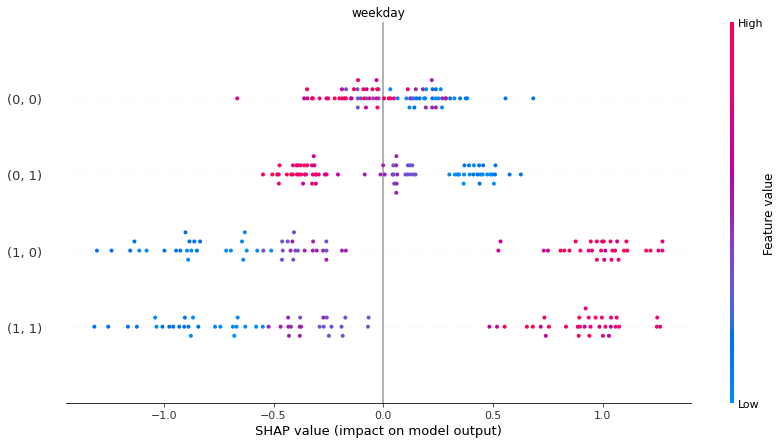

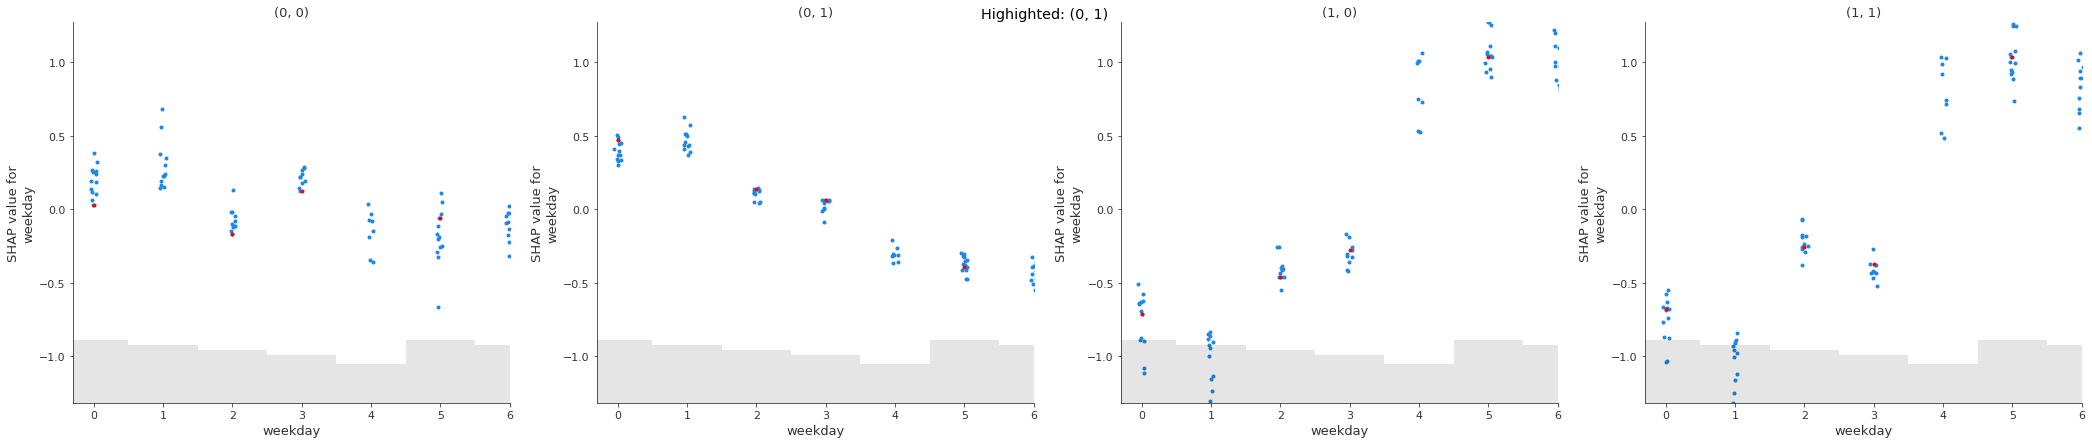

In [36]:
plot_next_feature()

It has to be noted that the distribution of windspeed is narrower than globally, it has less effect on this cluster. An increase of windspeed is expected to lower the odds for the difference class and increase them for $(1,1)$.

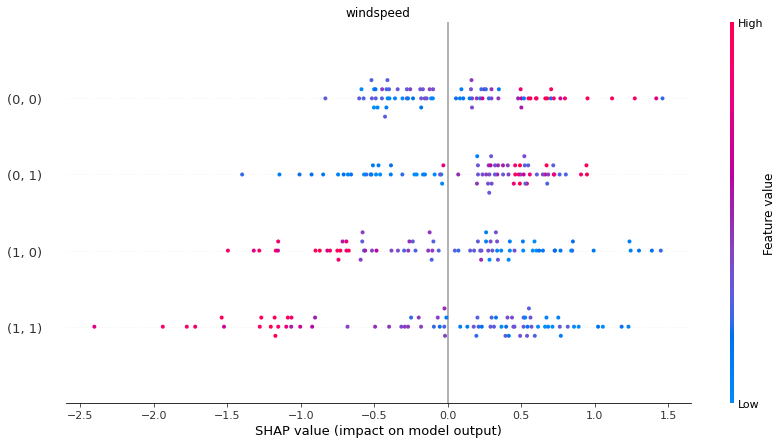

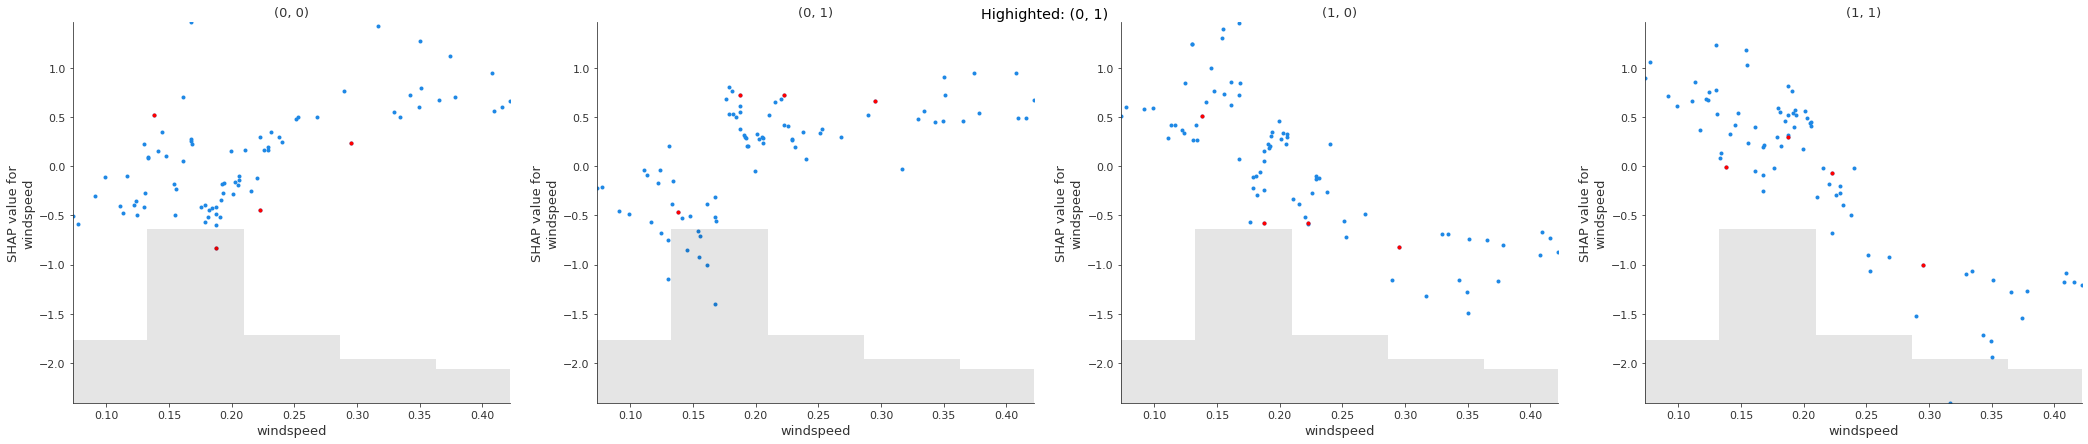

In [37]:
plot_next_feature()

The distribution is similar to the global one. Yet, the instances classified differently in this cluster are in the lower half. That means if humidity was higher, we could expect the odds for the difference class to go down and for $(0,0)$ to go up.

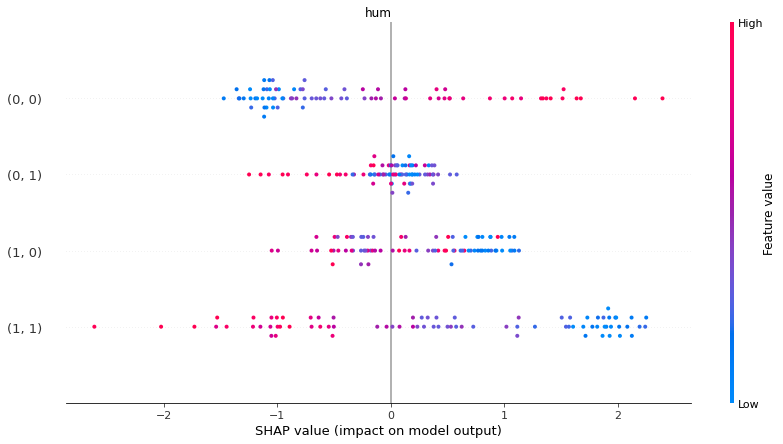

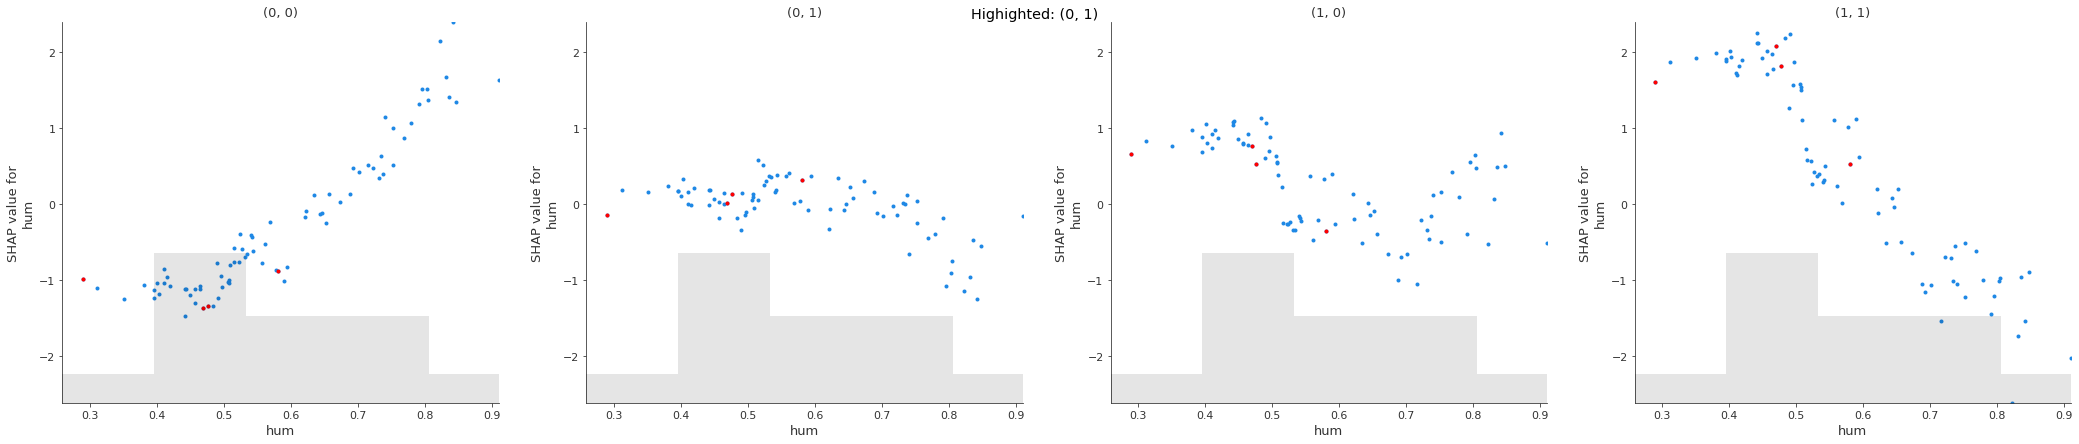

In [38]:
plot_next_feature()

similar to global

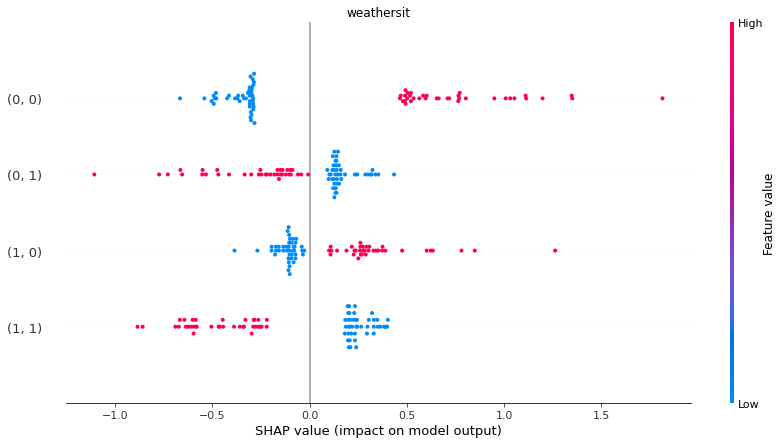

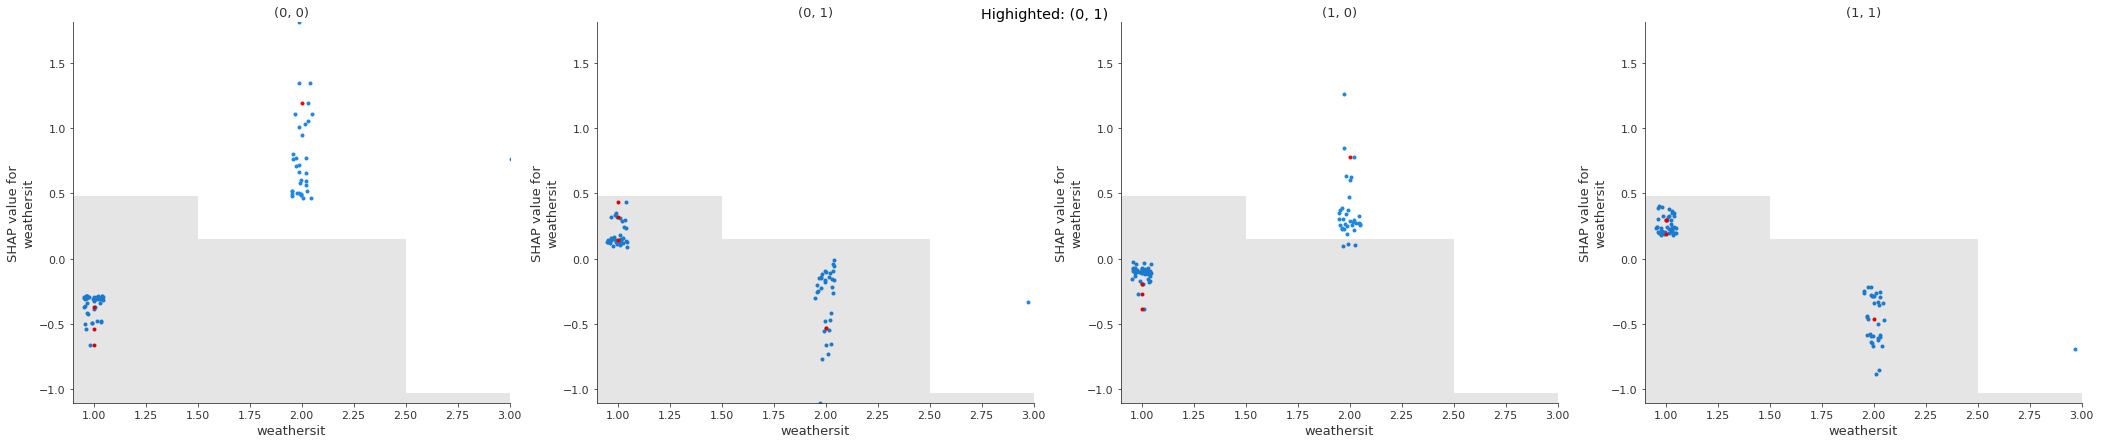

In [39]:
plot_next_feature()

present values are in lower half of feature range, decrease felt temperature => decrease odds for difference class, increase odds for $(0,0)$ slightly

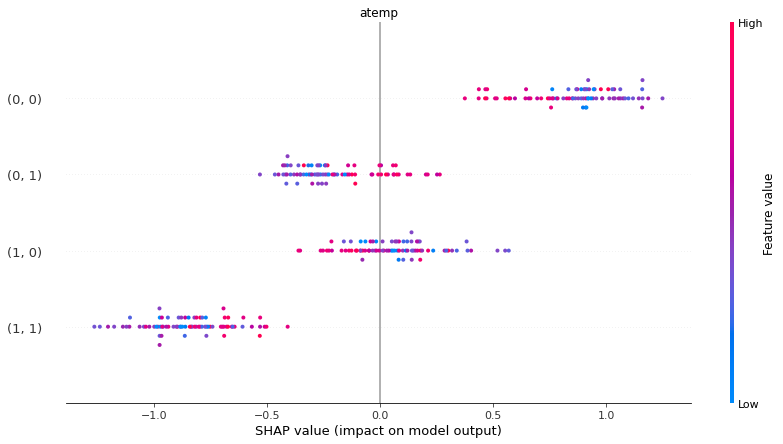

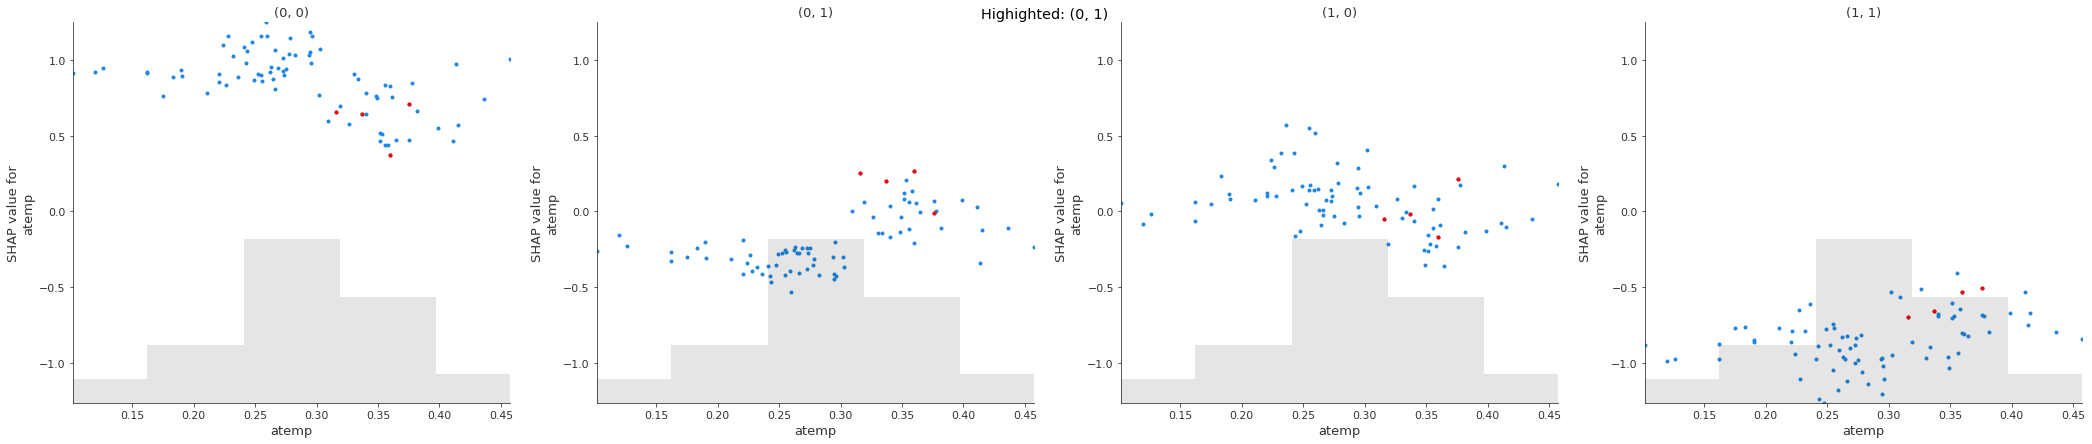

In [40]:
plot_next_feature()

### diro2c

In [67]:
diff_class = diff_classes[0]
start_idx = 0

In [106]:
%%time
explanation = generate_diro2c_explanation(shap_values.data, start_idx, comparer, diff_class, scale_features=scale_features)
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f)

CPU times: user 10min 7s, sys: 39.7 s, total: 10min 46s
Wall time: 3min 42s


In [68]:
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

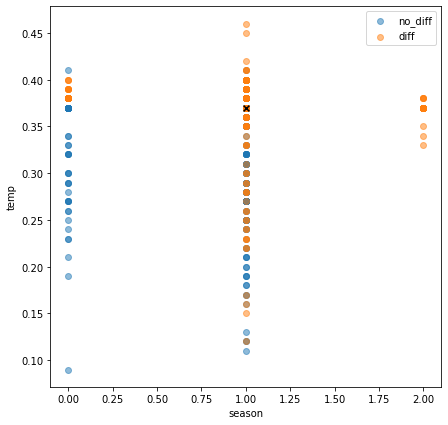

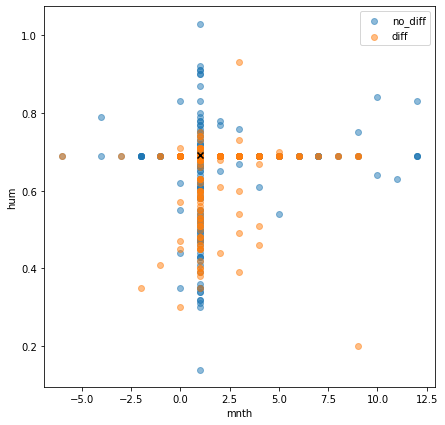

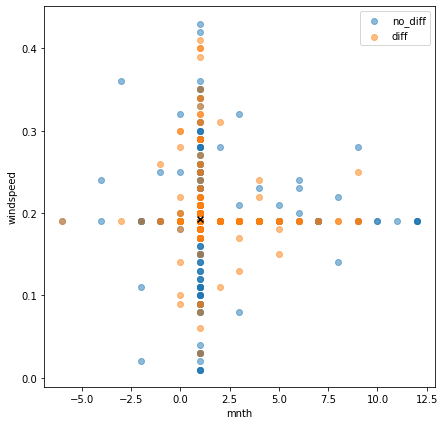

In [69]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, feature_order[0], feature_order[1], highlight=x)
plot_diro2c_2d(explanation, 'mnth', 'hum', highlight=x)
plot_diro2c_2d(explanation, 'mnth', 'windspeed', highlight=x)

## 3rd Cluster

In this cluster, `month` is now the most important feature.
Furthermore, `hum` and `atemp` have unusually high importance.
The ranges of `temp` and `atemp` are a bit narrower (0.3-0.85).
`weathersit` has only values 1 and 2.
`workingday` is disregarded, because there is a knee point between `weathersit` and `workingday`.

- For instances classified $(0,1)$
    - odds would be decreased for the difference class and/or increased for class $(0,0)$:
        - if `season` was lower (winter)
        - if `weathersit` was higher (2)
    - odds would be decreased for the difference class and/or increased for class $(1,1)$:
        - if `temp` was higher (until 0.75) for instances with $temp<0.5$
        - if `atemp` was higher (until 0.7) for instances with $atemp<0.5$
        - if `atemp` was lower (until 0.5) for instances with $atemp>0.7$
        - if `hum` was lower
        - if `weekday` was higher for $weekday \lte 3$
        - if `windspeed` was lower
        - if `weathersit` was lower (1)

In [70]:
cluster, shap_values, pred_classes, diff_classes = get_next_cluster()

(0, 0)  (0, 1)  (1, 0)  (1, 1)
c3       0      95       0      64

### SHAP-based Difference Classifier Explanations

month now most important, humidity and felt temperature rank higher

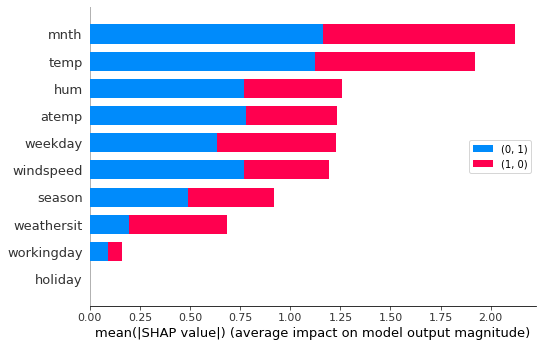

In [71]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, comparer.difference_classes])
plot_feature_importance_bar(shap_values[:, :, comparer.difference_classes])

In [72]:
feature_order = feature_order[:-2]

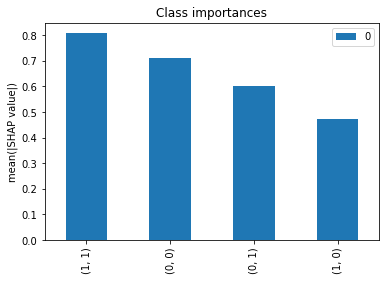

In [46]:
class_order, class_importances = calc_class_order(shap_values)
plot_class_importances(class_importances, class_order, shap_values.output_names)

In [47]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(shap_values[:, [feature_idx]])
    for diff_class in diff_classes:
        plot_feature_effects(shap_values[:, [feature_idx]], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}')
it = iter(feature_order)

distribution similar, effects like global

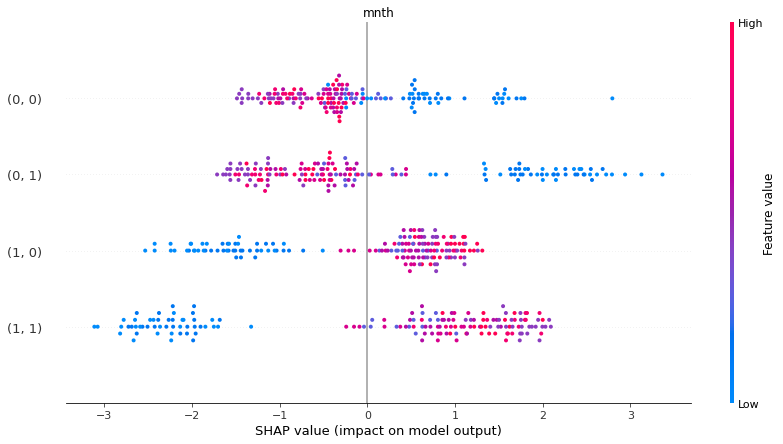

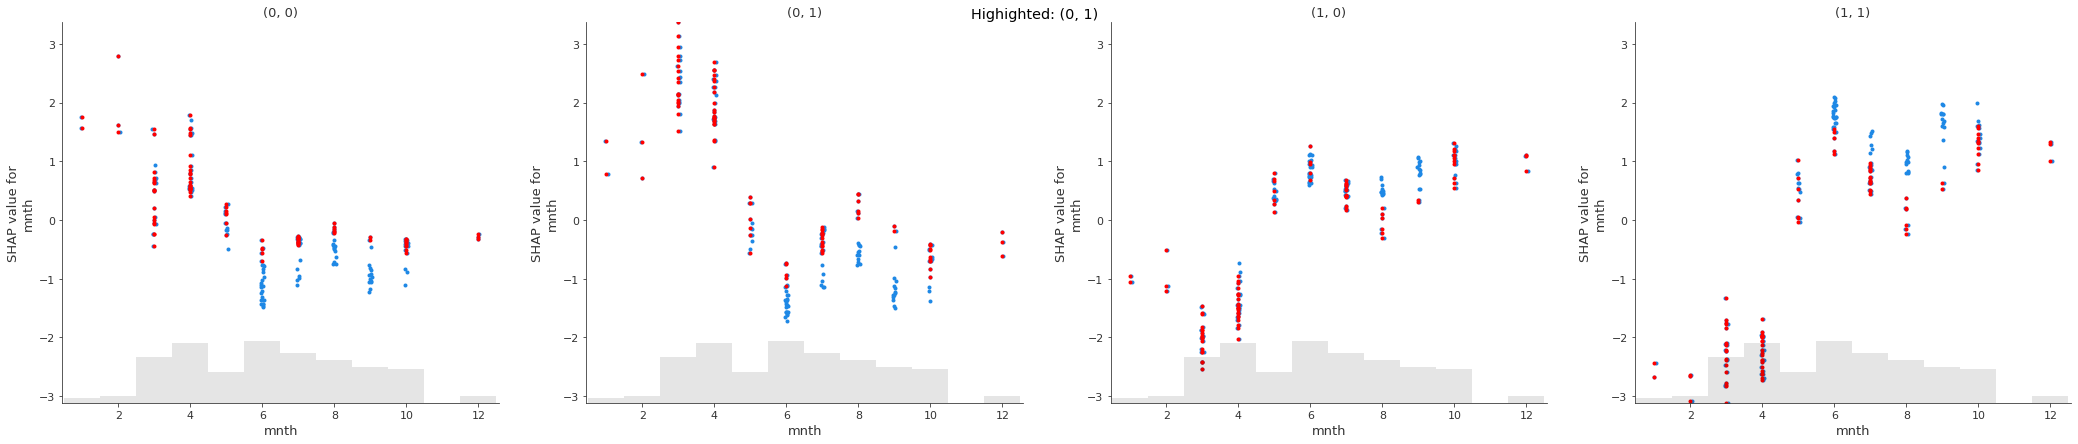

In [48]:
plot_next_feature()

Only mid-range temperature values present, increase values of lower half => $(1,1)$, decrease values of upper half => $(0,0)$

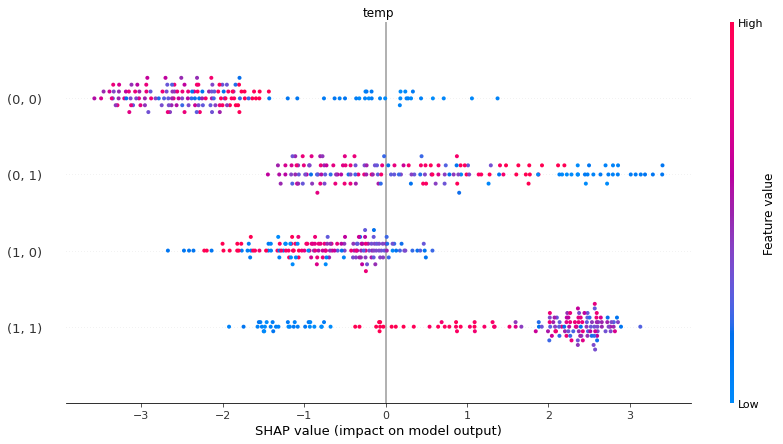

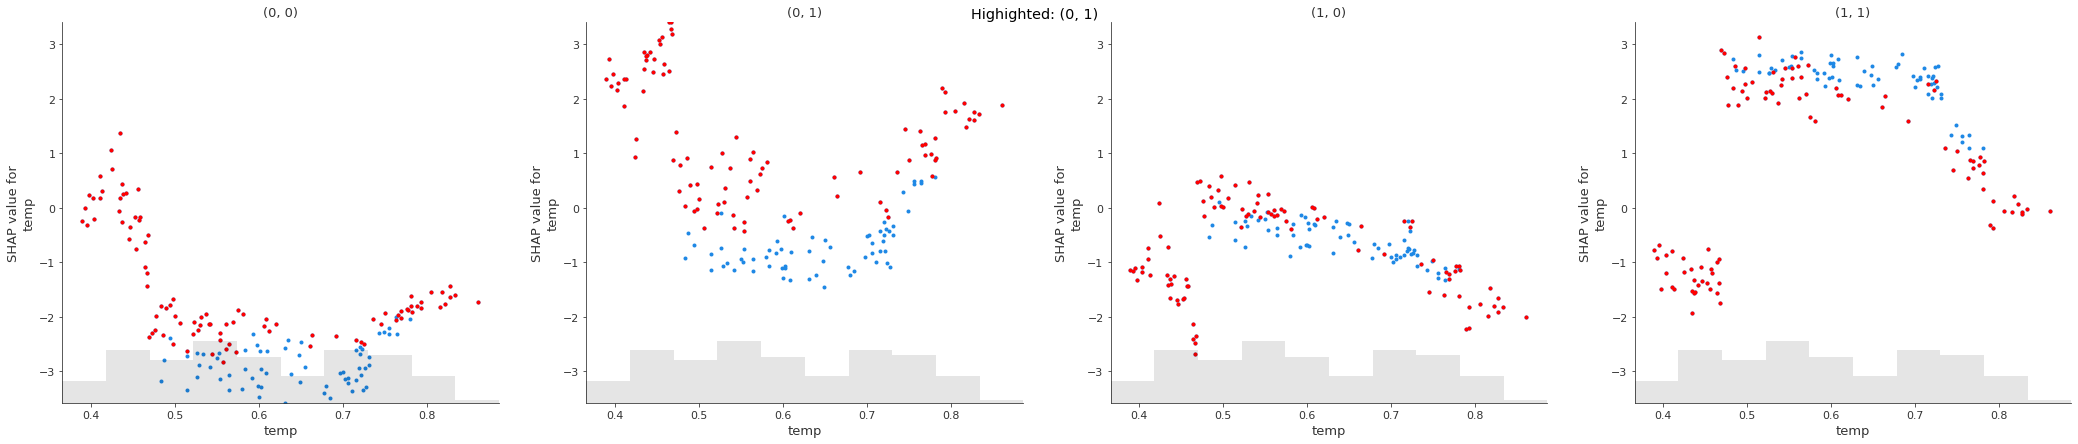

In [49]:
plot_next_feature()

Decrease values => $(1,1)$

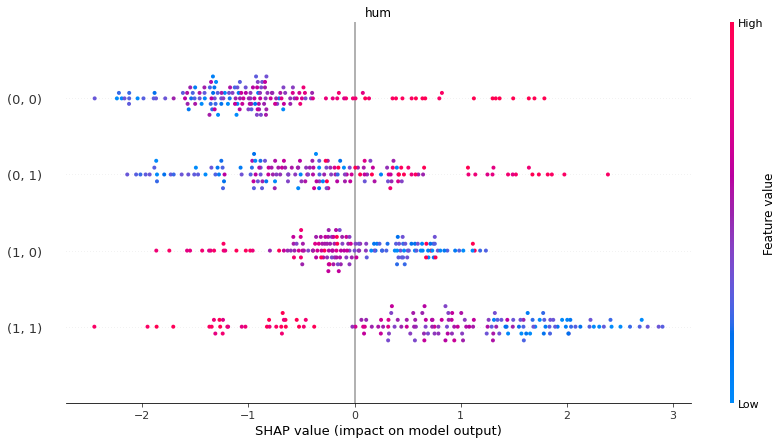

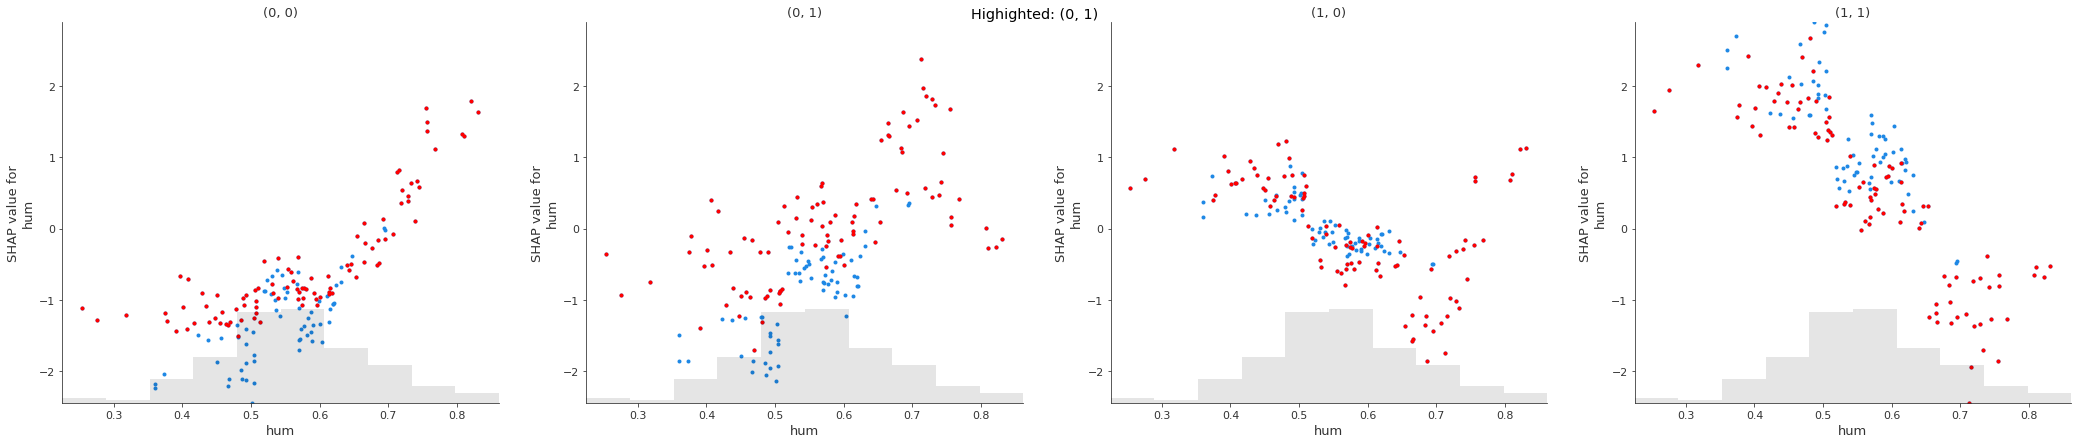

In [50]:
plot_next_feature()

Lower half different from upper half, distribution lacks lower values that are classified equally. increase lower half values => $(1,1)$, decrease upper half values => $(1,1)$

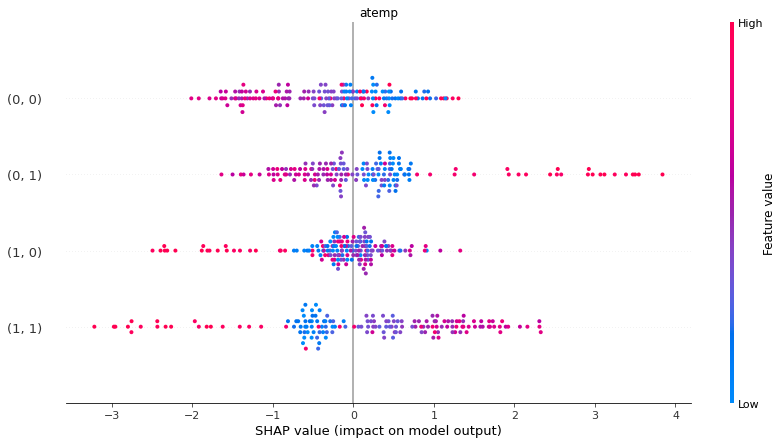

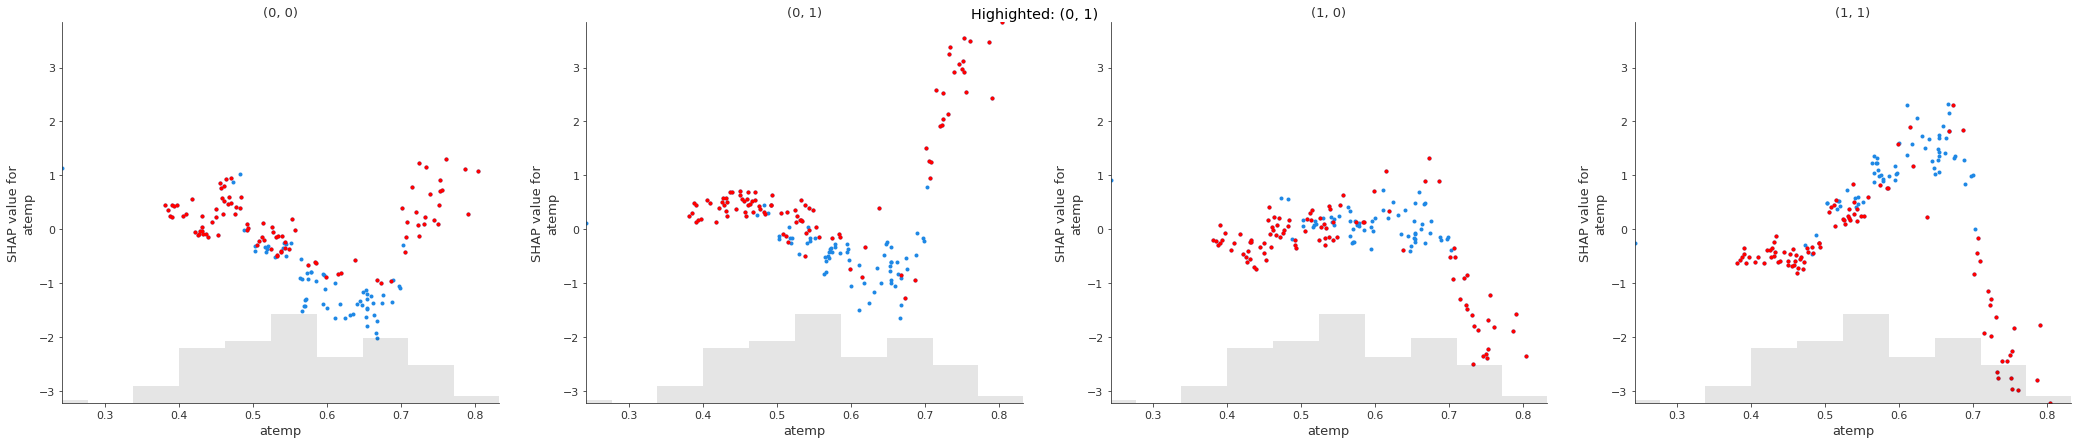

In [51]:
plot_next_feature()

similar to global distribution and effects

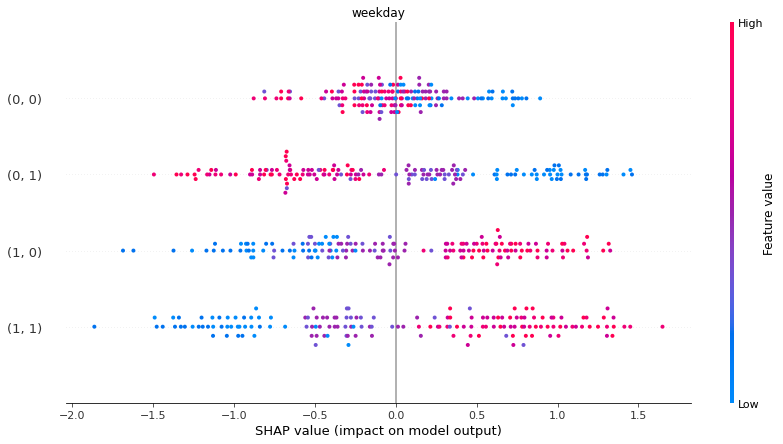

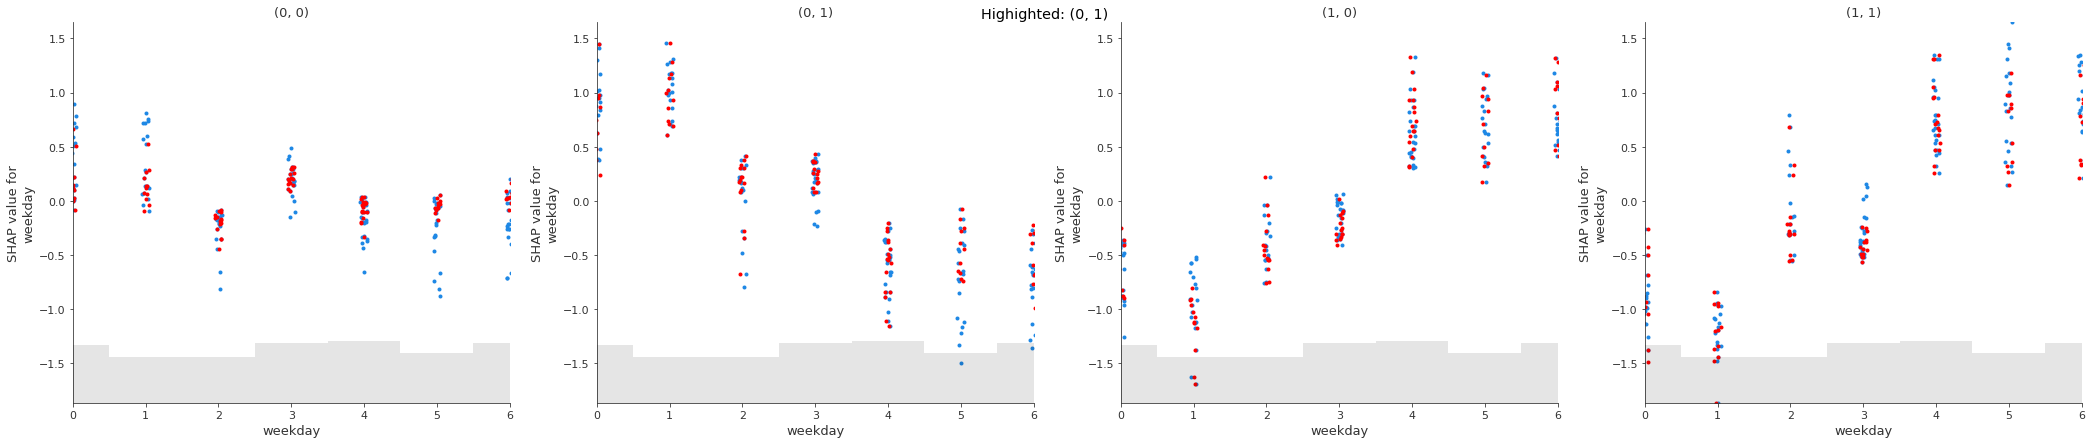

In [52]:
plot_next_feature()

similar to global

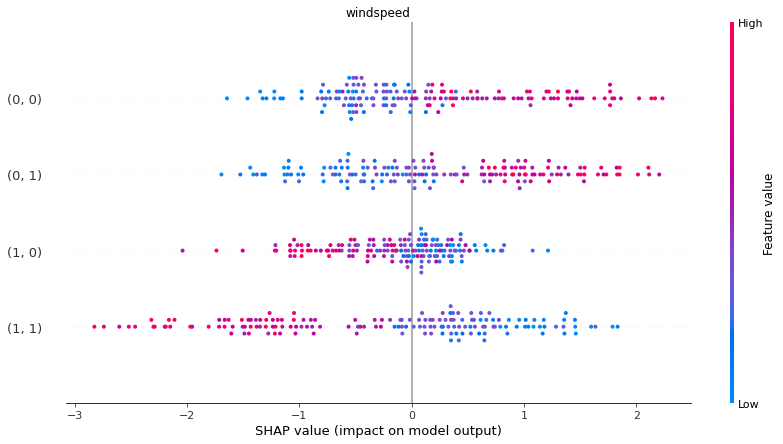

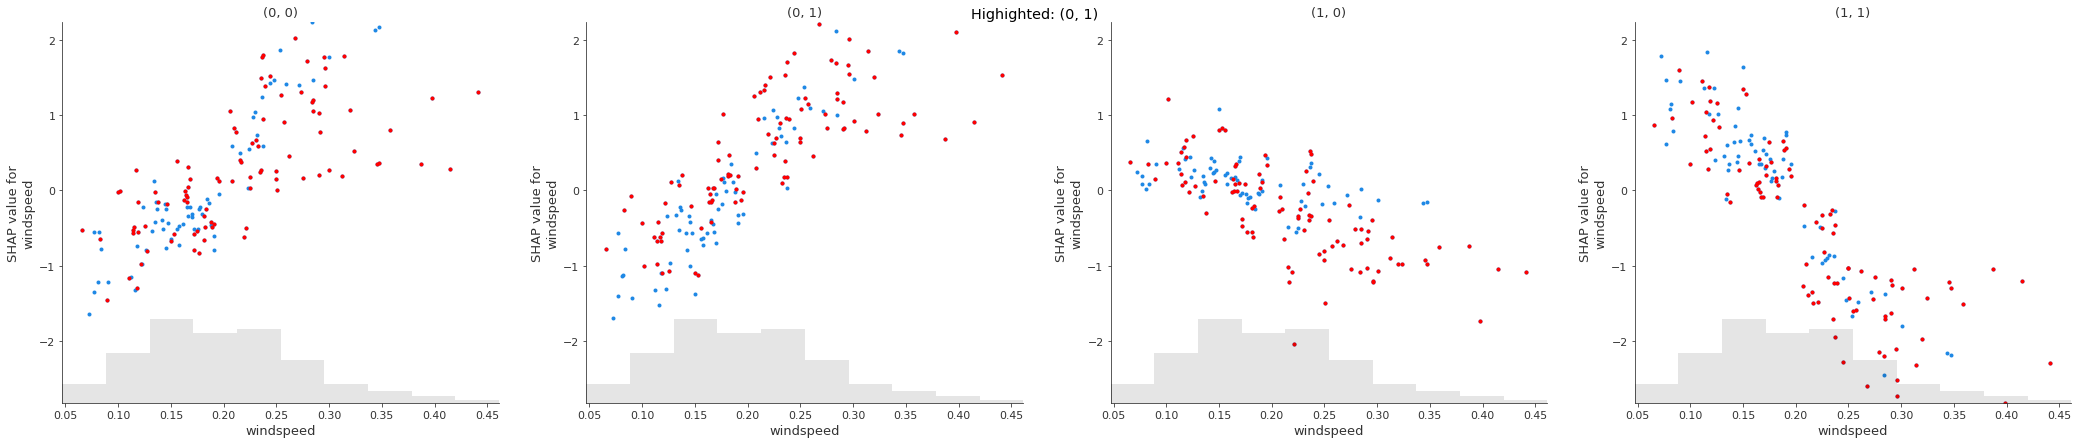

In [53]:
plot_next_feature()

similar to global

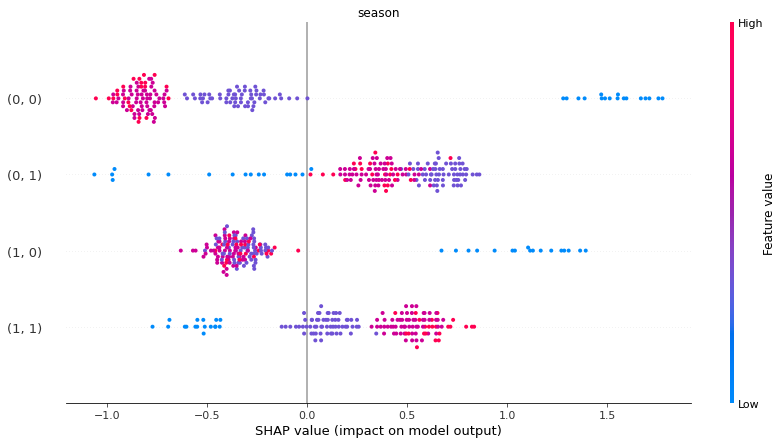

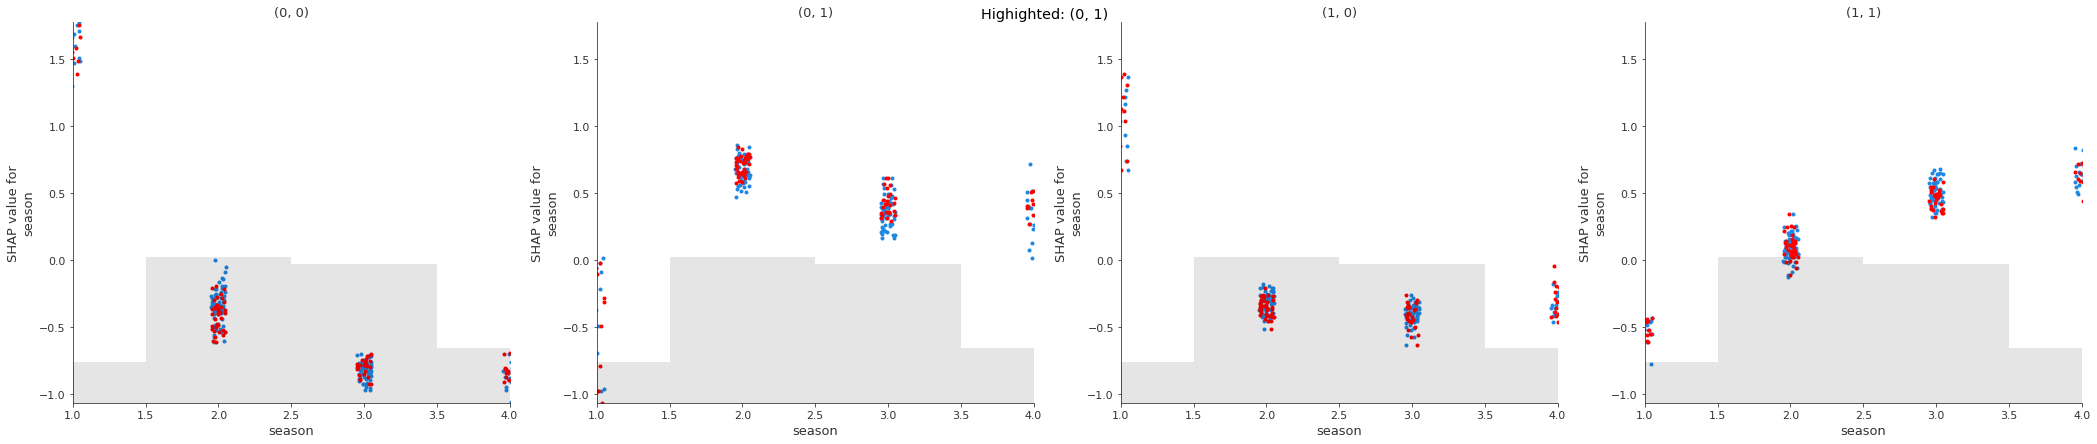

In [54]:
plot_next_feature()

more from weathersit=1, increase values => $(0,0)$

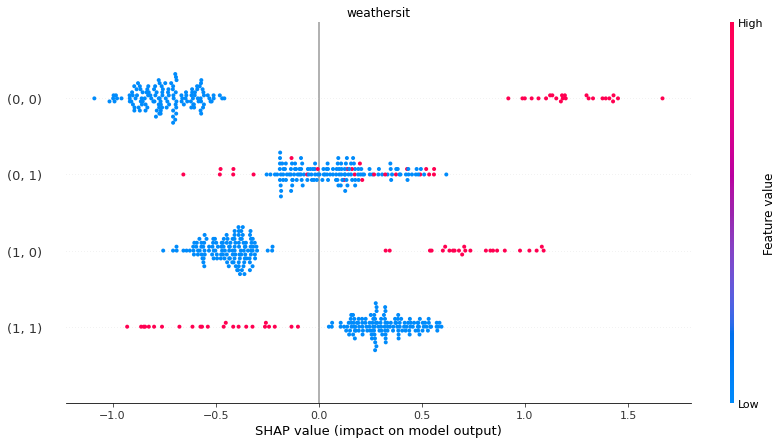

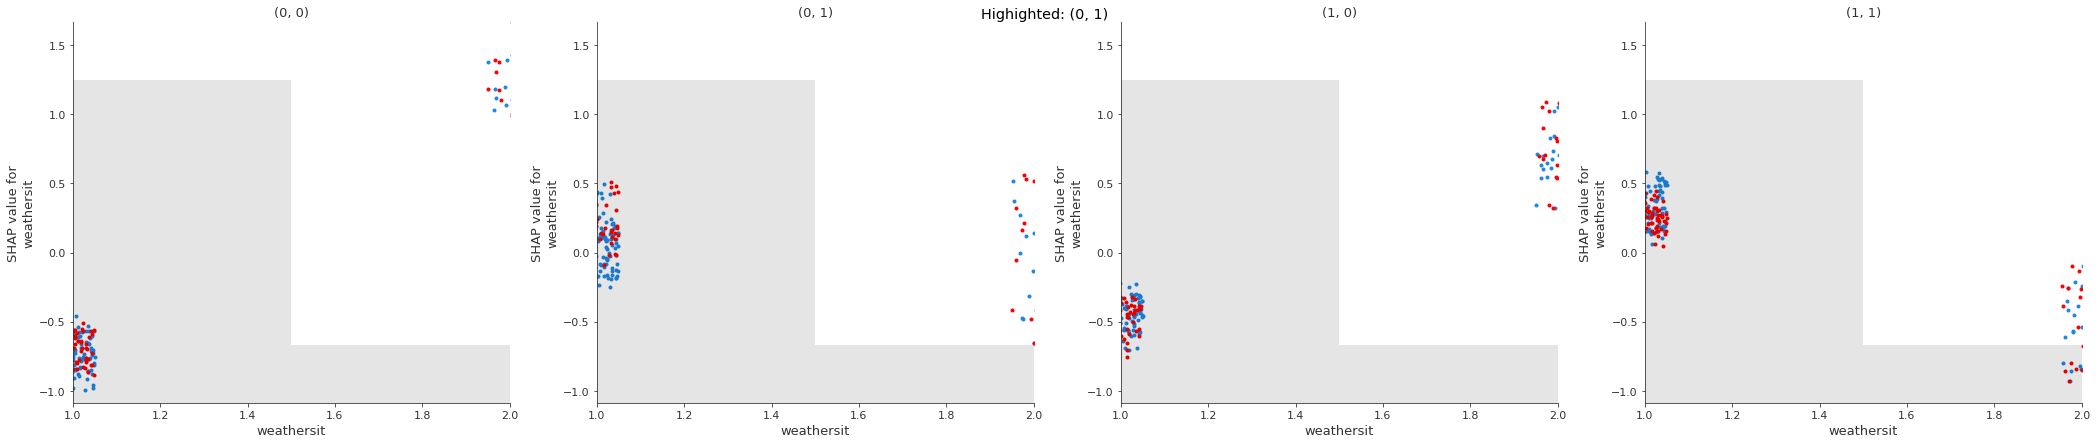

In [55]:
plot_next_feature()

### diro2c

In [73]:
diff_class = diff_classes[0]
start_idx = 0

In [ ]:
%%time
explanation = generate_diro2c_explanation(shap_values.data, start_idx, comparer, diff_class, scale_features=scale_features)
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f)

In [74]:
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

What we see most prominent in the first figure, is that there are many instances classified equally for $temp<0.3$.
This is already known from the global effects, because in this range there are only
a few instances classified differently because the odds for class $(0,0)$ are really high (approx. +4).

Of the theories built on local explanations, we see only _if windspeed was lower_ reflected in the 3rd plot,
with an increasing number of equally predicted instances below 0.1.
Please mind, that 0 is not a valid value for `weathersit`.

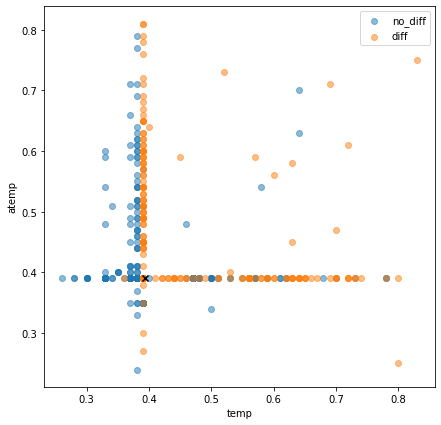

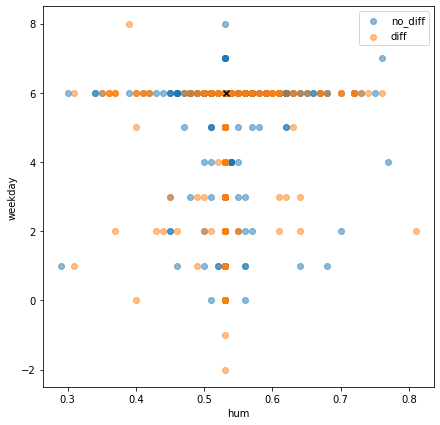

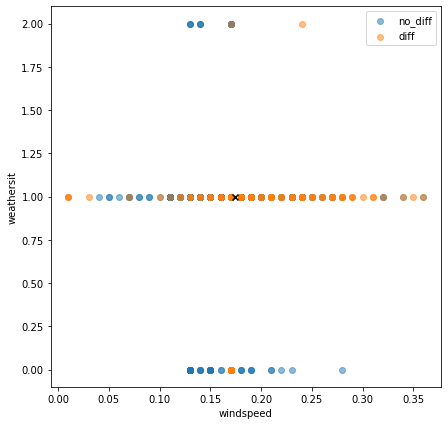

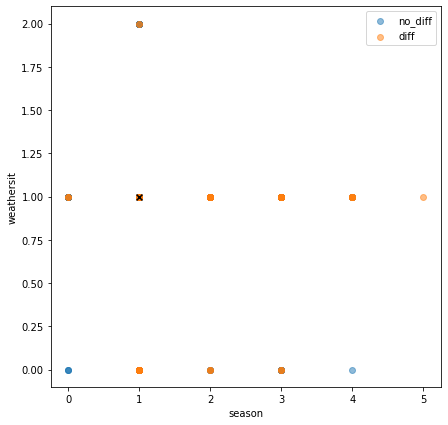

In [75]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, 'temp', 'atemp', highlight=x)
plot_diro2c_2d(explanation, 'hum', 'weekday', highlight=x)
plot_diro2c_2d(explanation, 'windspeed', 'weathersit', highlight=x)

plot_diro2c_2d(explanation, 'season', 'weathersit', highlight=x)

## 4th Cluster

`hum` is by far the most important feature,
having only high values present (>0.75).
The second  most important one is `weekday`.
The globally most important feature `temp` ranks now lower, along with `atemp`.
A knee point is present between `season` and `workingday`,
so I wont generate explanations for these.
Instances in this cluster have only mid-range `windspeed` values (0.2-0.35),
`weathersit` 2 and 3, mid-range `temp` and `atemp` values (0.4-0.65) and
 `season` spring, summer, fall present.

- For instances classified $(0,1)$
    1. odds would be decreased for the difference class and/or increased for class $(0,0)$:
        1. if `windspeed` was higher
        2. if `atemp` was lower
        3. if `season` was lower
    2. odds would be decreased for the difference class and/or increased for class $(1,1)$:
        1. if `weekday` was higher for instances with $weekday<3$
        2. if `mnth` was higher for instances with $mnth=3$
        3. if `windspeed` was lower
        4. if `temp` was higher
        5. if `atemp` was higher
        6. if `season` was higher

In [23]:
cluster, shap_values, pred_classes, diff_classes = get_next_cluster()

(0, 0)  (0, 1)  (1, 0)  (1, 1)
c4       8       5       0       0

### SHAP-based Difference Classifier Explanations

humidity now on top, weekday higher too, temp and atemp lower, 

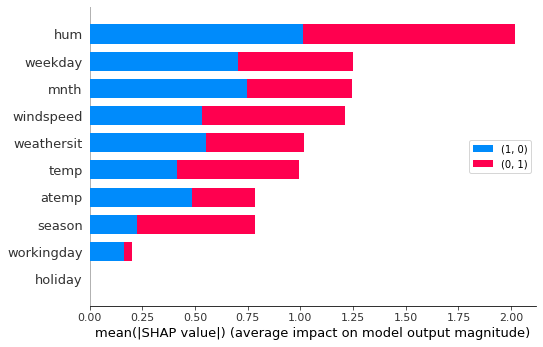

In [59]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, comparer.difference_classes])
plot_feature_importance_bar(shap_values[:, :, comparer.difference_classes])

In [60]:
feature_order = feature_order[:-1]

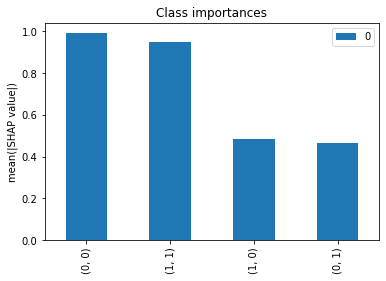

In [61]:
class_order, class_importances = calc_class_order(shap_values)
plot_class_importances(class_importances, class_order, shap_values.output_names)

In [62]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(shap_values[:, [feature_idx]])
    for diff_class in diff_classes:
        plot_feature_effects(shap_values[:, [feature_idx]], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}')
it = iter(feature_order)

only high humidity values present, but no trend visible.

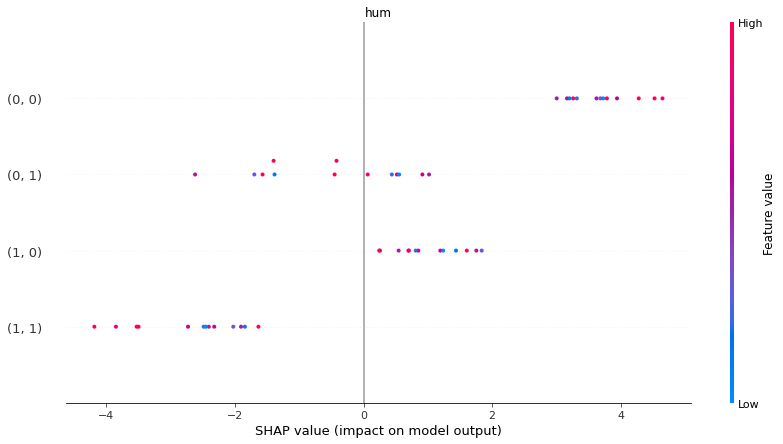

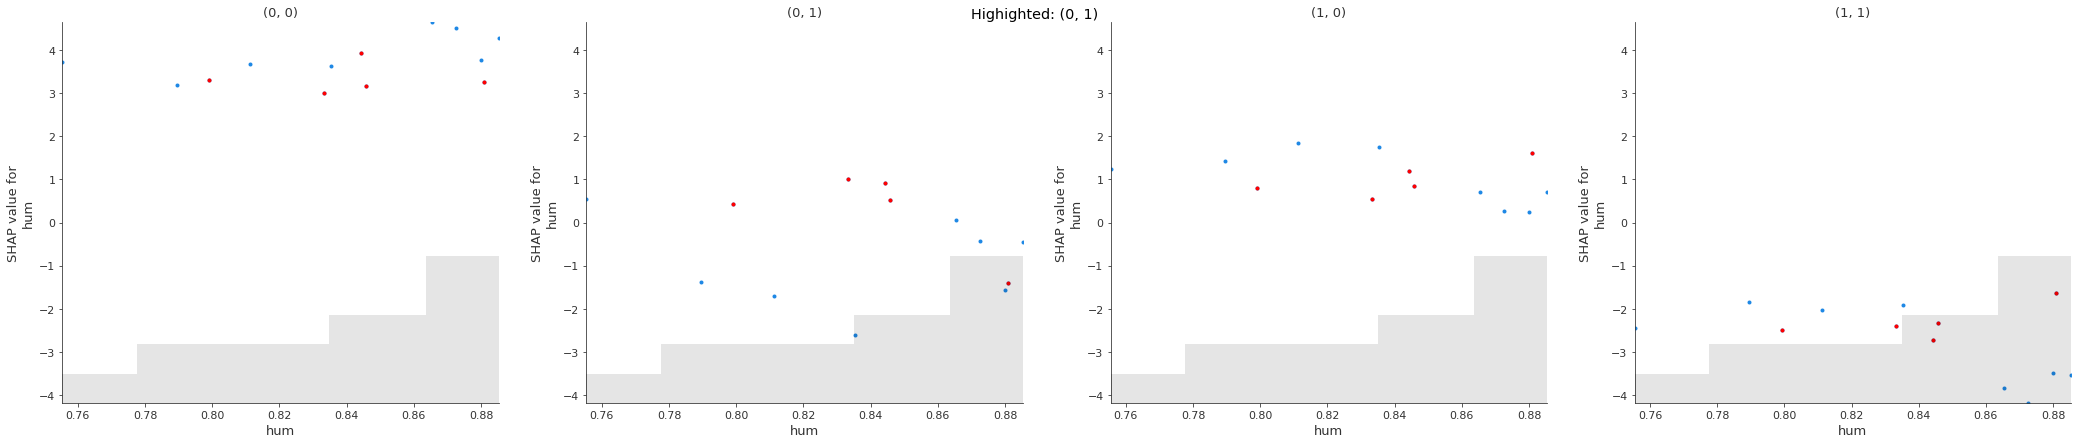

In [63]:
plot_next_feature()

Trends similar to global, increase lower for $(1,1)$

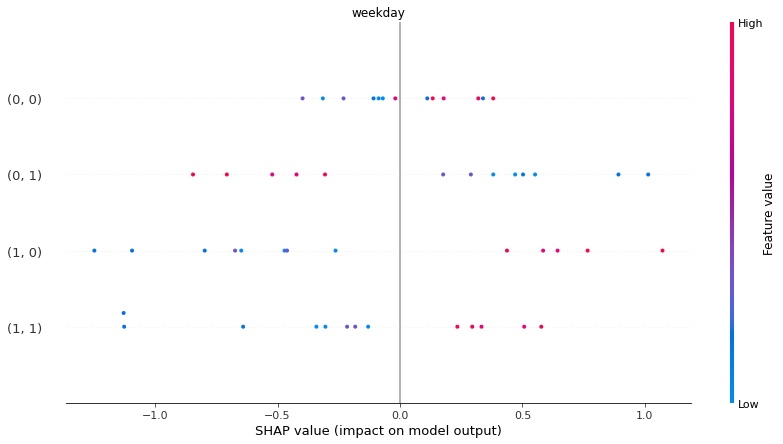

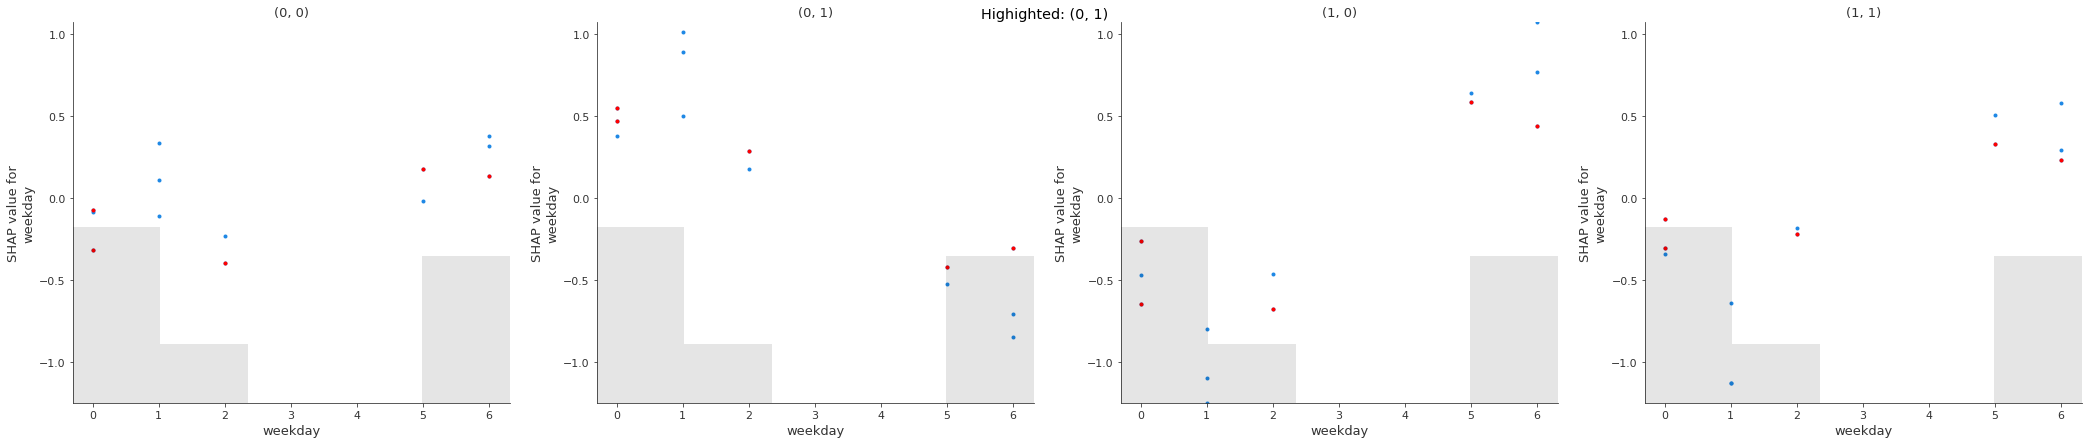

In [64]:
plot_next_feature()

similar to global

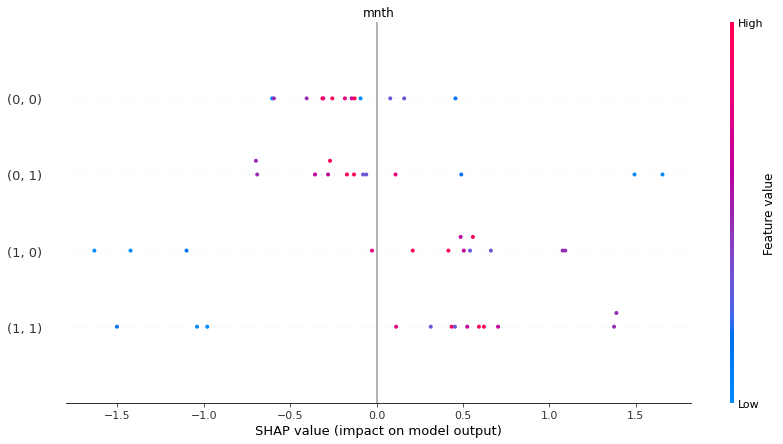

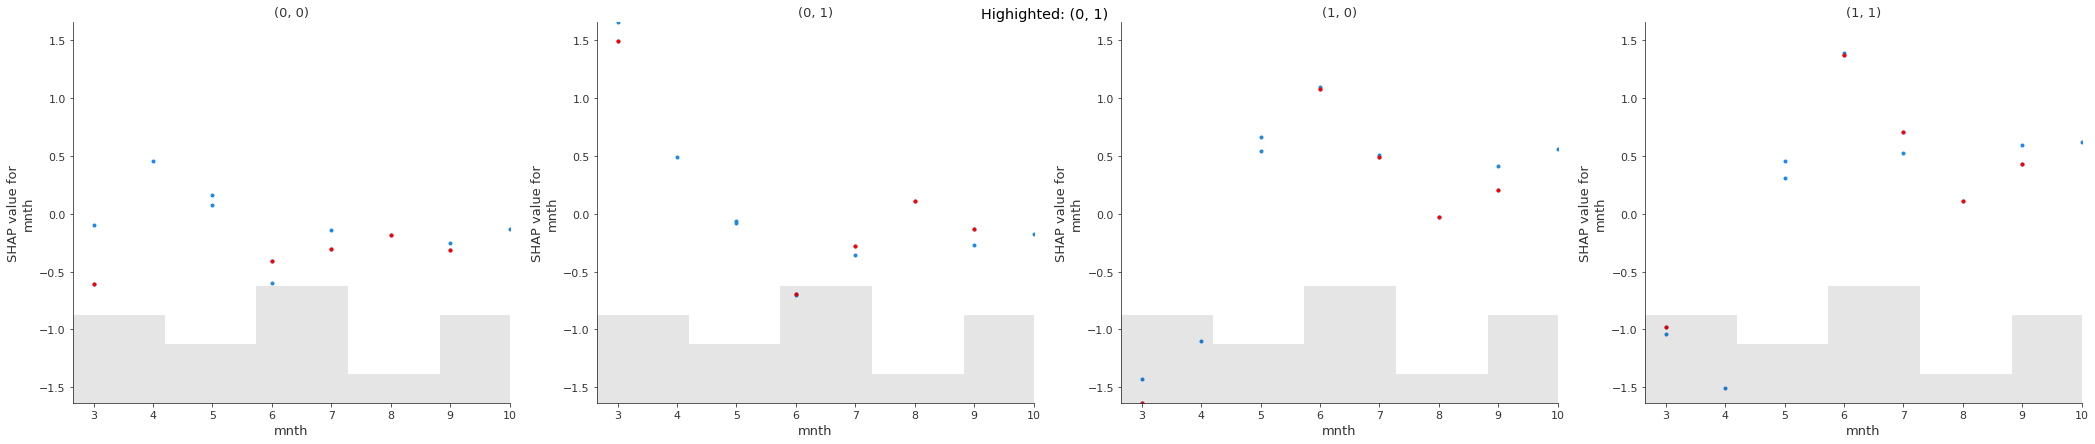

In [65]:
plot_next_feature()

only mid-range windspeed values present, increase => lower odds for difference class and increase them for $(0,0)$

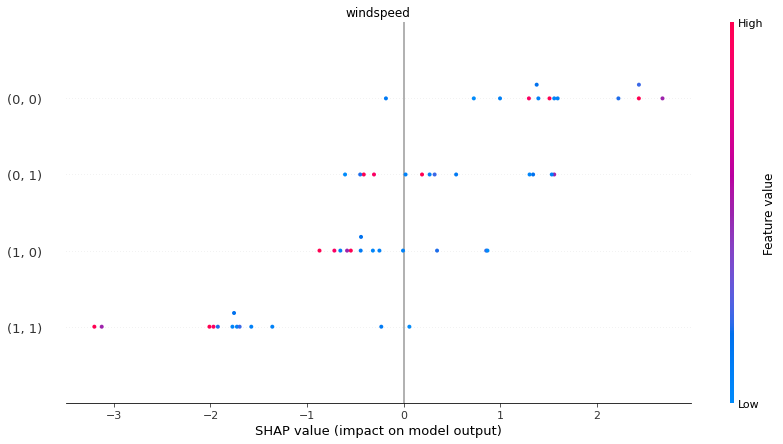

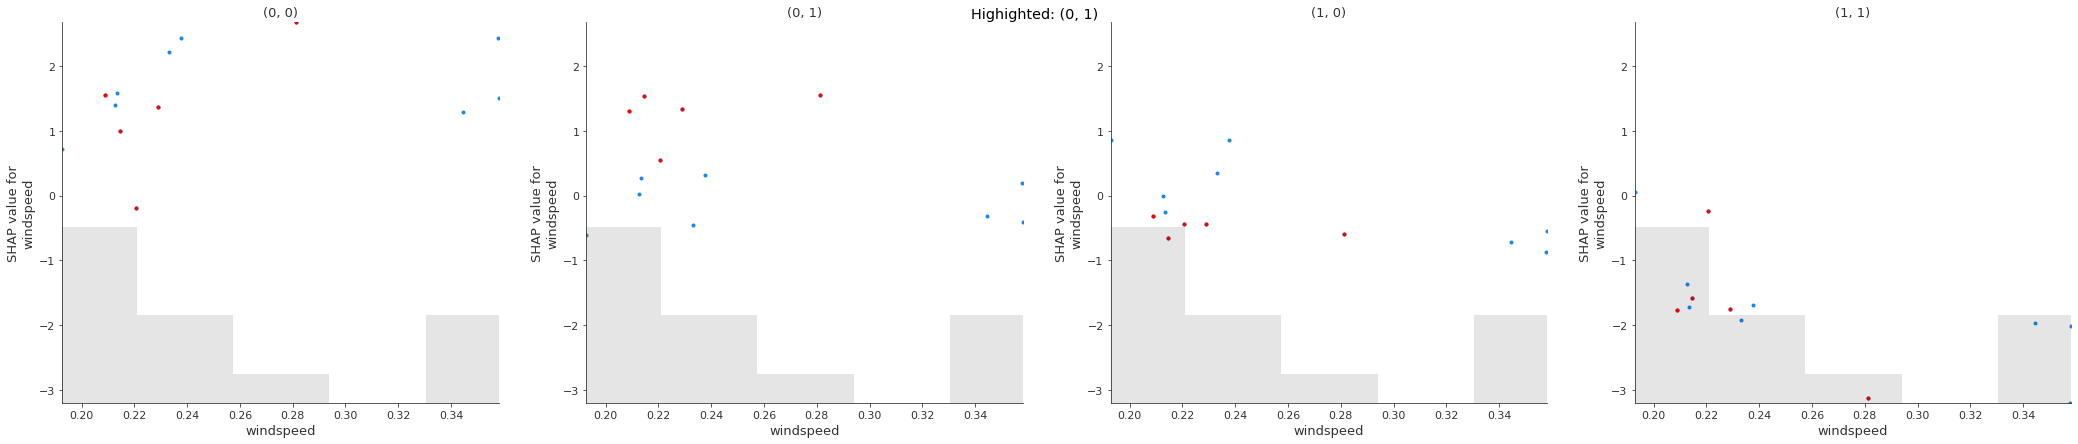

In [66]:
plot_next_feature()

only values 2 and 3 present, no trends visible

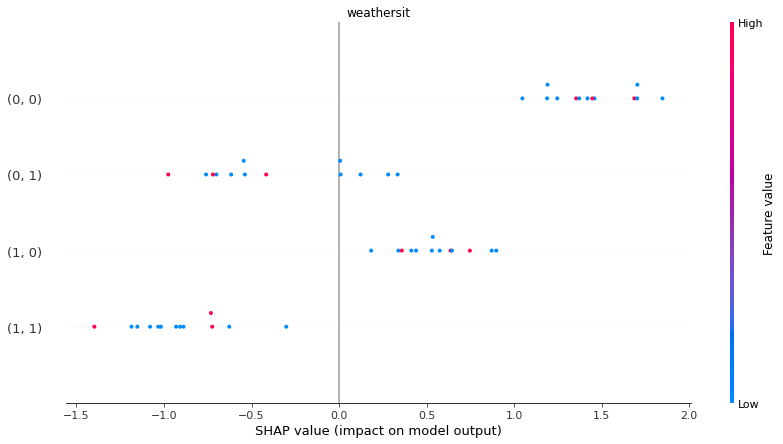

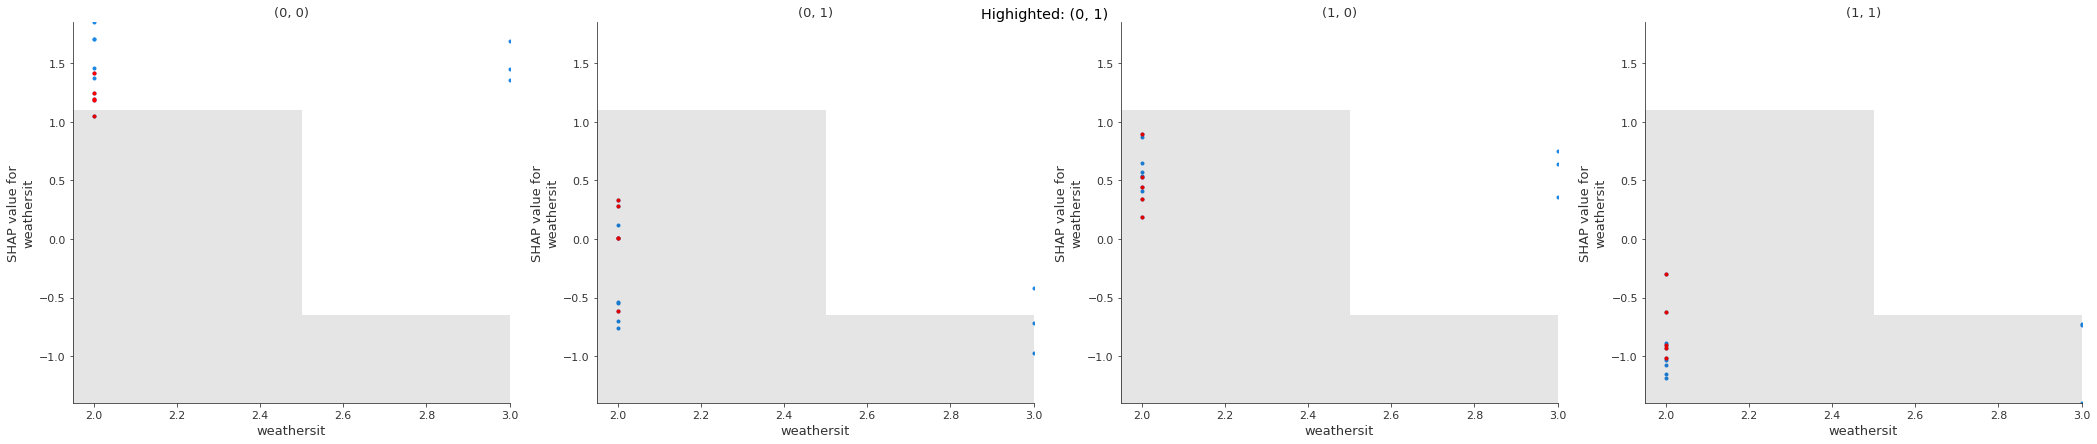

In [67]:
plot_next_feature()

only mid-range values present, we can only expect the instance on the lower side to increase odds for $(1,1)$ if increased. 

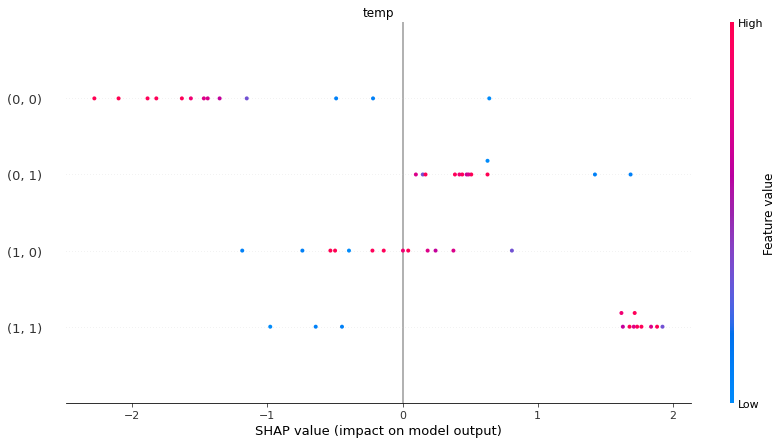

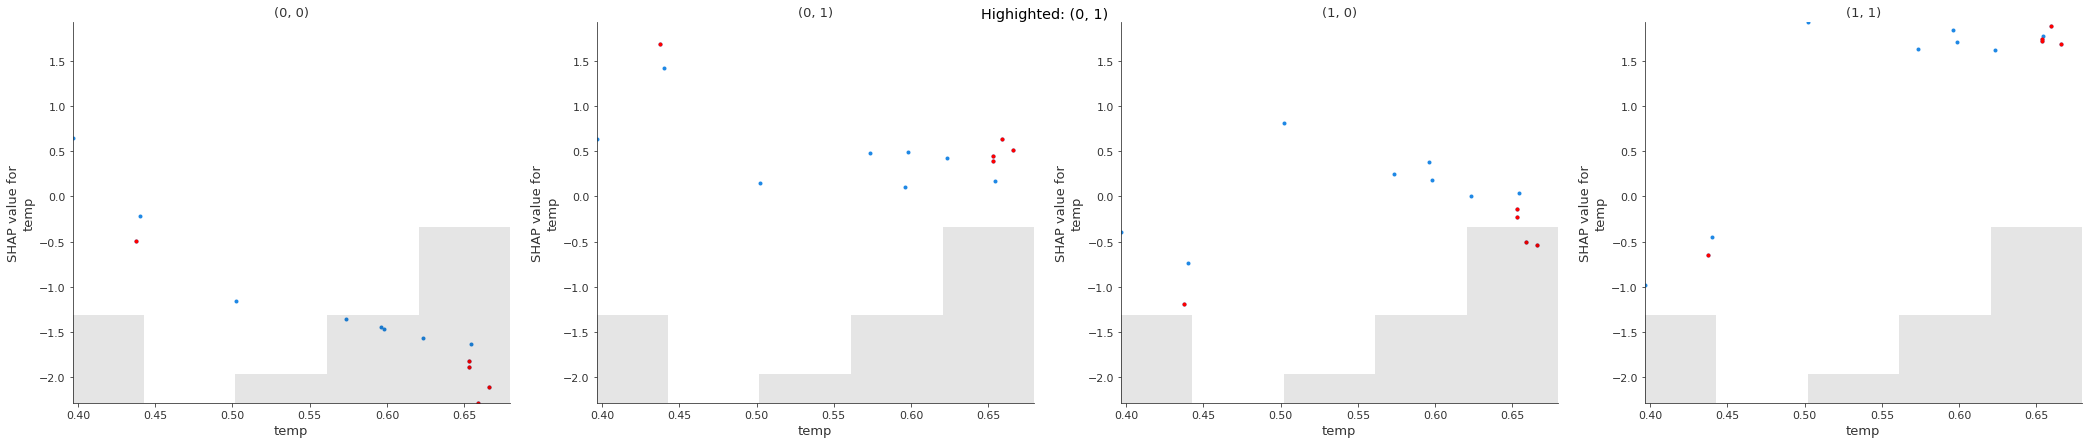

In [68]:
plot_next_feature()

same as for temp.

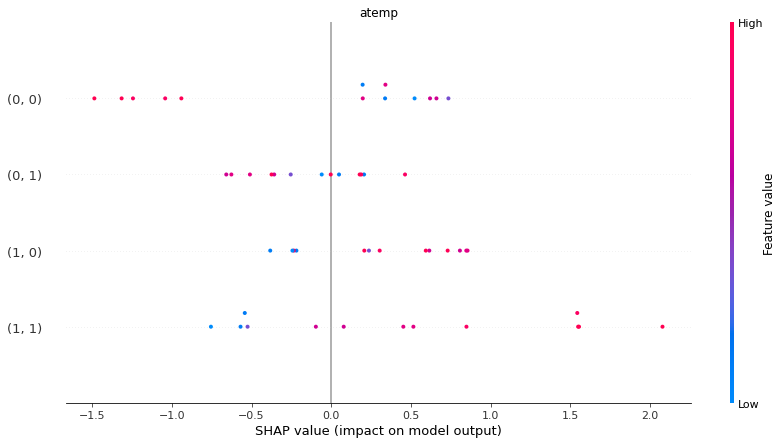

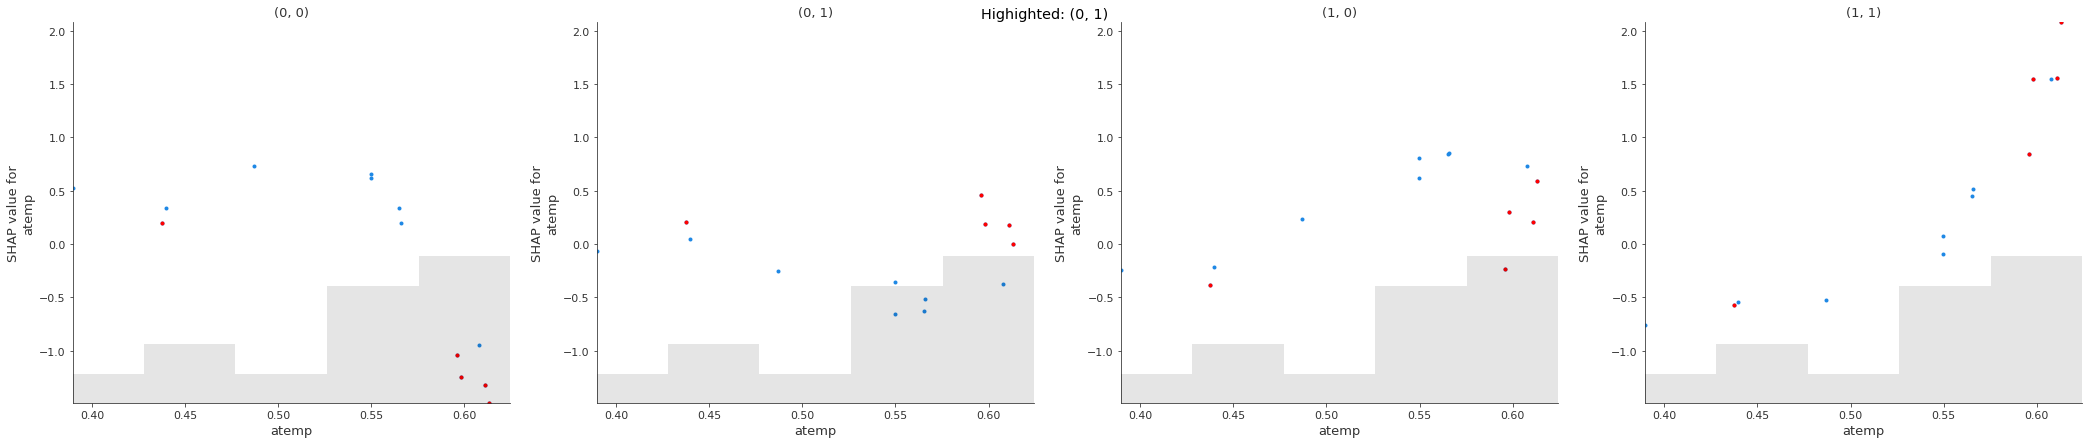

In [69]:
plot_next_feature()

only seasons 2-4, increase values => $(1,1)$, decrease => $(0,0)$

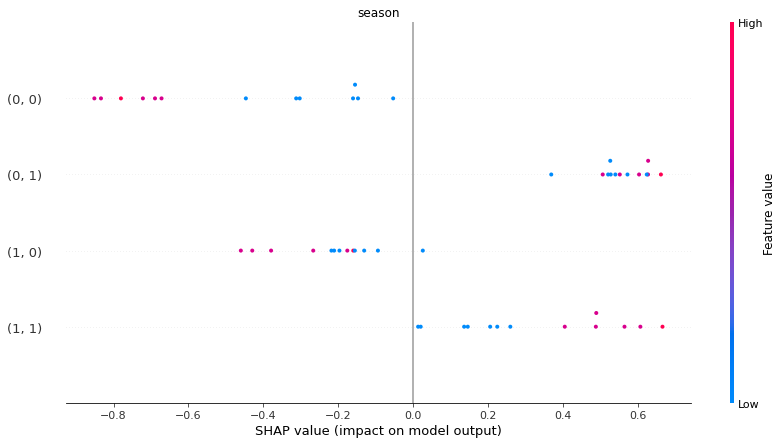

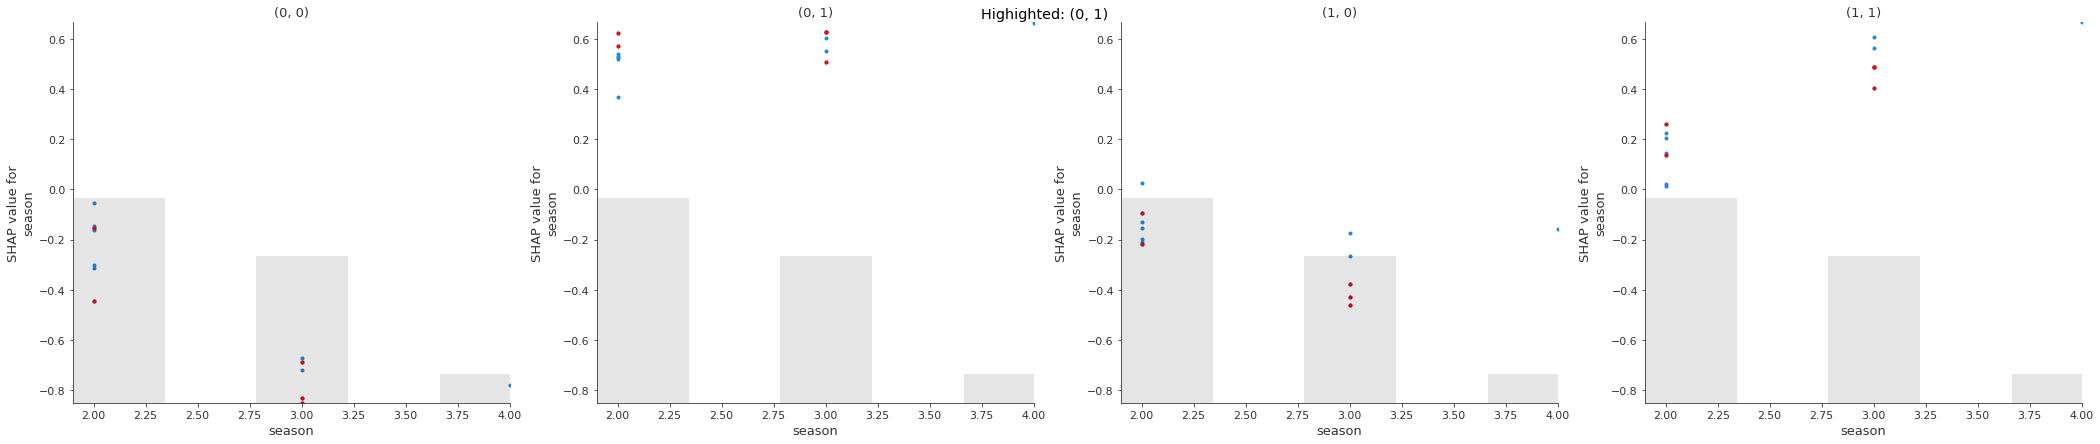

In [70]:
plot_next_feature()

### diro2c

In [36]:
diff_class = diff_classes[0]
start_idx = 0

In [ ]:
%%time
explanation = generate_diro2c_explanation(shap_values.data, start_idx, comparer, diff_class, scale_features=scale_features)
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f)

In [25]:
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In the first figure we can see, that for $windspeed>0.3$ and $atemp<0.48$ there are
increasingly more instances classified equally and thus supporting theory 1.1 and 1.2.
Regarding theory 2.5, we see instances classified equally at 0.55 and above 0.65.

In the second figure, we can see that for $mnth>3$ there are more instances
classified equally, supporting theory 2.2 but no indication that
a higher `weekday` would have an influence. This might be due to the fact,
that the starting instance was of `weekday` Saturday.

In figure 3, we see that see more instances classified equally for `season` winter,
supporting theory 2.6 and also more instances classified equally for increased
values of `temp`, which supports theory 2.4, but also for lower values.


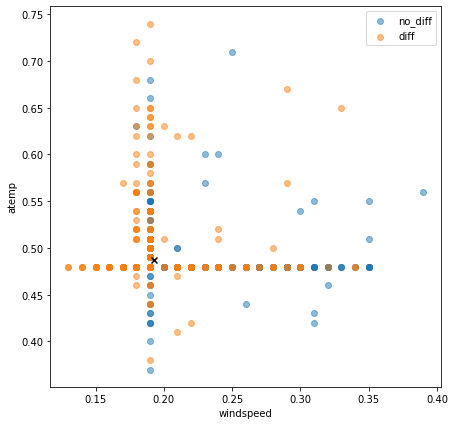

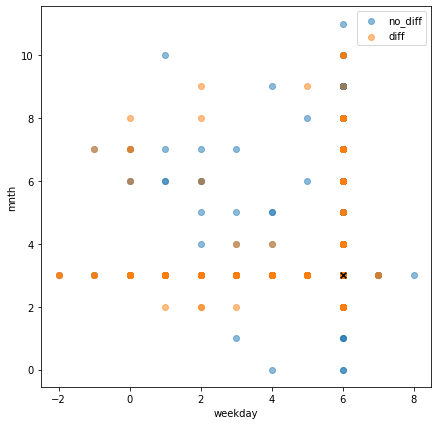

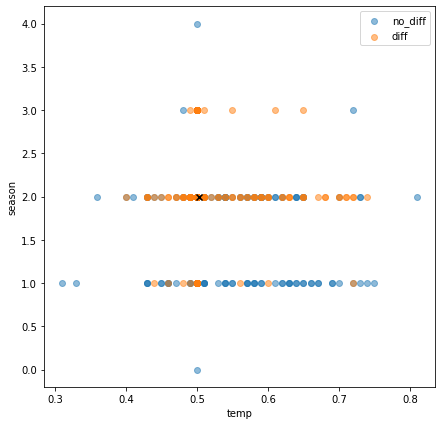

In [44]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, 'windspeed', 'atemp', highlight=x)
plot_diro2c_2d(explanation, 'weekday', 'mnth', highlight=x)
plot_diro2c_2d(explanation, 'temp', 'season', highlight=x)

## 5th Cluster

In [73]:
cluster, shap_values, pred_classes, diff_classes = get_next_cluster()

(0, 0)  (0, 1)  (1, 0)  (1, 1)
c5       0       7       0      56

### SHAP-based Difference Classifier Explanations

windspeed and humidity now on top

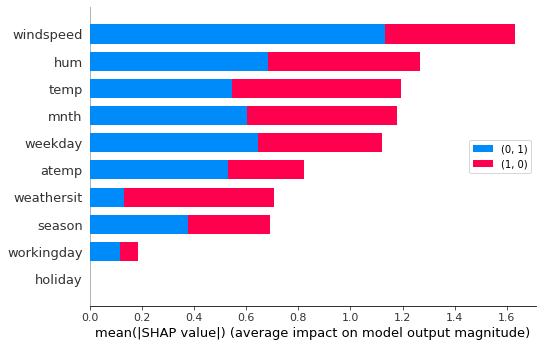

In [74]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, comparer.difference_classes])
plot_feature_importance_bar(shap_values[:, :, comparer.difference_classes])

In [75]:
feature_order = feature_order[:-1]

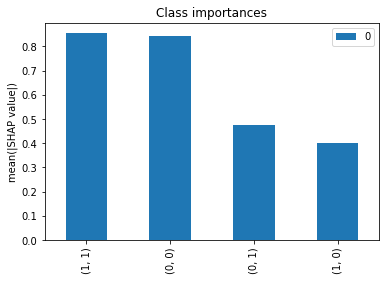

In [76]:
class_order, class_importances = calc_class_order(shap_values)
plot_class_importances(class_importances, class_order, shap_values.output_names)

In [77]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(shap_values[:, [feature_idx]])
    for diff_class in diff_classes:
        plot_feature_effects(shap_values[:, [feature_idx]], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}')
it = iter(feature_order)

only low windspeed values present, linear trend: decrease value => lower odds for difference class, increase odds for $(1,1)$

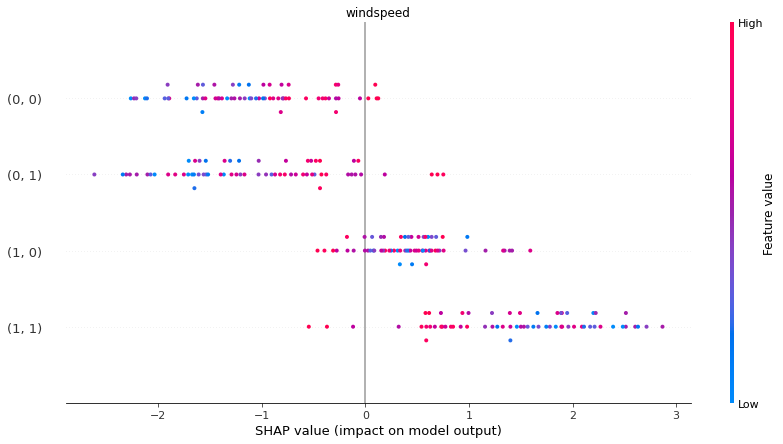

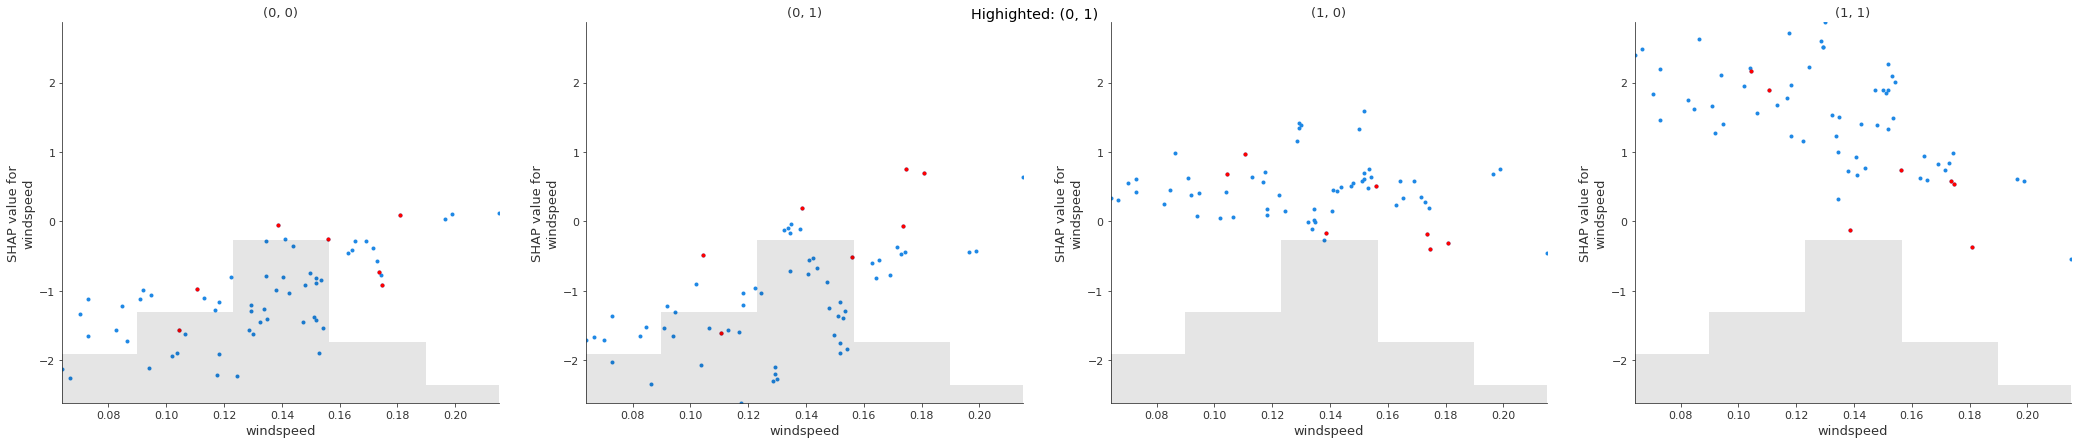

In [78]:
plot_next_feature()

only mid-range values present, increase value => $(0,0)$

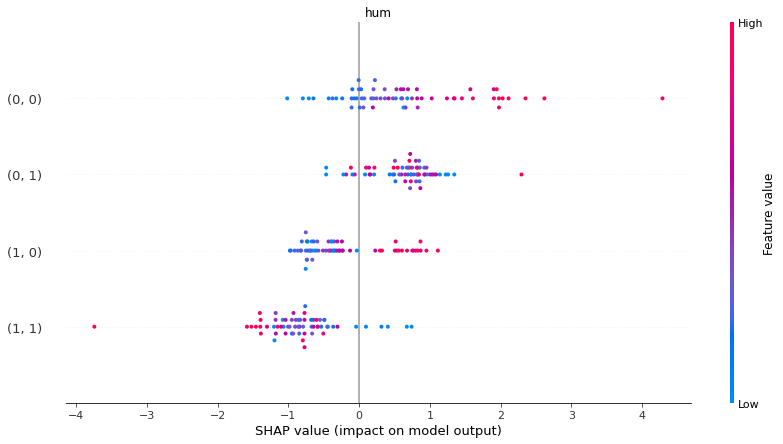

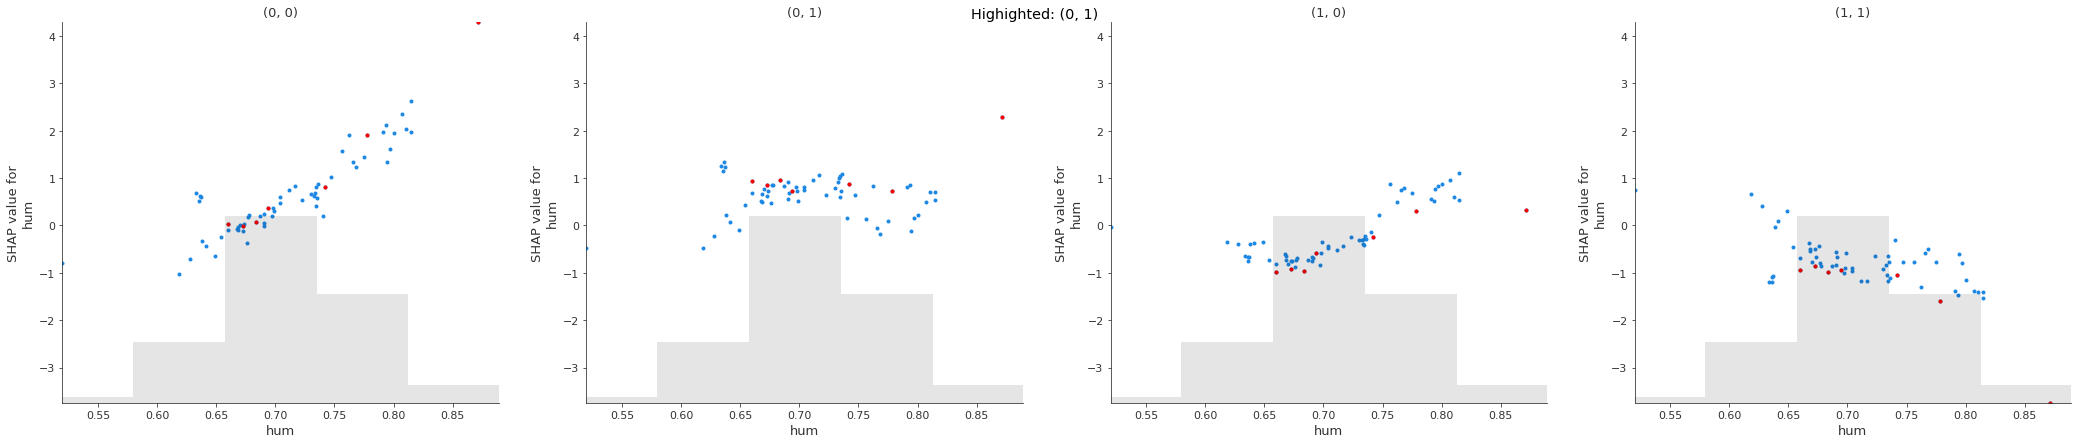

In [79]:
plot_next_feature()

only mid-to mid-high range present, no trend visible.

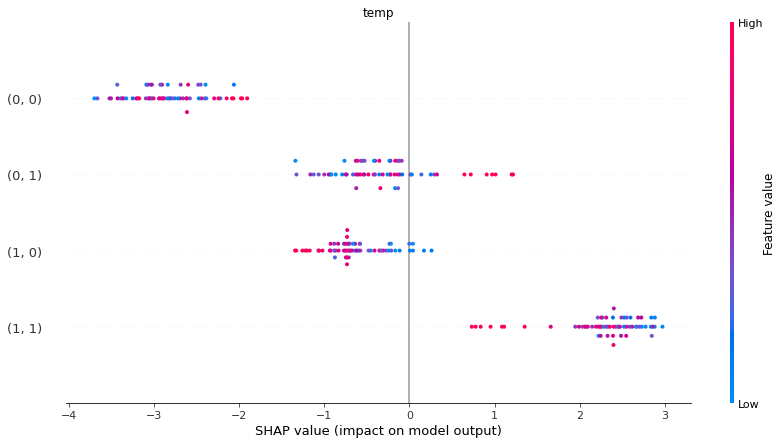

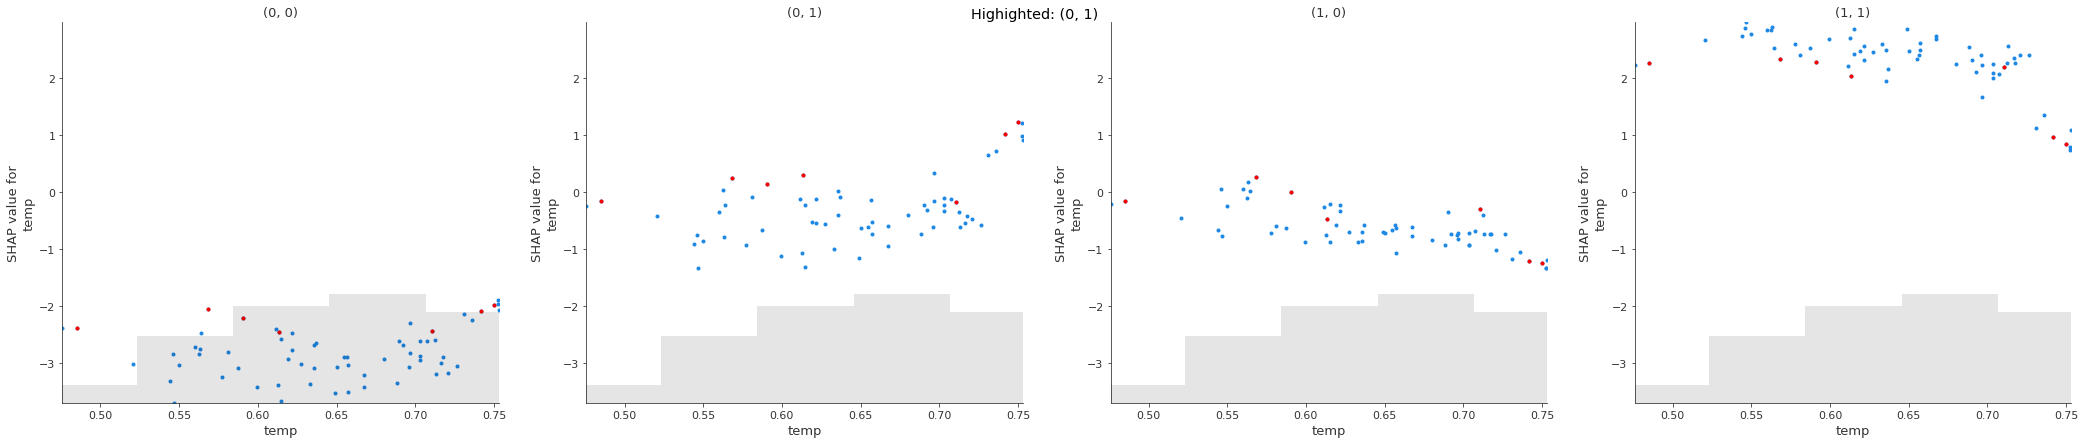

In [80]:
plot_next_feature()

only higher values present, no trend.

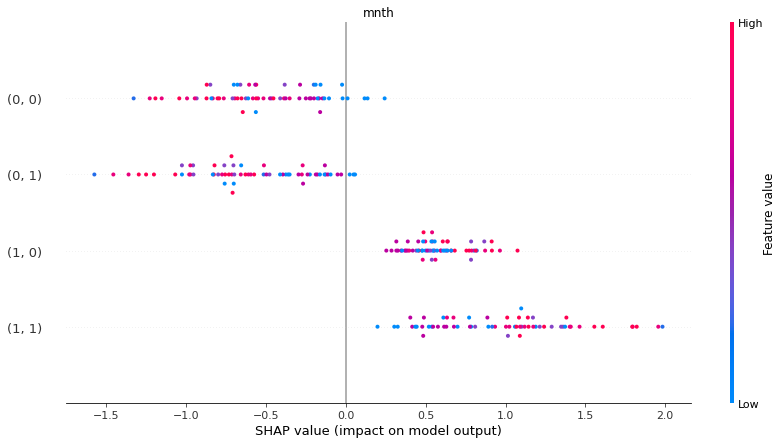

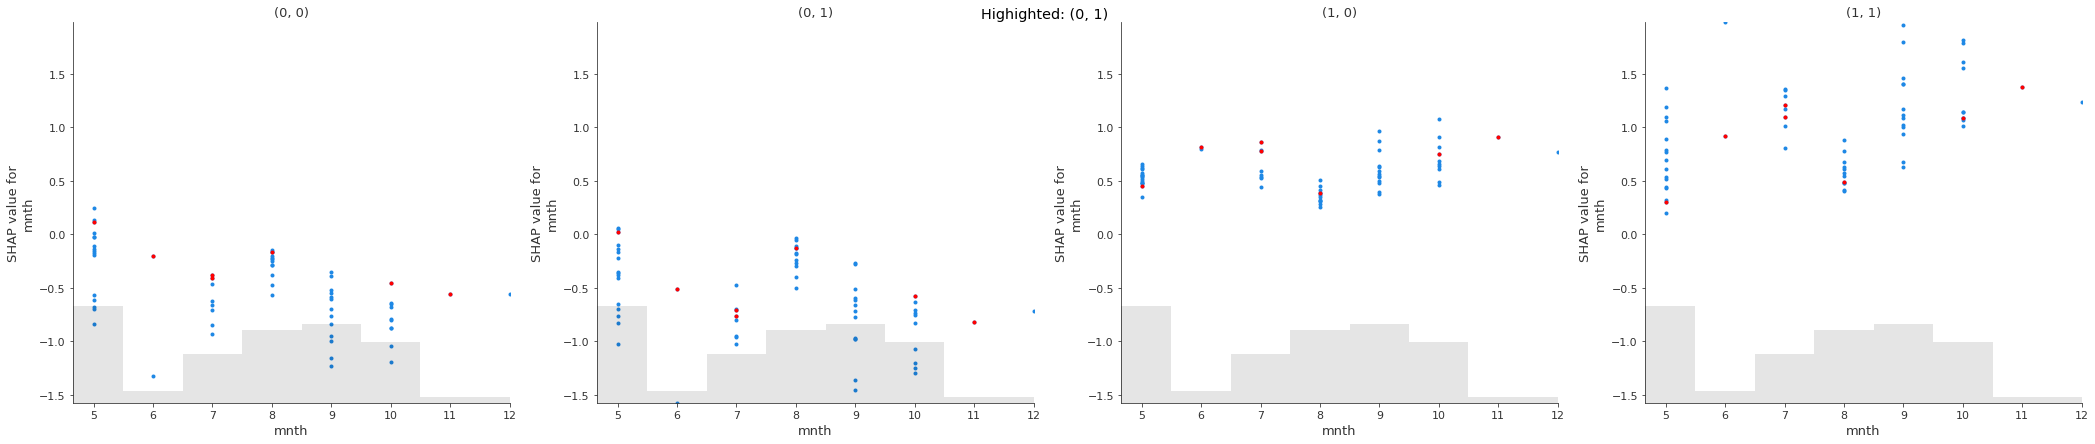

In [81]:
plot_next_feature()

weekday, all values present, instances classified differently on the lower side. increase value => decrease odds for difference class, increase odds for $(1,1)$

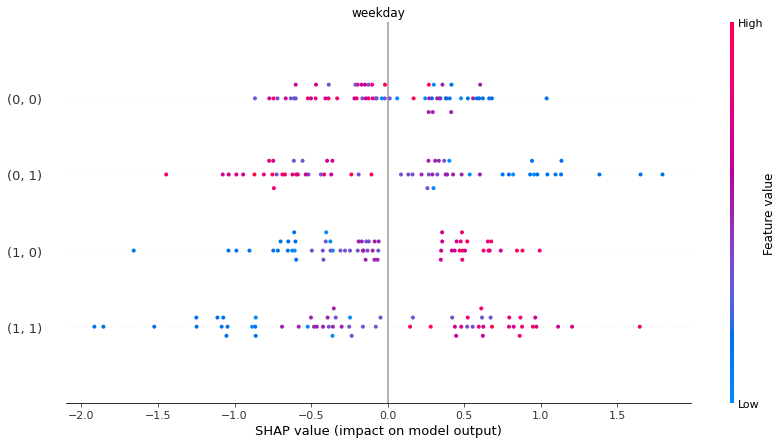

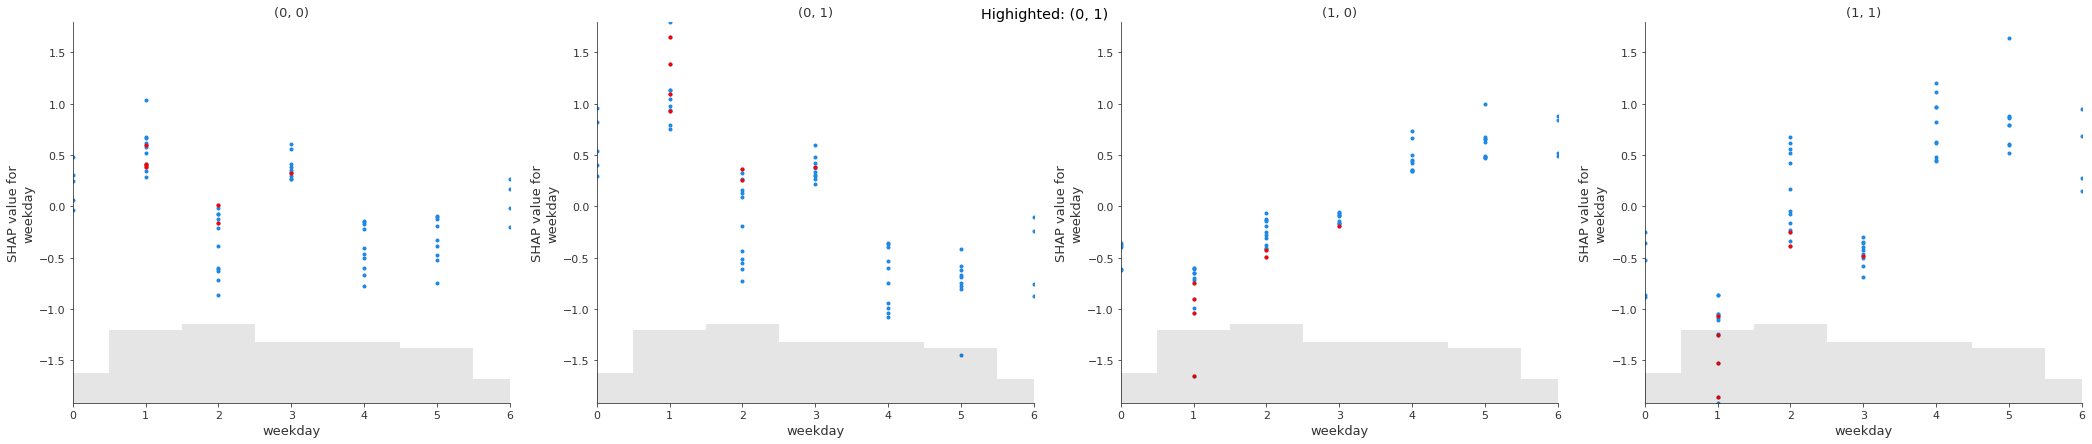

In [82]:
plot_next_feature()

only mid-to high range values present, only fery tiny trend.

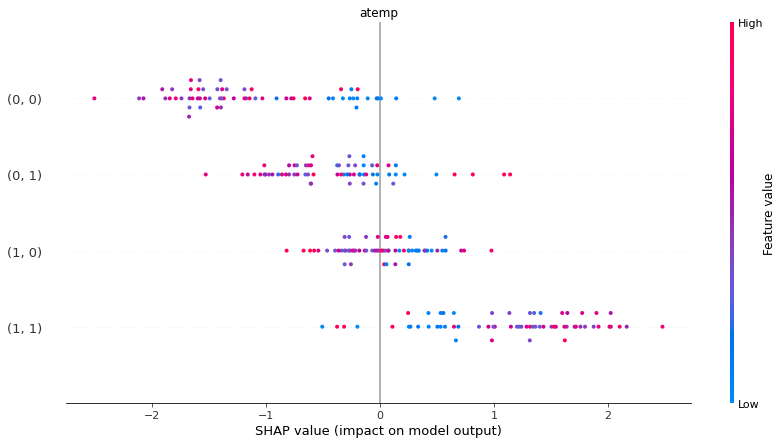

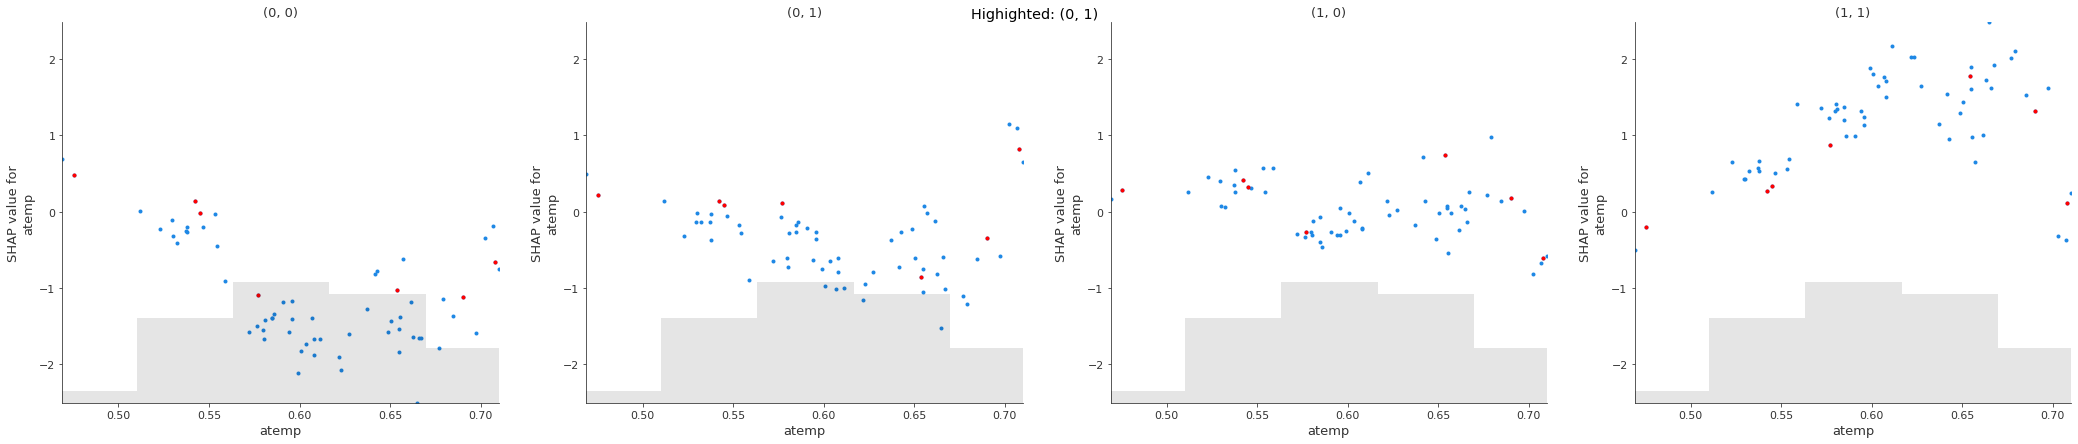

In [83]:
plot_next_feature()

all values present. like on global level

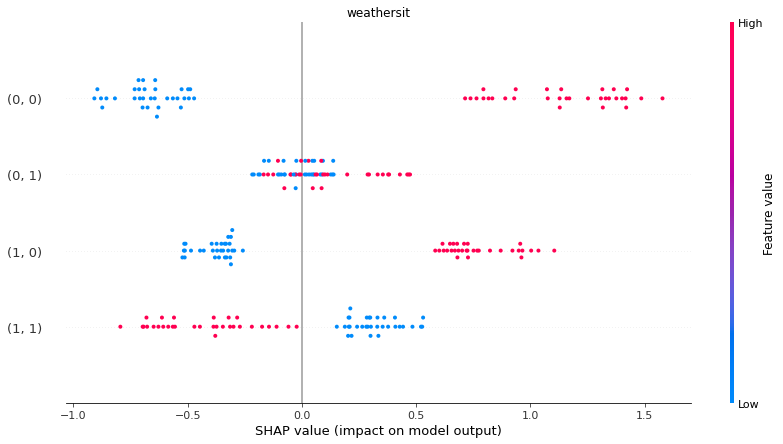

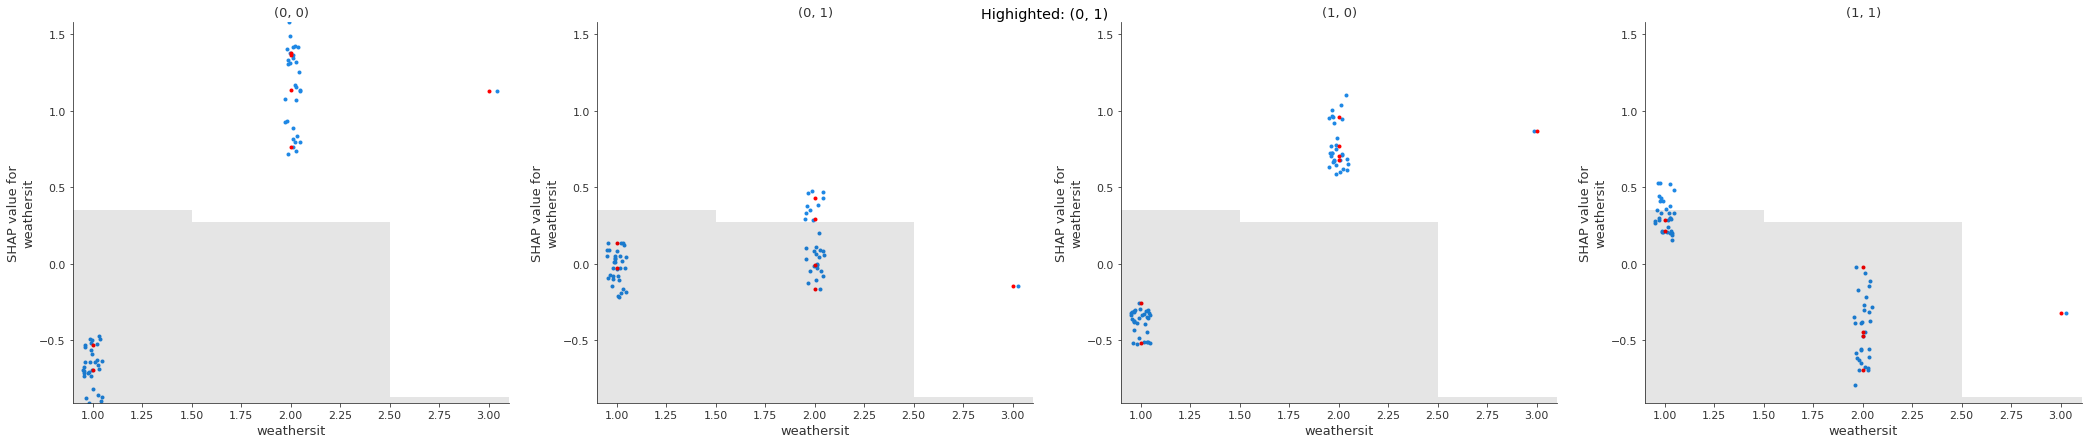

In [84]:
plot_next_feature()

only seasons 2-4, increase values => $(1,1)$, decrease => $(0,0)$

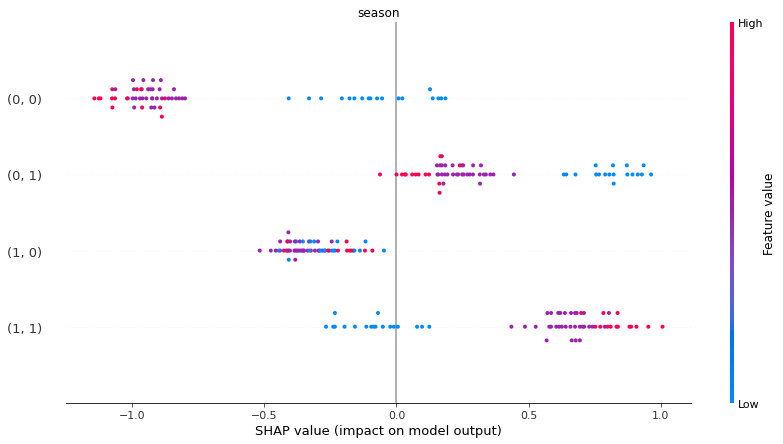

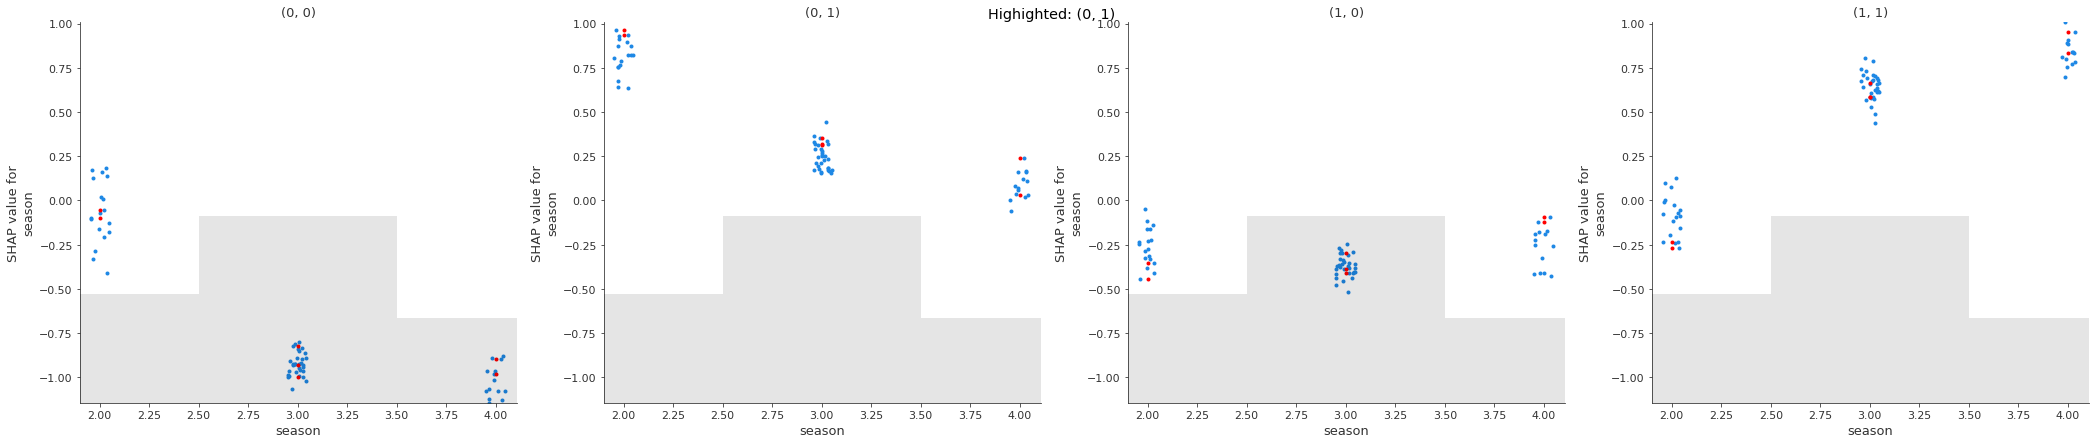

In [85]:
plot_next_feature()

### diro2c

In [86]:
diff_class = diff_classes[0]

CPU times: user 11min, sys: 28.4 s, total: 11min 28s
Wall time: 3min 5s


In [ ]:
%%time
explanation = generate_diro2c_explanation(shap_values.data, 0, comparer, diff_class, scale_features=scale_features)
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f)

In [ ]:
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

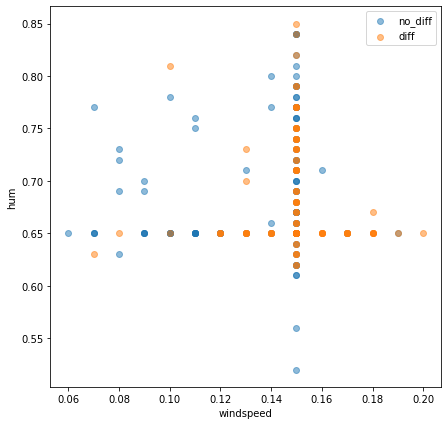

In [87]:
plot_diro2c_2d(explanation, feature_order[0], feature_order[1])